# Introduction

The previous version of the algorithm did not have sufficiently tight bounds. Hopefully this version will improve on this. We explain the algorithm, then implement it, step by step in the notebook below.

1) Consider the GP prediction as the sum of exponentiated quadratics centred on all the training points.
2) Split the world into hypercubes.
3) Consider one dimension d.
4) Find how much each of the EQs changes over a given dimension (d) within each hypercube, effectively we just evaluate each EQ in the one dimension (d) at the start and end of the hypercube. We use these 'integrals' (of the derivative over d) as the peak values in the following mixture of Gaussians... we call this result $D^{all}$. Note that the locations can lie outside the hypercube, in the non-d dimensions.
5) Repeat the above but subtract the maximum of the EQ (e.g. if it has a peak that is inside the hypercube this will be different from the result in step 4) from its minimum. We again use these differences as peak values in the following... we call this $D^+$

6) We reintroduce the other dimensions of the hypercube. We can imagine the total change made to the predictions over the d-1 plane (of remaining dimensions) by moving a $d-1$ plane from one side of the hypercube to the other (along dimension d). This can be represented as a series of gaussians (EQs), each centred at one of the training points.

<pre>
d=2 example, n=3.        ------> sum of EQs   
                       |    .
                       |      .
      x                |       .  <-x
 ______________        |__   .
|              |  ,    |  .
|        o     | /|\   | .        <-o
|              |  |    |   .
|   x          |  |    |      .   <-x maximum within bounds of hypercube
|______________|  |z   |__   .
  ---------> d         |   .
                       |  .
                       | .

training points
x with weight = 1
o with weight = -1
</pre>

In the figure, imagine the distribution along the other axis (z) - it will be three EQs over one ($d-1$) dimensions. This sum will be the sum of three EQs (of d-1) dimensions centred at the locations of the training points (with the dth dimension removed).

7) We want to find the largest change possible in the prediction by moving along the d-axis, over the hypercube, both if we've stopped the integration somewhere within it, or if the integration was over the whole cube. Hence we needed the two results (from 4 and 5)...
8) We therefore will later be interested in the largest value in the $d-1$ space of this sum of gaussians. We will also be interested in the case in which the negative EQs are removed.

9) We next consider lists of hypercubes that one needs to pass through to get from the start to the end of dimension d. E.g. in this figure you need to pass through for example C, I, D and H. A full list of possible combinations will need to be made, e.g.:
<pre>
C I D H
C I D G
B D G
B D F
..etc

 ________________
|    |  |    |  |
| b  | d|    |H |
|   C|I | D  |_f|
|____|__|  e |G |
|   B c |    |__|
|_______|____|F |
|            |__|
xa   x  H    |E |
|____________|__|
0 1 2 3 4 5 6 7 8

Where A-I are the 9 hypercuboids, a-f are the peaks of the EQs.</pre>

10) For each list we need to consider all possible start and ends, for the first list the possible combinations are:
<pre>
C->C
C->I
C->D
C->H
I->I
I->D
..etc
</pre>
11) For each combination we then combine all the EQs from the hypercubes:
E.g. for the C->D list:

[$D^+$ EQs from <texttt>C</texttt>] + [$D^{all}$ EQs from <texttt>I</texttt>] + [$D^+$ EQs from <texttt>D</texttt>]


So the $D^+$ for hypercube C, would consist of:
- for a the difference between the minima and maxima of the value of a's EQ between 0 to 2.5 along a's other axes (i.e between the two bold xs)
- the same computation for b.

For the $D^{all}$ for hypercube I:
for point d we find the difference between the value of d's EQ at 2.5 and 4 (in the same axis in d's other dimensions).
As we're looking for the maximum possible change between a point in C to a point in D, we know that we must pass through the whole of I, hence why we include all the negative and positive gradient parts of the EQs.

12) We are left with a sum of EQs (all with the same lengthscales etc) but with different weights and locations (in a $d-1$ space), for each of the pairs of possible starts and ends.

13) For each of these sums. We want to find a bound on the maximum of this sum. (see other emails/module for this).

14) We find the maximum bound for each of the sums. And that is an upper bound on the largest change that can happen for any movement along the d axis.


So the first steps we need to do maths for is (4) and (5):

>    4) Find how much each of the EQs changes over a given dimension (d) within each hypercube, effectively we just evaluate each EQ in the one dimension (d) at the start and end of the hypercube. We use these 'integrals' (of the derivative over d) as the peak values in the following mixture of Gaussians... we call this result $D^{all}$. Note that the locations can lie outside the hypercube, in the non-d dimensions.

>    5) Repeat the above but subtract the maximum of the EQ (e.g. if it has a peak that is inside the hypercube this will be different from the result in step 4) from its minimum. We again use these differences as peak values in the following... we call this $D^+$

### Two dimensional Demonstration

Here we place ten points randomly in the 5x5 square, of random weights (selected from the unit-normal distribution).

We compute the bound. Note that as we're only in 2d the algorithm doesn't compact to a lower-dim manifold so it gets to include the negative possible changes properly.

Above 3d the algorithm compacts to a lower dimensional manifold for speed in the grid search - but this means ignoring negative gradients, making the bound larger (we'll see that later in higher dimensions)...

In [35]:
import numpy as np
np.set_printoptions(suppress=True,precision=6)
import matplotlib.pyplot as plt
%matplotlib inline
from GPAdversarialBound import compute_full_bound, zeromean_gaussian

#set up lengthscale, hypercubes, etc...
ls = 0.5
diff_dim = 0
dims = 2
cubesize = 6
N = 50
X = np.random.rand(N,dims)*6
X[:,1] = X[:,0] + np.random.rand(N)*1
Y = -(np.sin(2*X[:,0])+0.2*np.random.randn(N))[:,None]>0
Y = Y*1.0
#Y = np.abs(np.random.randn(N,1))
#Y[X[:,0]<2.5,0] = -Y[X[:,0]<2.5,0] #simple signal - negative on one side of 2.5

import GPy
m = GPy.models.GPRegression(X,Y)
m.rbf.lengthscale = 0.01
m.optimize()

In [36]:
m

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


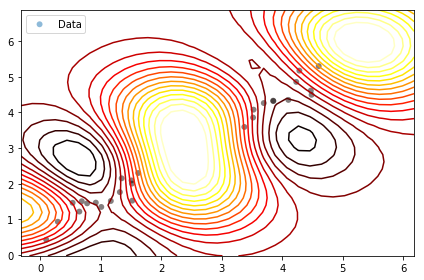

In [37]:
m.plot()

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


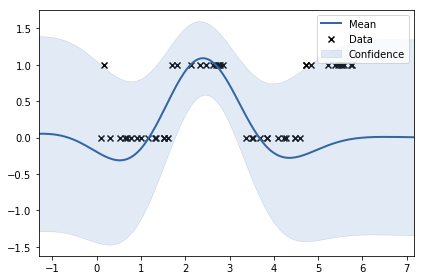

In [38]:
m.plot(fixed_inputs=[(1,3)])

In [44]:
sigma = np.sqrt(m.Gaussian_noise.variance)
v = m.rbf.variance
ls = m.rbf.lengthscale
gridres = 30

In [47]:
splitcount = 100
forceignorenegatives = False
logistic_transform = False
bound, hypercube_starts, hypercube_ends, maxseg, EQweights = compute_full_bound(X,Y,sigma,ls,v,diff_dim,dims,cubesize,gridres=gridres,splitcount=splitcount,forceignorenegatives=forceignorenegatives,logistic_transform=logistic_transform)

Splitting...
Computing Paths...
Checking Segments...

0/26685.....................................[1.125  5.0625] [6.     5.0625]
start>end
[439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760, 226, 888] 0

1/26685..............[3.75   5.4375] [5.4375 5.4375]
start>end
[594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63, 759] 0

2/26685........[711, 914, 742, 923, 848, 999, 941, 953] [0.088646]

3/26685.....[729, 801, 769, 824, 861] [0.270076]

4/26685...............[436, 158, 455, 80, 605, 136, 346, 47, 913, 238, 755, 68, 653, 182, 600] [0.247079]

5/26685.......................[487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261, 263] [-0.080639]

6/26685...............[455, 80, 605, 136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613] [0.313301]

7/26685.................[120, 495, 148, 661, 172, 63

142/26685...................[443, 339, 365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386] [0.914784]

143/26685..........[946, 240, 770, 175, 685, 197, 693, 214, 760, 226] [0.318102]

144/26685...[243, 963, 52] [0.303304]

145/26685.............[89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259] [0.178728]

146/26685.........[770, 175, 685, 197, 693, 214, 760, 226, 888] [0.284789]

147/26685..[324, 359] [0.428017]

148/26685[411] [0.158438]

149/26685...................................[1.6875 4.6875] [5.8125 4.6875]
start>end
[762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803, 64, 900] 0

150/26685.....................[509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793] [0.456103]

151/26685..........[204, 799, 7, 954, 248, 871, 57, 611, 153, 519] [0.66915]

152/26685...[865, 711,

260/26685...................[299, 216, 217, 920, 233, 934, 234, 293, 294, 285, 286, 307, 308, 453, 454, 874, 875, 332, 69] [0.424698]

261/26685.............................................[721, 833, 570, 634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116, 724, 261, 263, 783] [0.290393]

262/26685..[710, 800] [0.293992]

263/26685......................[323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463] [0.916839]

264/26685.......[435, 498, 545, 635, 766, 597, 703] [0.59833]

265/26685...[491, 512, 636] [0.385665]

266/26685.......................[758, 117, 560, 152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402] [0.944165]

267/26685..........[781, 66, 289, 109, 450, 116, 724, 261, 263, 783] [0.04089]

268/26685......................[718, 589, 761

347/26685..............................[411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970] [0.21082]

348/26685...........................[2.8125 4.6875] [5.625  4.6875]
start>end
[273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728] 0

349/26685[893] [0.13918]

350/26685......................................[0.     4.6875] [5.71875 4.6875 ]
start>end
[22, 245, 439, 13, 762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803, 64] 0

351/26685.....................................[546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475] [0.388069]

352/26685.......................[319, 203

424/26685.................[344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166] [0.032107]

425/26685........[654, 668, 555, 568, 425, 441, 338, 356] [0.262157]

426/26685............................[455, 80, 605, 136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729] [0.704778]

427/26685.................[649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573] [0.68441]

428/26685.....................[380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867] [0.630121]

429/26685..............................[1.875  5.0625] [5.53125 5.0625 ]
start>end
[434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770, 175, 685, 197] 0

430/26685......................................[716, 730, 517, 523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512

576/26685...........[434, 697, 302, 426, 257, 290, 174, 828, 211, 705, 150] [0.143003]

577/26685...................................[620, 43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393] [0.434811]

578/26685....................[3, 351, 889, 706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562] [0.893281]

579/26685...[133, 427, 89] [0.434035]

580/26685......[420, 49, 360, 86, 264, 883] [0.56367]

581/26685...[540, 38, 582] [0.360321]

582/26685......................[524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66] [0.520519]

583/26685..............[4.125  5.0625] [5.71875 5.0625 ]
start>end
[763, 858, 972, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214] 0

584/26685...............[550, 551, 298, 299, 216, 217, 920, 233, 934, 234, 293, 294, 285, 286, 307] [0.339847]

585/26685.....[657

654/26685...............................[0.     5.8125] [5.90625 5.8125 ]
start>end
[22, 436, 158, 455, 602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232, 921, 271] 0

655/26685...................................[791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24] [0.236868]

656/26685.......[31, 841, 228, 866, 67, 942, 247] [0.186074]

657/26685.....................[596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313] [0.471777]

658/26685...................................[726, 180, 620, 43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996] [0.384785]

659/26685...................[3.65625 5.0625 ] [5.71875 5.0625 ]
start>end
[593, 552, 603, 608, 671,

807/26685................................[328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450] [0.502823]

808/26685..[997, 847] [0.252217]

809/26685..........[287, 998, 191, 995, 284, 223, 288, 143, 792, 198] [0.709957]

810/26685..........................[822, 832, 716, 730, 517, 523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451] [0.476025]

811/26685..........................[173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368] [0.81282]

812/26685......[4.3125 5.0625] [5.15625 5.0625 ]
start>end
[256, 281, 340, 904, 985, 723] 0

813/26685.........................................[960, 746, 924, 546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 9

957/26685..............................[457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241, 114, 895, 115] [0.232355]

958/26685......[81, 378, 6, 511, 122, 639] [0.45338]

959/26685.....................[312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463] [0.898328]

960/26685....................[28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261, 263] [-0.121401]

961/26685.........[31, 841, 228, 866, 67, 942, 247, 964, 36] [0.113561]

962/26685...........[397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561] [0.247501]

963/26685..............[141, 549, 25, 727, 220, 996, 76, 393, 26, 880, 241, 114, 895, 115] [-0.065209]

964/26685.................[495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492] [0.629215]

965/26685....................................[1.5    5.0625] [6.     5.

1027/26685......................[555, 568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396] [0.687357]

1028/26685...........[829, 59, 518, 142, 420, 49, 360, 968, 836, 992, 780] [0.672235]

1029/26685.............[225, 894, 134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130] [0.197069]

1030/26685......[832, 716, 730, 517, 523, 405] [0.249587]

1031/26685..............................[1.875  4.3125] [5.53125 4.3125 ]
start>end
[249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821, 864, 887] 0

1032/26685.........................[2.8125 5.0625] [5.53125 5.0625 ]
start>end
[290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659] 0

1033/26685...[417, 131, 490] [0.373397]

1034/26685.........[189, 812, 259, 278, 324, 359, 475, 500, 717] [0.011626]

1035/26685.......................[7

1095/26685.....................[601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652] [0.697725]

1096/26685..............................[910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809, 933] [0.397122]

1097/26685....................[680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313] [0.419955]

1098/26685.....................[62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5] [0.612091]

1099/26685..[206, 843] [0.282521]

1100/26685.........................[485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880] [0.272784]

1101/26685........................[2.4375 5.4375] [5.34375 5.4375 ]
start>end
[605, 136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 2

1171/26685.......[98, 368, 124, 409, 129, 492, 185] [0.323609]

1172/26685........[528, 534, 641, 648, 867, 872, 279, 541] [0.267637]

1173/26685..[117, 560] [0.363075]

1174/26685.......................................[547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313, 318, 577, 588, 241, 114] [0.327906]

1175/26685............[236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266] [0.521685]

1176/26685...............[503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996] [0.26219]

1177/26685.....................................[0.     4.3125] [5.8125 4.3125]
start>end
[83, 826, 515, 411, 688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 239, 258, 970, 244, 980, 253, 292] 0

1178/26685...........[788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869] [-0.018293]

1179/26

1247/26685.....................................[833, 570, 634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289] [0.543315]

1248/26685......................[344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955] [-0.008208]

1249/26685...........[321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179] [0.165355]

1250/26685................[102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630] [0.639798]

1251/26685.........[52, 859, 195, 806, 45, 835, 196, 926, 46] [0.481999]

1252/26685......................[598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979, 566] [0.404742]

1253/26685...........................[662, 173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368] [

1329/26685...............[3.84375 5.0625 ] [5.53125 5.0625 ]
start>end
[609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659] 0

1330/26685.................[142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944] [0.42453]

1331/26685.................[977, 341, 471, 236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304] [0.537294]

1332/26685............[22, 436, 158, 455, 602, 977, 341, 471, 236, 276, 907, 176] [0.153305]

1333/26685.....[142, 420, 49, 360, 968] [0.622903]

1334/26685................................[22, 245, 439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658] [0.537287]

1335/26685.............................[319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821, 864, 887] [0.217589]

1336/26685.....................[590, 632, 542, 5

1463/26685................[520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745, 263] [-0.036144]

1464/26685...[614, 165, 655] [0.315397]

1465/26685.........[13, 762, 159, 452, 35, 321, 82, 273, 991] [0.25483]

1466/26685................[341, 471, 236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304] [0.579798]

1467/26685............[634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498] [0.484212]

1468/26685..................[661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192] [0.396065]

1469/26685.....[584, 791, 617, 813, 752] [0.406175]

1470/26685.........................[826, 515, 411, 688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815] [0.200966]

1471/26685......................[484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844] [0.540682]

1472/26685.................[377, 12, 326,

1548/26685...............[3.9375 5.0625] [5.625  5.0625]
start>end
[170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702] 0

1549/26685................[914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424, 530] [0.06176]

1550/26685..[101, 473] [0.389396]

1551/26685.........[363, 337, 354, 380, 398, 491, 512, 636, 674] [0.494027]

1552/26685...................................[161, 662, 173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192] [0.531275]

1553/26685.......[604, 154, 818, 208, 753, 97, 525] [0.584645]

1554/26685..........[4.125  5.0625] [5.34375 5.0625 ]
start>end
[200, 845, 256, 281, 340, 904, 985, 723, 797, 658] 0

1555/26685..........[80, 605, 136, 346, 47, 913, 238, 755, 68, 653] [0.221828]

1556/26685.....[352, 85, 316, 91, 320] [0.490067]

1557/26685...........................[2.4375 5.8125] [6.     5.8125]
start>end
[977

1635/26685..............................[966, 250, 758, 117, 560, 152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144] [0.806955]

1636/26685.............[911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239] [0.424288]

1637/26685................................[1.875  5.4375] [5.90625 5.4375 ]
start>end
[455, 80, 605, 136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824, 861] 0

1638/26685....[447, 481, 376, 396] [0.466017]

1639/26685..........[700, 181, 709, 221, 805, 266, 1001, 304, 395, 529] [0.634088]

1640/26685..........................[826, 515, 411, 688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908] [0.199635]

1641/26685....................[203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283] [0.106145]

164

1717/26685......................[678, 229, 387, 168, 987, 978, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742] [0.63286]

1718/26685..............[966, 250, 758, 117, 560, 152, 482, 92, 431, 128, 433, 112, 489, 151] [0.435838]

1719/26685.........................[9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803] [0.391728]

1720/26685......[296, 829, 59, 518, 142, 420] [0.53867]

1721/26685...........[103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76] [0.275662]

1722/26685.........[91, 320, 96, 367, 120, 495, 148, 661, 172] [0.640587]

1723/26685...............[4.21875 4.6875 ] [5.90625 4.6875 ]
start>end
[870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809, 933] 0

1724/26685..................[0.75   3.5625] [2.8125 3.5625]
start>end
[168, 287, 998, 191, 995, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865] 0

1725/26685.............[968, 836, 992, 780, 

1788/26685.................[644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824] [0.667411]

1789/26685.....................[434, 697, 302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256] [0.290639]

1790/26685.....[879, 293, 294, 285, 286] [0.500656]

1791/26685..............[4.03125 5.4375 ] [5.71875 5.4375 ]
start>end
[689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769] 0

1792/26685..........[553, 397, 468, 369, 442, 390, 460, 438, 520, 502] [0.348208]

1793/26685[104] [0.269]

1794/26685..............[96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358] [0.877267]

1795/26685............[4.21875 4.6875 ] [5.625  4.6875]
start>end
[870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728] 0

1796/26685.................[3.375  5.8125] [5.53125 5.8125 ]
start>end
[777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 215, 937, 265] 0

1797/26685.....[928, 230, 915, 1

1876/26685...............................[971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898, 902] [0.055036]

1877/26685......................................[177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24, 993] [0.287416]

1878/26685.......[210, 789, 53, 741, 179, 675, 18] [0.222034]

1879/26685............[59, 518, 142, 420, 49, 360, 968, 836, 992, 780, 945, 788] [0.650583]

1880/26685..[846, 997] [0.256738]

1881/26685.................[150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770] [0.612988]

1882/26685............[70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824, 861] [0.4434]

1883/26685.....[4.21875 4.6875 ] [4.96875 4.6875 ]
start>end
[870, 246, 20, 305, 853] 0

1884/26685.............[437, 464, 508, 536, 587, 715, 790,

1964/26685................................[537, 554, 421, 443, 339, 365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572] [0.682391]

1965/26685..........[625, 624, 627, 691, 699, 837, 844, 267, 105, 428] [0.339601]

1966/26685...............................[1.5    5.4375] [5.71875 5.4375 ]
start>end
[158, 455, 80, 605, 136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769] 0

1967/26685...................[85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98] [0.961379]

1968/26685.......................[337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867] [0.656046]

1969/26685.............[221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937, 265, 906] [0.65097]

1970/26685.......................................[382, 27, 342, 95, 350

2037/26685..........[14, 496, 140, 513, 42, 573, 160, 652, 5, 748] [0.144782]

2038/26685....[60, 274, 15, 306] [0.342051]

2039/26685........[744, 434, 697, 302, 426, 257, 290, 174] [0.295163]

2040/26685..[408, 100] [0.434299]

2041/26685.......................[316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492] [0.860689]

2042/26685.........[675, 18, 683, 178, 740, 56, 870, 246, 20] [0.443625]

2043/26685........[97, 525, 133, 427, 89, 402, 108, 412] [0.480612]

2044/26685..............................[142, 420, 49, 360, 968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75] [0.179781]

2045/26685......................................[83, 826, 515, 411, 688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821, 864, 887, 918] [0.375898]

2046/26685...[573, 

2134/26685...............................[321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803, 64, 900] [0.35735]

2135/26685.............[5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122] [-0.029475]

2136/26685...................[891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957] [0.284476]

2137/26685....................[97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359] [-0.02507]

2138/26685.......................[542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757, 842, 868] [0.65074]

2139/26685...[21, 775, 205] [0.313532]

2140/26685.............[3.84375 5.0625 ] [5.34375 5.0625 ]
start>end
[609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658] 0

2141/26685.................................[377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 65


2271/26685......[811, 628, 694, 586, 631, 594] [0.345284]

2272/26685.......................[154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324] [0.202476]

2273/26685...............[160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122] [-0.109041]

2274/26685......[434, 697, 302, 426, 257, 290] [0.353797]

2275/26685..................[963, 52, 859, 195, 806, 45, 835, 196, 926, 46, 267, 105, 428, 106, 979, 566, 567, 17] [0.150103]

2276/26685[17] [0.140276]

2277/26685.......................[540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859, 195, 806, 45, 835, 196, 926, 46, 267, 105, 428, 106, 979] [0.390423]

2278/26685....[662, 173, 547, 102] [0.322309]

2279/26685..............[246, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803, 64, 900, 252] [0.678718]

2280/26685............[436, 158, 455, 602, 977, 341, 471, 236, 899, 777, 890, 695] [0.205271]

2281/26685.............[609, 170, 670, 200, 845, 256, 281, 3

2357/26685.....[964, 36, 944, 242, 988] [0.133717]

2358/26685.........[160, 652, 5, 748, 212, 916, 60, 274, 15] [0.014142]

2359/26685............................................[654, 668, 555, 568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241, 114, 895, 115] [0.122666]

2360/26685..............[856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970, 244] [0.406893]

2361/26685......................[118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313, 318, 577, 588, 241, 114, 895, 115] [-0.0712]

2362/26685..............[112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402] [0.877536]

2363/26685...................[788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951] [-0.049011]

2364/26685..........[439, 13, 762, 159, 452, 35, 321, 82, 273, 991] [0.393208]

2365/266

2442/26685.............................[22, 245, 439, 744, 434, 697, 302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946] [0.43832]

2443/26685..............[155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745, 263, 783] [0.005696]

2444/26685....................[831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979, 566, 567, 17] [0.159896]

2445/26685...........[617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562] [0.721699]

2446/26685..........[439, 13, 762, 159, 452, 35, 321, 82, 910, 989] [0.339686]

2447/26685..........[243, 963, 52, 859, 195, 806, 45, 835, 196, 926] [0.385846]

2448/26685..........................[132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450] [0.308628]

2449/26685...........[553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580] [0.309434]

2450/26685.....................[2.4375 4.3125

2525/26685.........................[487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261, 263, 783, 784] [-0.12292]

2526/26685.........[969, 967, 909, 802, 896, 772, 854, 749, 820] [0.149562]

2527/26685...............................[517, 523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867, 872, 279] [0.579861]

2528/26685........[161, 662, 173, 547, 102, 432, 111, 352] [0.276059]

2529/26685..........[0.     3.5625] [1.875  3.5625]
start>end
[349, 678, 229, 387, 168, 987, 978, 284, 223, 288] 0

2530/26685.....[552, 603, 608, 671, 763] [0.371991]

2531/26685....[905, 984, 304, 395] [0.43873]

2532/26685....................[731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825] [0.73191]

2533/26685.......................[646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 2

2597/26685................[3.5625 5.4375] [5.4375 5.4375]
start>end
[182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825] 0

2598/26685........[994, 194, 734, 37, 585, 145, 540, 38] [0.241971]

2599/26685..........................[2.4375 5.0625] [5.4375 5.0625]
start>end
[426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708] 0

2600/26685......[701, 814, 794, 905, 984, 304] [0.513272]

2601/26685[165] [0.163619]

2602/26685...........................[2.0625 4.6875] [5.25   4.6875]
start>end
[452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774] 0

2603/26685.............[16, 336, 73, 335, 4, 458, 87, 497, 19, 612, 104, 2, 332] [0.456953]

2604/26685..............[471, 236, 899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395] [0.641905]

2605/26685.................[117, 560, 152, 482, 92, 431, 128, 433, 112, 48

2682/26685...............[427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278] [0.083296]

2683/26685................................[384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116, 724, 261] [0.418282]

2684/26685[700] [0.164962]

2685/26685.......[593, 552, 603, 608, 671, 763, 858] [0.395504]

2686/26685.......................[349, 678, 229, 387, 168, 987, 978, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742] [0.606073]

2687/26685..........................[651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757, 842] [0.637011]

2688/26685.................[243, 963, 52, 859, 195, 806, 45, 835, 196, 926, 46, 267, 105, 428, 106, 979, 566] [0.279398]

2689/26685.........[3.9375 4.3125] [5.0625 4.3125]
start>end
[207, 873, 222, 955, 260, 283, 303, 919, 974] 0

2690/266

2762/26685...............[140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81] [-0.167884]

2763/26685........[108, 412, 107, 474, 144, 531, 155, 616] [0.209554]

2764/26685................................[518, 142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295, 78, 322] [0.331748]

2765/26685.............[953, 983, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898, 902] [0.455823]

2766/26685..[358, 98] [0.456455]

2767/26685................[891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638] [0.440074]

2768/26685..................[597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790] [0.254023]

2769/26685....[134, 606, 138, 486] [0.322091]

2770/26685................[3.65625 4.6875 ] [5.4375 4.6875]
start>end
[623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808, 21, 775] 0

2771/26685....................[962

2850/26685..................[3.75   4.6875] [5.71875 4.6875 ]
start>end
[18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787] 0

2851/26685.......[321, 82, 910, 989, 756, 830, 666] [0.254482]

2852/26685........................[480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122, 639] [-0.159186]

2853/26685......[716, 730, 517, 523, 405, 414] [0.27219]

2854/26685[811] [0.15631]

2855/26685...................................[310, 776, 786, 556, 565, 484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979, 566, 567, 17] [0.235004]

2856/26685.........[4.03125 5.0625 ] [5.15625 5.0625 ]
start>end
[670, 200, 845, 256, 281, 340, 904, 985, 723] 0

2857/26685........[269, 171, 928, 230, 915, 163, 911, 213] [0.208841]

2858/26685......[788, 950, 846, 997, 847, 990] [0.161152]

2859/26685....[551, 298, 958, 962] [0.265505]

2

2938/26685...........................................[758, 117, 560, 152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745, 263, 783] [0.38824]

2939/26685..................[96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409] [0.846608]

2940/26685.........[59, 518, 142, 420, 49, 360, 968, 836, 992] [0.645052]

2941/26685...........[223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660] [0.504012]

2942/26685...........................[688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239] [0.251319]

2943/26685........[559, 682, 736, 885, 663, 807, 488, 553] [0.625651]

2944/26685.....................[538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277, 279, 541, 543] [0.384901]

2945/26685...[49, 360, 968

3006/26685.............[957, 947, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24, 993] [0.130786]

3007/26685......[246, 20, 305, 74, 940, 227] [0.524728]

3008/26685................[772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919] [0.271874]

3009/26685............................[897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898] [-0.075785]

3010/26685[832] [0.149542]

3011/26685..[825, 729] [0.308636]

3012/26685.............[674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534] [0.515937]

3013/26685....[42, 573, 160, 652] [0.271355]

3014/26685......................[480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511] [-0.183827]

3015/26685......................................[351, 889, 706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 

3088/26685.....................[130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277, 279, 541] [0.493711]

3089/26685........................................[161, 662, 173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313, 318, 577, 588] [0.289939]

3090/26685..............[206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404] [-0.07357]

3091/26685.......[587, 715, 790, 961, 289, 109, 450] [0.079765]

3092/26685...................[599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291] [-0.136584]

3093/26685.................[422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880] [0.078078]

3094/26685.....[954, 248, 871, 57, 611] [0.432976]

3095/26685.....[30, 714, 186, 669, 41] [0.480938]

3096/26685.........................[276, 907, 176, 782, 218,

3178/26685.............................[1.125  4.3125] [5.0625 4.3125]
start>end
[411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974] 0

3179/26685..................[413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460] [0.910151]

3180/26685........................[377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141] [0.760977]

3181/26685...............[678, 229, 387, 168, 287, 998, 191, 995, 284, 223, 288, 143, 792, 198, 646] [0.873944]

3182/26685.........................................[758, 117, 560, 152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745] [0.319195]

3183/26685...........................[1.125  5.0625] [5.0625 5.0625]
start>end
[439, 744, 434, 697, 3

3257/26685........................[2.8125 4.6875] [5.34375 4.6875 ]
start>end
[273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665] 0

3258/26685.................[145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859, 195, 806, 45, 835, 196] [0.50383]

3259/26685.....................[3.1875 5.8125] [6.     5.8125]
start>end
[276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 930, 901, 917, 975] 0

3260/26685...........................[3.     5.4375] [5.90625 5.4375 ]
start>end
[47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824, 861] 0

3261/26685.......................[3.1875 4.3125] [5.625  4.3125]
start>end
[230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821, 864, 887, 918] 0

3262/26685.................[158, 455, 602, 977, 341, 471, 236, 276, 907, 176, 782, 218, 700, 

3335/26685...................................[547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313, 318] [0.553403]

3336/26685........[398, 491, 512, 636, 674, 642, 676, 521] [0.556203]

3337/26685.......[811, 628, 694, 586, 631, 594, 644] [0.359717]

3338/26685.......................[909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821] [0.376169]

3339/26685.........[321, 82, 273, 991, 9, 860, 210, 789, 53] [0.199086]

3340/26685..................[958, 962, 773, 778, 687, 692, 720, 725, 877, 879, 293, 294, 285, 286, 307, 308, 453, 454] [0.428168]

3341/26685..........................[3.09375 4.3125 ] [6.     4.3125]
start>end
[928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821, 864, 887, 918, 1000, 297] 0

3342/26685................[832, 716, 730, 517, 523, 405,

3427/26685.........[123, 569, 16, 336, 73, 335, 4, 458, 87] [0.367991]

3428/26685..............[57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748] [0.200157]

3429/26685...........[873, 222, 955, 260, 283, 303, 239, 258, 970, 244, 980] [0.441306]

3430/26685......................[546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442] [0.949369]

3431/26685................................[223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898, 902] [0.07988]

3432/26685.........................[2.625  5.4375] [5.53125 5.4375 ]
start>end
[136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729] 0

3433/26685.............[597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464] [0.483241]

3434/26685[581] [0.185719]

3435/26685........................[2.

3512/26685.............................[832, 716, 730, 517, 523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534] [0.48084]

3513/26685.....[161, 662, 173, 547, 102] [0.294402]

3514/26685...........................[9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803, 64, 900] [0.379664]

3515/26685....................[610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979] [0.360977]

3516/26685...[745, 263, 783] [0.373084]

3517/26685......................................[43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880, 241, 114] [0.251437]

3518/26685.................[310, 776, 786, 556, 565, 484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851] [0.377017]

3519/26685[67] [0.135638]



3688/26685...............................[80, 605, 136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785, 237] [0.585406]

3689/26685..................[3.     4.6875] [4.96875 4.6875 ]
start>end
[756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74] 0

3690/26685...........................[191, 995, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314] [0.159051]

3691/26685.................[994, 194, 734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859] [0.324689]

3692/26685..................[655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410] [-0.130451]

3693/26685...............................[13, 762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704, 774, 665] [0.35

3765/26685.....................[405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470] [0.691054]

3766/26685..........................[706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638] [0.683189]

3767/26685.......................[0.5625 3.5625] [3.375  3.5625]
start>end
[387, 168, 987, 978, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986] 0

3768/26685.................[910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922] [0.28963]

3769/26685..............[777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309] [0.816492]

3770/26685.....................[354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648] [0.676177]

3771/26685................[995, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 2

3914/26685................................[439, 13, 762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704, 774, 665] [0.439173]

3915/26685......[420, 49, 360, 968, 836, 992] [0.510002]

3916/26685........................[714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116] [0.072404]

3917/26685............[662, 173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96] [0.328411]

3918/26685.......[796, 939, 558, 679, 480, 562, 449] [0.455089]

3919/26685......................[328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437] [0.959277]

3920/26685............[22, 436, 158, 455, 80, 605, 136, 346, 892, 981, 731, 811] [0.165879]

3921/26685.....................................[960, 746, 924, 546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 36

[892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 268] 0

4008/26685.........................[3.375  4.6875] [6.     4.6875]
start>end
[53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809, 933, 952] 0

4009/26685.......................................[726, 180, 620, 43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880] [0.211838]

4010/26685.........................[455, 602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 930, 901, 917, 975] [0.778775]

4011/26685..............[524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32] [0.715902]

4012/26685................[4.03125 5.4375 ] [5.90625 5.4375 ]
start>end
[689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824, 861] 0

4013/26685...............[99

4153/26685.....................................[560, 152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500] [0.387648]

4154/26685.........................[455, 602, 977, 341, 471, 236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937] [0.704815]

4155/26685.............[203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673] [0.061253]

4156/26685............[89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812] [0.104829]

4157/26685................[740, 56, 870, 246, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803, 64, 900] [0.523806]

4158/26685........................[736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359] [0.102949]

4159/26685[1] [0.237739]

4160/26685...................[93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192,

4285/26685..........[259, 278, 324, 359, 475, 500, 717, 745, 263, 783] [0.306511]

4286/26685..........................[705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760, 226, 888] [0.578884]

4287/26685.............[923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424] [0.135504]

4288/26685.......[815, 908, 949, 283, 303, 919, 974] [0.412214]

4289/26685....[845, 256, 281, 340] [0.466646]

4290/26685...................[992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932] [-0.164478]

4291/26685......[737, 897, 599, 764, 563, 718] [0.353559]

4292/26685[972] [0.2505]

4293/26685......................................[634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116] [0.383677]

4294/26685.......................[83, 826, 515, 411

4361/26685................................[836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295, 78, 322, 79, 476] [0.026499]

4362/26685.........[828, 211, 705, 150, 637, 162, 595, 149, 609] [0.268314]

4363/26685............[23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871] [0.706917]

4364/26685............[407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241] [0.051755]

4365/26685......[356, 301, 315, 300, 317, 334] [0.484246]

4366/26685....[471, 236, 276, 907] [0.357072]

4367/26685........................[515, 411, 688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815] [0.196088]

4368/26685...............................[829, 59, 518, 142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77] [0.35046]

4369/26685......................[3.65625 5.0625 ] [6.   

4446/26685..................................[142, 420, 49, 360, 968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295, 78] [0.314087]

4447/26685....[956, 607, 840, 584] [0.335972]

4448/26685......................[2.4375 5.0625] [5.0625 5.0625]
start>end
[426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946] 0

4449/26685........[337, 354, 380, 398, 491, 512, 636, 674] [0.495375]

4450/26685...............................[786, 556, 565, 484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979, 566] [0.330544]

4451/26685..............[436, 158, 455, 602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701] [0.23599]

4452/26685...........................[434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904

4538/26685...........................[379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790] [0.68683]

4539/26685.......[3, 351, 84, 903, 235, 722, 23] [0.377965]

4540/26685..........................[3.1875 5.4375] [6.     5.4375]
start>end
[731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785, 237, 881] 0

4541/26685..[672, 575] [0.329334]

4542/26685......................[2.90625 4.6875 ] [5.25   4.6875]
start>end
[991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774] 0

4543/26685............................[524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261] [0.204117]

4544/26685..............[858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757] [0.538184]

4545/26685...........................

4614/26685......[433, 112, 489, 151, 604, 154] [0.524347]

4615/26685....................................[688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821, 864, 887, 918, 1000, 297] [0.349627]

4616/26685.............[3, 351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204] [0.535837]

4617/26685...................[59, 518, 142, 420, 49, 360, 968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943] [0.453637]

4618/26685...................[296, 829, 59, 518, 142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964] [0.618344]

4619/26685..........[531, 155, 616, 189, 812, 259, 278, 324, 359, 475] [-0.041149]

4620/26685......................[2.25   4.3125] [5.0625 4.3125]
start>end
[203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 239] 0

4621/26685..[439, 744] [0.402614]

4622/26685.....................

4727/26685.................[796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795] [0.168495]

4728/26685...........[59, 518, 142, 420, 49, 360, 968, 836, 992, 780, 945] [0.656662]

4729/26685[631] [0.171024]

4730/26685.................[326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403] [0.826933]

4731/26685.........[642, 676, 521, 532, 456, 466, 446, 451, 470] [0.507688]

4732/26685..........[474, 144, 531, 155, 616, 189, 812, 259, 278, 324] [0.023373]

4733/26685..............[451, 470, 479, 528, 534, 641, 648, 867, 872, 279, 541, 543, 566, 567] [0.079346]

4734/26685.....[871, 57, 611, 153, 519] [0.430068]

4735/26685.......[948, 951, 280, 75, 331, 77, 295] [0.497357]

4736/26685........[978, 284, 223, 971, 737, 897, 599, 764] [0.699253]

4737/26685...[376, 396, 357] [0.458115]

4738/26685.....[175, 685, 197, 693, 214] [0.321083]

4739/26685.......[978, 284, 223, 971, 737, 897, 599] [0.677226]

4740/26685...................

4818/26685...............[4.03125 5.8125 ] [6.     5.8125]
start>end
[905, 984, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232, 921, 271, 982] 0

4819/26685...[844, 267, 105] [0.361028]

4820/26685......................[559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863] [0.403603]

4821/26685...........[245, 439, 744, 434, 697, 302, 426, 257, 290, 174, 828] [0.26225]

4822/26685......[277, 279, 541, 543, 566, 567] [0.222967]

4823/26685...............................[796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24, 993, 201] [0.00944]

4824/26685.....[43, 472, 110, 377, 12] [0.374317]

4825/26685...........[3.9375 4.6875] [5.25   4.6875]
start>end
[178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774] 0

4826/26685....................[22, 245, 439, 13, 762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623] [0.25274

4899/26685................................[315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241] [0.500135]

4900/26685............[564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15] [-0.068974]

4901/26685........[140, 513, 42, 573, 160, 652, 5, 748] [0.14882]

4902/26685.............[110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169] [0.529256]

4903/26685..[512, 636] [0.343412]

4904/26685.......[633, 615, 690, 747, 849, 922, 20] [0.475013]

4905/26685..............[311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477] [0.861934]

4906/26685..[931, 243] [0.277695]

4907/26685[742] [0.133297]

4908/26685......................[442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745, 263, 783, 784] [-0.153462]

4909/26685...[583, 643, 576] [0.36343]

4910/26685.....[753, 97, 525, 133, 427] [0.469852]

4911/26685..

5020/26685......................[3.     5.8125] [5.8125 5.8125]
start>end
[236, 899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232, 921] 0

5021/26685.................[931, 243, 963, 52, 859, 195, 806, 45, 835, 196, 926, 46, 267, 105, 428, 106, 979] [0.288415]

5022/26685.............[234, 293, 294, 285, 286, 307, 308, 453, 454, 874, 875, 332, 69] [0.468802]

5023/26685...................................[191, 995, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898, 902] [0.16854]

5024/26685.....................[325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549] [0.738565]

5025/26685..................[302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858] [0.264409]

5026/26685.................................[1.875  4.3125] [6.     4.3125]
start>end

5113/26685.......[91, 320, 96, 367, 120, 495, 148] [0.559589]

5114/26685.................[594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769] [0.701857]

5115/26685.........[873, 222, 955, 260, 283, 303, 239, 258, 970] [0.421719]

5116/26685...................[57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15] [-0.014374]

5117/26685...........................[302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685] [0.498721]

5118/26685................................[746, 924, 546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667] [0.681922]

5119/26685[249] [0.230484]

5120/26685.........................[328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536] [0.848689]

5121/

5191/26685.....................................[620, 43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880] [0.286056]

5192/26685.............[317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396] [0.827878]

5193/26685..........[559, 682, 736, 885, 663, 807, 488, 553, 397, 468] [0.703788]

5194/26685..........................[570, 634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391] [0.913241]

5195/26685................................[49, 360, 968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295, 78] [0.222557]

5196/26685........[310, 776, 786, 556, 565, 484, 493, 459] [0.336752]

5197/26685....................[412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745, 263, 7

5318/26685.......................[471, 236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937, 265, 906] [0.796389]

5319/26685.....................[3.1875 5.0625] [5.4375 5.0625]
start>end
[211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708] 0

5320/26685.............................[581, 44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490] [0.823734]

5321/26685....[384, 381, 435, 498] [0.479117]

5322/26685...[270, 254, 282] [0.430988]

5323/26685.......[126, 440, 130, 538, 183, 738, 193] [0.460088]

5324/26685..............................[960, 746, 924, 546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502] [0.913087]

5325/26685...[264, 883, 31] [0.298332]

5326/26685....[243, 963, 52, 859] [0.325845]

5327/26685.......[349, 678

5398/26685..................[310, 776, 786, 556, 565, 484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684] [0.407479]

5399/26685............[752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469] [0.64977]

5400/26685......................[2.25   5.8125] [5.4375 5.8125]
start>end
[602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 215, 937] 0

5401/26685...[471, 236, 276] [0.352915]

5402/26685.........[857, 63, 759, 219, 743, 72, 785, 237, 881] [0.265656]

5403/26685..[181, 709] [0.325774]

5404/26685.......................[550, 551, 298, 299, 216, 217, 920, 233, 934, 234, 293, 294, 285, 286, 307, 308, 453, 454, 874, 875, 332, 69, 17] [0.111798]

5405/26685..........[715, 790, 961, 289, 109, 450, 116, 724, 261, 263] [0.070564]

5406/26685[985] [0.140847]

5407/26685...................[942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295, 78, 322] [0.055499]

5408/26685........[478, 141, 549, 25

5480/26685...................[3.375  5.4375] [5.53125 5.4375 ]
start>end
[68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729] 0

5481/26685.......[87, 497, 19, 612, 104, 2, 332] [0.353253]

5482/26685[487] [0.200291]

5483/26685........................................[0.     3.5625] [5.625  3.5625]
start>end
[349, 678, 229, 387, 168, 287, 998, 191, 995, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424, 530, 533] 0

5484/26685.....................[896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821] [0.317977]

5485/26685................[474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745, 263] [-0.063133]

5486/26685..............................[0.     5.4375] [5.4375 5.4375]
start>end
[22, 436, 158, 455, 80, 605, 136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735

5572/26685.............[3.75   5.4375] [5.34375 5.4375 ]
start>end
[48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751] 0

5573/26685..........[221, 805, 266, 1001, 304, 395, 529, 262, 309, 215] [0.64487]

5574/26685.......[441, 338, 356, 301, 315, 300, 317] [0.430571]

5575/26685........[638, 816, 795, 957, 947, 274, 15, 306] [0.034429]

5576/26685...................................[581, 44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289] [0.600808]

5577/26685...[503, 127, 422] [0.436048]

5578/26685.......................[245, 439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858] [0.225153]

5579/26685.........................[3.28125 5.4375 ] [6.     5.4375]
start>end
[811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785, 237, 881] 0

5580/26685............

5645/26685......................[230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970, 244, 980, 253, 292] [0.397242]

5646/26685..[502, 580] [0.346216]

5647/26685.........[83, 826, 515, 411, 688, 344, 501, 249, 319] [0.754098]

5648/26685.....[361, 406, 333, 375, 348] [0.470232]

5649/26685...........................[679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24, 993] [-0.141695]

5650/26685..............................[0.75   4.3125] [5.0625 4.3125]
start>end
[515, 411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974] 0

5651/26685........................[257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658] [0.657153]

5652/26685[508] [0.188217]

5653/26685......................................[662, 173, 547, 102, 

5728/26685...........................[360, 968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75] [0.055273]

5729/26685...[834, 959, 869] [0.226654]

5730/26685..............[609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685] [0.644316]

5731/26685.............................[2.625  5.4375] [5.90625 5.4375 ]
start>end
[136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785, 237] 0

5732/26685..............[976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295, 78] [0.419643]

5733/26685............[67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255] [-0.034933]

5734/26685...[412, 107, 474] [0.381557]

5735/26685.........[856, 166, 852, 207, 873, 222, 955, 260, 283] [0.370466]

5736/26685....[380, 398, 491, 512] [0.438242]

5737/26685......[828, 211, 705, 150, 637, 162] [0.271917]

5738/26685..........

5876/26685................................[998, 191, 995, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424] [0.218834]

5877/26685..............[131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261, 263] [-0.072582]

5878/26685..........[186, 669, 41, 487, 121, 392, 28, 362, 99, 372] [0.56801]

5879/26685....[307, 308, 453, 454] [0.461507]

5880/26685.................................[425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76] [0.638327]

5881/26685............................[799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6] [0.049533]

5882/26685.........[242, 988, 58, 251, 50, 255, 65, 280, 75] [0.142503]

5883/26685..........[159, 452, 35, 321, 82, 273, 991, 9, 860, 210] [0.164177]

58

5960/26685...................[3.5625 5.0625] [5.625  5.0625]
start>end
[162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702] 0

5961/26685.......................[342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490] [0.883951]

5962/26685........[619, 625, 624, 627, 691, 699, 837, 844] [0.357192]

5963/26685...........[701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 930] [0.806072]

5964/26685..................[398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641] [0.655183]

5965/26685.....[4.3125 4.6875] [5.0625 4.6875]
start>end
[246, 20, 305, 853, 929] 0

5966/26685..........[922, 20, 305, 853, 929, 704, 774, 665, 707, 686] [0.595064]

5967/26685..................................[85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313, 318, 577, 588, 241, 114] [0.43729

6057/26685.................[351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871] [0.81365]

6058/26685.......................[326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549] [0.756038]

6059/26685.....................................[431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745, 263, 783] [0.403035]

6060/26685.....[310, 776, 786, 556, 565] [0.367949]

6061/26685..............[3.5625 5.4375] [5.25   5.4375]
start>end
[182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927] 0

6062/26685....................[617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638] [0.554178]

6063/26685..............[968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834] [0.165801]

6064/26685................[180, 620, 43, 472,

6180/26685...................................[1.125  5.0625] [5.8125 5.0625]
start>end
[439, 744, 434, 697, 302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757] 0

6181/26685.....[235, 722, 23, 622, 177] [0.377067]

6182/26685....................[208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278] [0.190674]

6183/26685..........................[2.0625 5.0625] [5.25   5.0625]
start>end
[697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770] 0

6184/26685.........[57, 611, 153, 519, 14, 496, 140, 513, 42] [0.40054]

6185/26685...[470, 479, 528] [0.392535]

6186/26685....[77, 295, 78, 322] [0.519435]

6187/26685......[611, 153, 519, 14, 496, 140] [0.414714]

6188/26685...........[460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278] [0.052316]

6189/26685.............

6264/26685.........................[626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241, 114, 895, 115] [-0.005856]

6265/26685..................[156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898, 902] [0.028133]

6266/26685..................[798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295] [0.225763]

6267/26685...........[3.75   5.0625] [5.0625 5.0625]
start>end
[149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985] 0

6268/26685..........[405, 414, 345, 363, 337, 354, 380, 398, 491, 512] [0.404044]

6269/26685............[726, 180, 620, 43, 472, 110, 377, 12, 326, 90, 325, 29] [0.252988]

6270/26685...........[426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593] [0.255401]

6271/26685[442] [0.202714]

6272/26685......[472, 110, 377, 12, 326, 90] [0.40112]

6273/26685..[685, 197] [0.323991]

6274/26685....................[53, 741, 179, 675, 18, 683, 178, 

6344/26685...................[90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34] [0.818537]

6345/26685................[3.46875 5.4375 ] [5.34375 5.4375 ]
start>end
[653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751] 0

6346/26685........[247, 964, 36, 944, 242, 988, 58, 251] [0.113991]

6347/26685......................[491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867, 872, 279, 541] [0.531943]

6348/26685....[359, 475, 500, 717] [0.364202]

6349/26685.........[465, 499, 506, 598, 610, 804, 819, 831, 851] [0.452526]

6350/26685............[486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193] [0.431354]

6351/26685...........................[1.5    4.3125] [5.15625 4.3125 ]
start>end
[344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 239, 258] 0

6352/26685................[351, 84, 903, 235, 722, 23, 6

6428/26685..................[342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99] [0.996221]

6429/26685......[339, 365, 311, 323, 312, 327] [0.47975]

6430/26685.......................[31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295, 78] [-0.02096]

6431/26685..............[561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745, 263, 783] [0.041325]

6432/26685..............[496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15] [-0.070689]

6433/26685............................[1.875  4.6875] [5.25   4.6875]
start>end
[159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774] 0

6434/26685......................[117, 560, 152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402] [0.966658]

6435/26685.....................[2.25   5.8125] [5.34375 5.8125 ]
start>end
[602, 977, 3


6506/26685...........................[994, 194, 734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859, 195, 806, 45, 835, 196, 926, 46, 267, 105, 428] [0.373146]

6507/26685.......[225, 894, 134, 606, 138, 486, 94] [0.229162]

6508/26685...........[70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824] [0.461511]

6509/26685...[307, 308, 453] [0.489384]

6510/26685.......................................[44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261] [0.44178]

6511/26685.......................[694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824, 861, 912] [0.675489]

6512/26685................[391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116, 724, 261] [-0.070171]

6513/26685............[542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904] [0.589317]

6514/2668

6590/26685...................[607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564] [0.842095]

6591/26685.................................[2.0625 5.0625] [5.90625 5.0625 ]
start>end
[697, 302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757, 842] 0

6592/26685...........[62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153] [0.737958]

6593/26685..................[162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197] [0.664531]

6594/26685.....................................[351, 889, 706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378] [0.403451]

6595/26685........................[584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816

6730/26685...............[772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303] [0.335821]

6731/26685.......................[405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528] [0.681963]

6732/26685...[306, 81, 378] [0.430059]

6733/26685..........[441, 338, 356, 301, 315, 300, 317, 334, 364, 444] [0.456346]

6734/26685.........................[436, 158, 455, 602, 977, 341, 471, 236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309] [0.725643]

6735/26685............[848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424] [0.17573]

6736/26685......[366, 394, 407, 463, 483, 548] [0.322019]

6737/26685....................................[973, 225, 894, 134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277, 279, 541, 543, 566] [0.243128]

6738/26685......[697, 302, 426, 257, 9

6817/26685................................[321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809, 933] [0.434379]

6818/26685....................................[607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122] [0.301796]

6819/26685...................[3.46875 5.4375 ] [5.625  5.4375]
start>end
[653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801] 0

6820/26685.....[593, 552, 603, 608, 671] [0.370186]

6821/26685...........................[203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821, 864] [0.234565]

6822/26685...[368, 124, 409] [0.420365]

6823/26685.........................[551, 298, 958, 962, 773, 778, 687, 692, 720, 725, 877, 879, 293, 294,

6898/26685.......[67, 942, 247, 964, 36, 944, 242] [0.079918]

6899/26685..............................[364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241, 114, 895] [0.255056]

6900/26685.....[82, 910, 989, 756, 830] [0.322292]

6901/26685.......................[897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404] [-0.124152]

6902/26685...............[531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745, 263, 783] [-0.029837]

6903/26685.......[553, 397, 468, 369, 442, 390, 460] [0.43299]

6904/26685................................[22, 245, 439, 13, 762, 159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940, 227] [0.420834]

6905/26685...........[395, 529, 262, 309, 215, 937, 265, 906, 232, 921, 271] [0.411689]

6906/26685.........................[83, 826, 515, 4

6972/26685..........................[100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277, 279, 541, 543] [0.484525]

6973/26685.............[899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529] [0.778982]

6974/26685.........[153, 519, 14, 496, 140, 513, 42, 573, 160] [0.297434]

6975/26685..........................[1.6875 4.3125] [5.15625 4.3125 ]
start>end
[501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 239, 258] 0

6976/26685.....[255, 65, 280, 75, 331] [0.518652]

6977/26685..........................[779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712] [0.627295]

6978/26685......[204, 799, 7, 954, 248, 871] [0.490205]

6979/26685..............[891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578] [0.52354]

6980/26685............[99, 372, 32, 41

7051/26685.......................[345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641] [0.695957]

7052/26685.............[189, 812, 259, 278, 324, 359, 475, 500, 717, 745, 263, 783, 784] [0.047561]

7053/26685........[319, 203, 969, 967, 909, 802, 896, 772] [0.171834]

7054/26685....................[298, 958, 962, 773, 778, 687, 692, 720, 725, 877, 879, 293, 294, 285, 286, 307, 308, 453, 454, 874] [0.470069]

7055/26685[233] [0.144719]

7056/26685...........[843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314] [-0.03891]

7057/26685...[40, 503, 127] [0.420594]

7058/26685.................[766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587] [0.402873]

7059/26685.................[257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972] [0.497246]

7060/26685...............[176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309] [0.835599]

706

7192/26685....[22, 436, 158, 455] [0.387917]

7193/26685..[795, 957] [0.261301]

7194/26685....................[186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289] [0.251139]

7195/26685..............[3.65625 5.4375 ] [5.34375 5.4375 ]
start>end
[631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63] 0

7196/26685..........................[136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801] [0.744405]

7197/26685....[774, 665, 707, 686] [0.329757]

7198/26685........[840, 584, 791, 617, 813, 752, 925, 891] [0.632704]

7199/26685.............[634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545] [0.514074]

7200/26685......................................[235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511] [0.333798]

7201/266

7270/26685..............................[436, 158, 455, 602, 977, 341, 471, 236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232] [0.621443]

7271/26685............................[49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295, 78] [0.170036]

7272/26685........[144, 531, 155, 616, 189, 812, 259, 278] [0.13824]

7273/26685....................[3.1875 5.0625] [5.34375 5.0625 ]
start>end
[211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658] 0

7274/26685.................[632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658] [0.692101]

7275/26685......[681, 537, 554, 421, 443, 339] [0.31054]

7276/26685.........................[1.5    5.8125] [5.53125 5.8125 ]
start>end
[158, 455, 602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 

7349/26685.................................[168, 287, 998, 191, 995, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410] [0.389938]

7350/26685.......................[356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430] [0.859632]

7351/26685..................................[0.75   3.5625] [5.25   3.5625]
start>end
[168, 287, 998, 191, 995, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424] 0

7352/26685............[877, 879, 293, 294, 285, 286, 307, 308, 453, 454, 874, 875] [0.41356]

7353/26685..........................[726, 180, 620, 43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103] [0.606]

7354/26685...........[528, 534, 641, 648, 867, 872, 279, 541, 543, 566, 567] [0.065076]

7355/26

7503/26685.......................[722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573] [0.858102]

7504/26685....[928, 230, 915, 163] [0.209436]

7505/26685...[620, 43, 472] [0.360774]

7506/26685.......[413, 510, 462, 539, 559, 682, 736] [0.538192]

7507/26685.....................[422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880, 241, 114, 895, 115] [-0.043805]

7508/26685........[302, 426, 257, 965, 779, 862, 651, 713] [0.214714]

7509/26685...................[703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289] [0.190478]

7510/26685..............[101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591] [0.352334]

7511/26685..........[413, 510, 462, 539, 559, 682, 736, 885, 663, 807] [0.693422]

7512/26685......[136, 346, 47, 913, 238, 755] [0.313365]

7513/26685[146] [0.170746]

7514/26685...............................[1.5    4.3125] [5.625  4.

7598/26685...............[911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970] [0.347819]

7599/26685.............[705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281] [0.479801]

7600/26685......................[298, 958, 962, 773, 778, 687, 692, 720, 725, 877, 879, 293, 294, 285, 286, 307, 308, 453, 454, 874, 875, 332] [0.464737]

7601/26685...........................[455, 80, 605, 136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825] [0.703081]

7602/26685............................[0.     5.0625] [4.96875 5.0625 ]
start>end
[22, 245, 439, 744, 434, 697, 302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904] 0

7603/26685.....[550, 551, 298, 958, 962] [0.217496]

7604/26685............[3.5625 4.3125] [5.0625 4.3125]
start>end
[677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 239] 0

7605/26685............[73, 335, 4, 458, 87,

7672/26685....................[319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260] [0.090427]

7673/26685.................[3.84375 5.0625 ] [5.71875 5.0625 ]
start>end
[609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712] 0

7674/26685...............[798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75] [0.108666]

7675/26685[183] [0.160301]

7676/26685......................[626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241] [0.136776]

7677/26685..........................[585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859, 195, 806, 45, 835, 196, 926, 46, 267, 105, 428, 106, 979, 566] [0.386225]

7678/26685......[341, 471, 236, 899, 777, 890] [0.312332]

7679/26685...........[780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834] [0.04021]

7680/26685....[679, 480, 562, 449] [0.382161]

7681/26685........................

7759/26685.....[356, 301, 315, 300, 317] [0.478006]

7760/26685..........................[2.25   4.3125] [5.34375 4.3125 ]
start>end
[203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821] 0

7761/26685........[694, 586, 631, 594, 644, 664, 735, 855] [0.414034]

7762/26685........................................[547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313, 318, 577, 588, 241, 114, 895] [0.278184]

7763/26685............[886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72] [0.550792]

7764/26685.............[515, 411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928] [0.495474]

7765/26685.........[224, 973, 225, 894, 134, 606, 138, 486, 94] [0.177627]

7766/26685...........................[968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850

7835/26685...................[321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922] [0.32689]

7836/26685.................[634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703] [0.704135]

7837/26685.......[123, 569, 16, 336, 73, 335, 4] [0.335417]

7838/26685.....[922, 20, 305, 853, 929] [0.514372]

7839/26685.....[660, 865, 711, 914, 742] [0.168188]

7840/26685................................[85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313, 318, 577, 588] [0.497033]

7841/26685..................[211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240] [0.557061]

7842/26685.......................[818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359] [0.077334]

7843/26685.........[711, 914, 742, 923, 848, 999, 941, 953, 983] [0.029633

7988/26685...............................................[187, 966, 250, 758, 117, 560, 152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745, 263, 783, 784] [0.291113]

7989/26685...[532, 456, 466] [0.415961]

7990/26685.............[236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001] [0.541592]

7991/26685..........................[568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423] [0.760962]

7992/26685.........[731, 811, 628, 694, 586, 631, 594, 644, 664] [0.369155]

7993/26685[405] [0.207371]

7994/26685....................................[439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757, 842] [0.507493]

7995/26685.......[345, 363, 337,

8068/26685...............[959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295] [0.335233]

8069/26685......[945, 788, 950, 846, 997, 847] [0.181445]

8070/26685........[782, 218, 700, 181, 709, 221, 805, 266] [0.414597]

8071/26685.......[601, 62, 649, 204, 799, 7, 954] [0.523569]

8072/26685............................[7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511] [-0.008685]

8073/26685.........[288, 143, 792, 198, 646, 119, 614, 165, 655] [0.508438]

8074/26685........[94, 408, 100, 400, 126, 440, 130, 538] [0.407285]

8075/26685..........[191, 995, 284, 223, 288, 143, 792, 198, 646, 119] [0.684679]

8076/26685..........[339, 365, 311, 323, 312, 327, 347, 383, 457, 509] [0.554901]

8077/26685..[8, 656] [0.323707]

8078/26685.............[795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24] [0.093972]

8079/26685................[711, 914, 742, 923, 848, 999, 941, 953, 983, 282

8213/26685....................[739, 190, 581, 44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41] [0.691709]

8214/26685.....................[1.125  3.5625] [3.5625 3.5625]
start>end
[978, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209] 0

8215/26685.....................[2.8125 5.0625] [5.15625 5.0625 ]
start>end
[965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240] 0

8216/26685.....[499, 506, 598, 610, 804] [0.386267]

8217/26685.......[417, 131, 490, 61, 571, 184, 781] [0.189184]

8218/26685..........[469, 564, 526, 657, 578, 750, 638, 816, 795, 957] [0.015863]

8219/26685..................................[436, 158, 455, 80, 605, 136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785, 237] [0.585597]

8220/26685...........[3.9375 5.8125] [5.53125 5.8125 ]
start>end
[794, 905, 984

8301/26685.............[3.84375 4.3125 ] [5.34375 4.3125 ]
start>end
[852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821] 0

8302/26685........................[44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372] [0.960775]

8303/26685..................................[555, 568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893] [0.488775]

8304/26685......................[487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261] [-0.031091]

8305/26685.................[539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520] [0.734451]

8306/26685.....[246, 20, 305, 74, 940] [0.500211]

8307/26685........[4.21875 5.0625 ] [5.25   5.0625]
start>end
[845, 256, 281, 340, 904, 985, 723, 797] 0

8308/26685...................[3.5625 5.8125

8382/26685................................[326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880, 241] [0.457141]

8383/26685.....................[447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241] [0.12033]

8384/26685...............[181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937, 265, 906] [0.703308]

8385/26685...[712, 757, 842] [0.297775]

8386/26685.............[623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704] [0.557637]

8387/26685...........................................[3, 351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122] [0.379249]

8388/26685..............................[0.75   5.0625] [5.25   5.0625]
start>end
[245, 439, 744, 434, 697, 302, 426, 257, 965, 77

8456/26685...............................[142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295, 78, 322] [0.285333]

8457/26685..................................[431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717] [0.361092]

8458/26685......[841, 228, 866, 67, 942, 247] [0.18986]

8459/26685.................[613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785] [0.667476]

8460/26685..........[720, 725, 877, 879, 293, 294, 285, 286, 307, 308] [0.55808]

8461/26685..................[609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760] [0.632086]

8462/26685.................[188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785, 237] [0.624706]

8463/26685.................................[245, 439, 744, 434, 697

8527/26685.....................[3.1875 5.8125] [5.8125 5.8125]
start>end
[899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232, 921] 0

8528/26685...................................[159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809, 933] [0.344435]

8529/26685................[597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587] [0.356619]

8530/26685...................[13, 762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633] [0.086367]

8531/26685....................[376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241, 114] [-0.004315]

8532/26685..............[461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186] [0.675257]

8533/26685...........................[411, 688, 344, 501, 249, 319, 203, 969, 967, 909, 80


8605/26685...............[247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77] [0.045915]

8606/26685..................................[425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393] [0.53847]

8607/26685..............................[300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880] [0.462514]

8608/26685....................[645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26] [0.197051]

8609/26685....................[174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240] [0.511025]

8610/26685......................[862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708] [0.652073]

8611/26685.....................

8674/26685.....................[772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821, 864] [0.358595]

8675/26685.................[515, 411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911] [0.349538]

8676/26685...........................[762, 159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940] [0.213055]

8677/26685.....[897, 599, 764, 563, 718] [0.33657]

8678/26685...................[496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511] [-0.209452]

8679/26685..[233, 934] [0.286329]

8680/26685..........[123, 569, 16, 336, 73, 335, 4, 458, 87, 497] [0.385033]

8681/26685.................[755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857] [0.69796]

8682/26685............................................[351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 5

8753/26685...................[778, 687, 692, 720, 725, 877, 879, 293, 294, 285, 286, 307, 308, 453, 454, 874, 875, 332, 69] [0.39629]

8754/26685...........[981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735] [0.375474]

8755/26685............................[467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667] [0.74156]

8756/26685.....[750, 638, 816, 795, 957] [0.140525]

8757/26685...................[323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366] [0.984361]

8758/26685......................................[44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724] [0.370557]

8759/26685........[691, 699, 837, 844, 267, 105, 428, 106] [0.241764]

8760/26685...........................[420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 

8833/26685...................................[517, 523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867, 872, 279, 541, 543, 566, 567] [0.281134]

8834/26685.............[4.03125 4.6875 ] [5.53125 4.6875 ]
start>end
[690, 747, 849, 922, 20, 305, 74, 940, 227, 808, 21, 775, 205] 0

8835/26685..................................[22, 245, 439, 744, 434, 697, 302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197] [0.522559]

8836/26685[821] [0.146386]

8837/26685.......................................[180, 620, 43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880, 241] [0.263986]

8838/26685...............[447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884] [0.314636]

8839/26685..........

8979/26685.......[249, 319, 203, 275, 199, 269, 171] [0.234083]

8980/26685...........................[788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295, 78, 322, 79] [0.06624]

8981/26685............[863, 936, 278, 324, 359, 475, 500, 717, 745, 263, 783, 784] [0.118483]

8982/26685........[449, 535, 469, 564, 526, 657, 578, 750] [0.209591]

8983/26685...........[212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122] [0.050686]

8984/26685.............................[342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289] [0.66806]

8985/26685................[734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859, 195] [0.408837]

8986/26685..............[310, 776, 786, 556, 565, 484, 493, 459, 465, 499, 506, 598, 610, 804] [0.317986]

8987/26685....................[269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 

9067/26685................[80, 605, 136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735] [0.311788]

9068/26685........[314, 385, 404, 410, 424, 530, 533, 898] [0.510934]

9069/26685................................[1.125  3.5625] [5.625  3.5625]
start>end
[978, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424, 530, 533] 0

9070/26685......[707, 686, 728, 787, 809, 933] [0.291785]

9071/26685................[523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521] [0.515652]

9072/26685.......................[13, 762, 159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870] [0.0589]

9073/26685....[558, 679, 480, 562] [0.384155]

9074/26685............................[57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24, 993] [-0.140657]

9075/2

9148/26685..........................[1.875  5.0625] [5.15625 5.0625 ]
start>end
[434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240] 0

9149/26685....................................[22, 245, 439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712] [0.543848]

9150/26685.......[682, 736, 885, 663, 807, 488, 553] [0.565285]

9151/26685.................[40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76] [0.344334]

9152/26685......[644, 664, 735, 855, 935, 272] [0.510101]

9153/26685............................[257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214] [0.594404]

9154/26685..............................[351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 24

9223/26685.................................[419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475] [0.400039]

9224/26685.......[280, 75, 331, 77, 295, 78, 322] [0.604825]

9225/26685..............................[344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970, 244, 980] [0.159421]

9226/26685......[439, 13, 762, 159, 452, 35] [0.584413]

9227/26685[365] [0.234654]

9228/26685............................[249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970, 244, 980] [0.128964]

9229/26685......................[994, 194, 734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859, 195, 806, 45, 835, 196] [0.384623]

9230/26685................[245, 439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 7

9296/26685...................................[245, 439, 13, 762, 159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940, 227, 808, 21, 775, 205] [0.416237]

9297/26685......[240, 770, 175, 685, 197, 693] [0.33879]

9298/26685..........[832, 716, 730, 517, 523, 405, 414, 345, 363, 337] [0.2152]

9299/26685..[474, 144] [0.379503]

9300/26685..............................[654, 668, 555, 568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430] [0.642109]

9301/26685...[608, 671, 763] [0.334529]

9302/26685.........................[85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185] [0.826207]

9303/26685............[396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884] [0.269807]

9304/26685[644] [0.167063]

9305/26685...............[177, 601, 62, 649, 204, 799, 7, 954, 248, 8

9371/26685............[171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873] [0.044477]

9372/26685....................................[584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24] [0.268543]

9373/26685............[437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116] [-0.08194]

9374/26685......[956, 607, 840, 584, 791, 617] [0.393282]

9375/26685.........[362, 99, 372, 32, 417, 131, 490, 61, 571] [0.261066]

9376/26685....................................[0.     4.3125] [5.4375 4.3125]
start>end
[83, 826, 515, 411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821, 864] 0

9377/26685..........[521, 532, 456, 466, 446, 451, 470, 479, 528, 534] [0.447271]

9378/26685...............[611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 21

9438/26685.........[419, 516, 413, 510, 462, 539, 559, 682, 736] [0.579925]

9439/26685.....[647, 429, 477, 355, 386] [0.492417]

9440/26685........[671, 763, 858, 972, 281, 340, 904, 985] [0.545412]

9441/26685.................[721, 833, 570, 634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635] [0.470191]

9442/26685.........................[0.375  3.5625] [3.5625 3.5625]
start>end
[229, 387, 168, 987, 978, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209] 0

9443/26685.........................................[681, 537, 554, 421, 443, 339, 365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241, 114] [0.311819]

9444/26685..............[59, 518, 142, 420, 49, 360, 968, 836, 992, 780, 945, 788, 950, 846] [0.615574]

9445/26685[591] [0.170272]

9446/26685....................[765, 206, 843, 156, 882, 231, 986, 

9516/26685.......................[871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378] [-0.118938]

9517/26685.............[811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70] [0.57761]

9518/26685...........................[113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880, 241] [0.339737]

9519/26685..................[995, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882] [0.408567]

9520/26685...............[668, 555, 568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485] [0.326414]

9521/26685.....................[496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122, 639] [-0.193774]

9522/26685..................[22, 436, 158, 455, 602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701, 814, 794, 905] [0.264317]

9523/26685............[467, 557, 419, 516, 413, 510, 4

9595/26685...........[386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572] [0.295034]

9596/26685.............[986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424, 530, 533] [0.172062]

9597/26685[612] [0.165048]

9598/26685......................[3.09375 5.0625 ] [5.4375 5.0625]
start>end
[862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770, 175, 685] 0

9599/26685..[500, 717] [0.344297]

9600/26685........[697, 302, 426, 257, 965, 779, 862, 651] [0.185734]

9601/26685................................[434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712] [0.507953]

9602/26685.......................[315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514] [0.817354]

9603/26685....................[498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437,

9666/26685.................[119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291] [-0.167982]

9667/26685...[635, 766, 597] [0.352656]

9668/26685..........[350, 33, 401, 132, 524, 30, 714, 186, 669, 41] [0.75437]

9669/26685...............[832, 716, 730, 517, 523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512] [0.217521]

9670/26685................[761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385] [-0.134734]

9671/26685....[360, 86, 264, 883] [0.446666]

9672/26685................[3.9375 5.4375] [5.8125 5.4375]
start>end
[664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785] 0

9673/26685....................[441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357] [0.821645]

9674/26685..............................[2.8125 4.6875] [6.     4.6875]
start>end
[910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940

9756/26685...[180, 620, 43] [0.333656]

9757/26685[633] [0.163519]

9758/26685...........[977, 341, 471, 236, 899, 777, 890, 695, 810, 701, 814] [0.333264]

9759/26685...........[606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538] [0.31902]

9760/26685..............[535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15] [-0.087671]

9761/26685.....................................[467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717] [0.360684]

9762/26685.........................................[235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24] [0.343983]

9763/26685.........[25, 727, 220, 996, 76, 393, 26, 880, 241] [0.09088]

9764/26685.........[792, 198, 646, 119, 614, 165, 655, 137, 765] [0.286044]



9885/26685..................[3.28125 4.6875 ] [5.25   4.6875]
start>end
[789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774] 0

9886/26685..................[3.28125 4.3125 ] [5.25   4.3125]
start>end
[915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878] 0

9887/26685......[471, 236, 276, 907, 176, 782] [0.370036]

9888/26685...........[988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295] [0.269303]

9889/26685.....[752, 925, 891, 796, 939] [0.464502]

9890/26685............................[833, 570, 634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399] [0.867863]

9891/26685..........................[730, 517, 523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528] [0.569304]

9892/26685[299] [0.239503]

9893/26685...........[4.03125 5.8125 ] [5.625  5.8125]
start>end
[905, 984, 30

10015/26685......................[493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267] [0.674534]

10016/26685.....[414, 345, 363, 337, 354] [0.426013]

10017/26685..[981, 731] [0.292079]

10018/26685.......................[516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580] [0.811786]

10019/26685....[462, 539, 559, 682] [0.425987]

10020/26685..............................[554, 421, 443, 339, 365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548] [0.760952]

10021/26685..............[344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820] [0.101732]

10022/26685...........................[12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220] [0.644975]

10023/26685...........[633, 615, 690, 747, 849, 922, 20

10102/26685.......[340, 202, 946, 240, 770, 175, 685] [0.463901]

10103/26685.........[355, 386, 329, 353, 343, 366, 394, 407, 463] [0.422383]

10104/26685[945] [0.137302]

10105/26685.......[148, 661, 172, 630, 101, 473, 118] [0.579355]

10106/26685............[335, 4, 458, 87, 497, 19, 612, 104, 2, 332, 69, 17] [0.324891]

10107/26685................[657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122] [-0.118506]

10108/26685..........[540, 38, 582, 157, 719, 51, 931, 243, 963, 52] [0.425654]

10109/26685..................[41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289] [0.198329]

10110/26685..........[779, 862, 651, 713, 590, 632, 542, 593, 552, 603] [0.280965]

10111/26685......[116, 724, 261, 263, 783, 784] [0.309563]

10112/26685...[448, 505, 370] [0.390494]

10113/26685.........[303, 239, 258, 970, 244, 980, 253, 292, 297] [0.524589]

10114/26685........[16, 336, 73, 335, 4, 458, 87, 497] [0.499184]

10115/26685...[156

10180/26685...........................[444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241] [0.353561]

10181/26685........................................[229, 387, 168, 287, 998, 191, 995, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898, 902] [0.397763]

10182/26685[447] [0.186766]

10183/26685...........[400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592] [0.576535]

10184/26685.................................[662, 173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591] [0.604529]

10185/26685...................[161, 662, 173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172] [0.451511]

10186/26685.............................[3, 351, 84, 903, 235, 722, 23, 622, 177,

10253/26685.........[223, 288, 143, 792, 198, 646, 119, 614, 165] [0.585994]

10254/26685.......[524, 30, 714, 186, 669, 41, 487] [0.600172]

10255/26685...[317, 334, 364] [0.477147]

10256/26685..[536, 587] [0.349091]

10257/26685...........[223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137] [0.54697]

10258/26685..........................[2.4375 4.6875] [5.34375 4.6875 ]
start>end
[321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808, 21] 0

10259/26685..[529, 262] [0.415654]

10260/26685...............[174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256] [0.407783]

10261/26685...........[441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485] [0.469612]

10262/26685............[101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492] [0.42736]

10263/26685................[437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116, 724, 261, 263, 783] [-0.111075]

10264/26685...[678, 229, 3

10349/26685..............[502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745] [-0.129219]

10350/26685..........................[326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220] [0.651095]

10351/26685....................[780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948] [-0.187169]

10352/26685..................[831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979, 566] [0.294849]

10353/26685..............................[257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760, 226] [0.568042]

10354/26685....................[384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464] [0.862486]

10355/26685.....................[3.     4.6875] [5.25   4.6875]
start>end
[9, 860, 210, 789, 5

10428/26685.......[426, 257, 965, 779, 862, 651, 713] [0.259478]

10429/26685....[350, 33, 401, 132] [0.490688]

10430/26685......................[3.46875 5.4375 ] [5.90625 5.4375 ]
start>end
[653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824, 861] 0

10431/26685.......[93, 358, 98, 368, 124, 409, 129] [0.400258]

10432/26685.......[642, 676, 521, 532, 456, 466, 446] [0.488385]

10433/26685[159] [0.190761]

10434/26685............[3.9375 4.6875] [5.34375 4.6875 ]
start>end
[615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808, 21] 0

10435/26685......................[91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492] [0.846466]

10436/26685...............[811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88] [0.755294]

10437/26685....[786, 556, 565, 484] [0.313413]

10438/26685.........................................[746, 924, 546, 696, 467, 557, 419, 516, 413, 5

10511/26685...................[762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615] [0.083492]

10512/26685...........[845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197] [0.548075]

10513/26685........................[152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474] [0.942026]

10514/26685...............................[1.875  5.0625] [5.625  5.0625]
start>end
[434, 697, 302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702] 0

10515/26685.............[284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865] [0.556401]

10516/26685........[483, 548, 572, 768, 793, 313, 318, 577] [0.118906]

10517/26685...........................[452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704, 774] [0.357788]

10518/266

10600/26685[270] [0.238087]

10601/26685................................[225, 894, 134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277, 279] [0.407547]

10602/26685...............................[225, 894, 134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277] [0.48448]

10603/26685.............................[365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793] [0.703972]

10604/26685......[349, 678, 229, 387, 168, 987] [0.428464]

10605/26685........................[546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460] [0.93992]

10606/26685.......[672, 575, 623, 579, 633, 615, 690] [0.312618]

10607/26685...............[126, 440, 130, 538, 183, 738, 

10675/26685......................................[467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745] [0.355019]

10676/26685...........[720, 725, 877, 879, 293, 294, 285, 286, 307, 308, 453] [0.542987]

10677/26685..............[327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329] [0.919109]

10678/26685.............[321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18] [0.140606]

10679/26685................[394, 407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241, 114, 895, 115] [-0.09771]

10680/26685...............[151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107] [0.745048]

10681/26685.......................................[960, 746, 924, 546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 

10832/26685.........................................[696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745, 263, 783] [0.42608]

10833/26685[826] [0.195349]

10834/26685.....[467, 557, 419, 516, 413] [0.410161]

10835/26685..........[916, 60, 274, 15, 306, 81, 378, 6, 511, 122] [0.088104]

10836/26685....[608, 671, 763, 858] [0.347798]

10837/26685..................[869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295, 78, 322, 79, 476] [0.354248]

10838/26685..............[4.125  5.8125] [6.     5.8125]
start>end
[984, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232, 921, 271, 982] 0

10839/26685...[740, 56, 870] [0.29758]

10840/26685.........[439, 13, 762, 159, 452, 35, 321, 82, 273] [0.412296]

10841/26685....................................[622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513,

10966/26685........................................[0.     3.5625] [6.     3.5625]
start>end
[349, 678, 229, 387, 168, 987, 978, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898, 902] 0

10967/26685..............[941, 953, 983, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898, 902] [0.388918]

10968/26685.......[791, 617, 813, 752, 925, 891, 796] [0.542818]

10969/26685...............[107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717] [-0.169832]

10970/26685........[33, 401, 132, 524, 30, 714, 186, 669] [0.650156]

10971/26685[517] [0.182583]

10972/26685...............[51, 931, 243, 963, 52, 859, 195, 806, 45, 835, 196, 926, 46, 267, 105] [0.470585]

10973/26685.......................[360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75] [0.026319]

10974/26685.....[110, 377, 12, 326, 90] [0.431725]


11030/26685...........................[753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745, 263, 783] [-0.056619]

11031/26685.......[335, 4, 458, 87, 497, 19, 612] [0.49845]

11032/26685....[22, 245, 439, 744] [0.440248]

11033/26685..................[396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241] [0.075503]

11034/26685..........................[82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704, 774, 665, 707] [0.508492]

11035/26685[937] [0.144165]

11036/26685....................[190, 581, 44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487] [0.777984]

11037/26685....[693, 214, 760, 226] [0.293132]

11038/26685...........[67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50] [0.002527]

11039/26685......[635, 766, 597, 703, 445, 504] [0.532998]

11040/26685................[632, 542, 

11114/26685.................[3.46875 4.3125 ] [5.34375 4.3125 ]
start>end
[911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821] 0

11115/26685[439] [0.242325]

11116/26685....[938, 850, 932, 876] [0.240015]

11117/26685........................[818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475] [0.026457]

11118/26685........[520, 502, 580, 561, 667, 732, 863, 936] [0.18745]

11119/26685...................[249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815] [0.00354]

11120/26685..........................[495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313, 318, 577, 588, 241] [0.303613]

11121/26685..............[813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564] [0.685124]

11122/26685..............[371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26] [0.105

11229/26685.................[110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127] [0.710318]

11230/26685..............[125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669] [0.750135]

11231/26685...........................[142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331] [0.210882]

11232/26685...[956, 607, 840] [0.312204]

11233/26685.......[645, 40, 503, 127, 422, 11, 403] [0.506875]

11234/26685...............................[401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261, 263] [0.278306]

11235/26685.........[119, 614, 165, 655, 137, 765, 206, 843, 156] [0.140756]

11236/26685...[384, 381, 435] [0.454966]

11237/26685..........[355, 386, 329, 353, 343, 366, 394, 407, 463, 483] [0.389605]

11238/26685.......................[90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 5

11346/26685..................................[245, 439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702] [0.534085]

11347/26685............................[249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821] [0.194794]

11348/26685.........[544, 164, 640, 167, 817, 277, 279, 541, 543] [0.18088]

11349/26685.......................[168, 987, 978, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941] [0.558094]

11350/26685................[86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58] [0.205522]

11351/26685............[474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475] [-0.097475]

11352/26685.......[556, 565, 484, 493, 459, 465, 499] [0.314896]

11353/26685......[946, 240, 770, 175, 685, 197] [0.346889]

113

11417/26685.......................[370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399] [0.97986]

11418/26685....................[928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970, 244] [0.234643]

11419/26685........[935, 272, 70, 415, 88, 838, 927, 751] [0.542854]

11420/26685....................[439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671] [0.209462]

11421/26685....[883, 31, 841, 228] [0.287748]

11422/26685................................[356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26] [0.530747]

11423/26685................................[12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880] [0.433078]

11424/26685....


11493/26685....[729, 801, 769, 824] [0.288188]

11494/26685....[565, 484, 493, 459] [0.359482]

11495/26685...[434, 697, 302] [0.348545]

11496/26685........[562, 449, 535, 469, 564, 526, 657, 578] [0.254241]

11497/26685......[941, 953, 983, 282, 291, 314] [0.344382]

11498/26685.......[711, 914, 742, 923, 848, 999, 941] [0.158664]

11499/26685...............[4.3125 5.0625] [6.     5.0625]
start>end
[972, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760, 226, 888] 0

11500/26685..................[3.65625 5.0625 ] [5.625  5.0625]
start>end
[595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702] 0

11501/26685.......................[186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116] [0.027101]

11502/26685..............................[682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745, 263] [

11582/26685.......[59, 518, 142, 420, 49, 360, 86] [0.781534]

11583/26685..............[411, 688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854] [0.228297]

11584/26685........[89, 402, 108, 412, 107, 474, 144, 531] [0.303298]

11585/26685.....................[755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743] [0.724467]

11586/26685....[87, 497, 19, 612] [0.402242]

11587/26685........................[134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544] [0.519149]

11588/26685..................................[323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241, 114, 895] [0.407859]

11589/26685........[858, 972, 281, 340, 904, 985, 723, 797] [0.527084]

11590/26685...........[305, 74, 940, 227, 808, 21, 775, 205, 803, 64, 900] [0.452955]

11591/26685...

start>end
[688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 239, 258, 970] 0

11656/26685....................[675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803, 64, 900] [0.536673]

11657/26685.................[165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385] [-0.178358]

11658/26685......[655, 137, 765, 206, 843, 156] [0.163039]

11659/26685...................[432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388] [0.86578]

11660/26685..[93, 358] [0.456291]

11661/26685..................[3.28125 4.6875 ] [5.25   4.6875]
start>end
[733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808] 0

11662/26685...................................[339, 365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 

11723/26685............................[3, 351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573] [0.90172]

11724/26685.................[102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101] [0.699854]

11725/26685.............................[2.625  4.3125] [6.     4.3125]
start>end
[199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821, 864, 887, 918, 1000, 297] 0

11726/26685..................[538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277] [0.614232]

11727/26685........................[22, 245, 439, 13, 762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690] [0.22769]

11728/26685..[157, 719] [0.322439]

11729/26685.......................[523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446

11798/26685......[167, 817, 277, 279, 541, 543] [0.180795]

11799/26685....................[30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781] [0.380906]

11800/26685............[763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659] [0.596535]

11801/26685........................[501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303] [0.183386]

11802/26685........................[854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821, 864, 887, 918, 1000, 297] [0.489093]

11803/26685...............................[559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745, 263] [0.228676]

11804/26685.....[507, 514, 621, 629, 884] [0.267651]

11805/26685.........[920, 233, 934, 234, 293, 294, 285, 286, 307] [0.479538]

11806/26685................

11869/26685.............................[509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241, 114, 895, 115] [0.169795]

11870/26685..[55, 994] [0.272882]

11871/26685......[650, 681, 537, 554, 421, 443] [0.286671]

11872/26685........................[83, 296, 829, 59, 518, 142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988] [0.528229]

11873/26685.....[159, 452, 35, 321, 82] [0.414574]

11874/26685.........[74, 940, 227, 808, 21, 775, 205, 803, 64] [0.343755]

11875/26685...................[447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26] [0.169391]

11876/26685...........[466, 446, 451, 470, 479, 528, 534, 641, 648, 867, 872] [0.30182]

11877/26685...................[892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838] [0.663593]

11878/26685..................................[1.125  3.562

11953/26685.....................[826, 515, 411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166] [0.28115]

11954/26685........[456, 466, 446, 451, 470, 479, 528, 534] [0.417608]

11955/26685..................[4.03125 5.0625 ] [6.     5.0625]
start>end
[670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757, 842, 868] 0

11956/26685............[485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374] [0.703027]

11957/26685..........................[136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743] [0.719844]

11958/26685.......[981, 731, 811, 628, 694, 586, 631] [0.314537]

11959/26685...................[752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816] [0.412101]

11960/26685...................................[1.875  5.0625] [6.     5.0625]
start>end
[434, 697, 302, 426, 257, 290, 174, 828, 211, 705, 

12040/26685................[845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760, 226, 888] [0.496232]

12041/26685.............[636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528] [0.567811]

12042/26685.........[515, 411, 688, 344, 501, 249, 319, 203, 969] [0.699402]

12043/26685........................[320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192] [0.695891]

12044/26685...............................[301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26] [0.542305]

12045/26685.......................[174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685] [0.561488]

12046/26685..........[88, 838, 927, 751, 825, 729, 801, 769, 824, 861] [0.398099]

12047/26685...............[41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490,

12113/26685..................[539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502] [0.700082]

12114/26685.............[468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863] [0.077983]

12115/26685..........[358, 98, 368, 124, 409, 129, 492, 185, 591, 192] [0.245608]

12116/26685[966] [0.143237]

12117/26685......................[22, 436, 158, 455, 80, 605, 136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886] [0.260149]

12118/26685.......................[80, 605, 136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268] [0.576423]

12119/26685........[617, 813, 752, 925, 891, 796, 939, 558] [0.610119]

12120/26685...[99, 372, 32] [0.43456]

12121/26685.....................[694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824] [0.717144]

12122/26685...............[882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424

12187/26685.........................[2.4375 4.6875] [5.25   4.6875]
start>end
[321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774] 0

12188/26685................[210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74] [0.346937]

12189/26685....[916, 60, 274, 15] [0.201882]

12190/26685.....................[836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876] [-0.174589]

12191/26685[452] [0.210957]

12192/26685..................[836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938] [-0.119953]

12193/26685...........[602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701] [0.279157]

12194/26685................[107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717, 745] [-0.179209]

12195/26685....[30, 714, 186, 669] [0.418263]

12196/26685..............[4.03125 5.4375 ] [5.71875 5.4375 ]
start>e

12277/26685..........[274, 15, 306, 81, 378, 6, 511, 122, 639, 24] [0.391266]

12278/26685...[47, 913, 238] [0.280938]

12279/26685...............[593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658] [0.690993]

12280/26685.............[28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66] [0.244908]

12281/26685.................[218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937, 265, 906] [0.733172]

12282/26685........................[429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241, 114, 895, 115] [-0.045333]

12283/26685.....[953, 983, 282, 291, 314] [0.411284]

12284/26685........[286, 307, 308, 453, 454, 874, 875, 332] [0.445705]

12285/26685.......[388, 93, 358, 98, 368, 124, 409] [0.436952]

12286/26685.............[991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740] [0.117118]

12287/26685............................[420, 49, 360, 968, 836, 992, 780, 945, 788, 9

12353/26685..........................[1.125  3.5625] [4.3125 3.5625]
start>end
[191, 995, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291] 0

12354/26685..[213, 856] [0.286216]

12355/26685.....................[128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144] [0.868496]

12356/26685......[150, 637, 162, 595, 149, 609] [0.3234]

12357/26685.........[470, 479, 528, 534, 641, 648, 867, 872, 279] [0.361215]

12358/26685...[336, 73, 335] [0.482227]

12359/26685[473] [0.202399]

12360/26685...............[317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371] [0.869414]

12361/26685.............[1001, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232, 921, 271] [0.491097]

12362/26685.....[461, 125, 382, 27, 342] [0.43963]

12363/26685...............................[545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 

12434/26685................................[1.6875 4.3125] [5.625  4.3125]
start>end
[501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821, 864, 887, 918] 0

12435/26685.............................[382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781] [0.705478]

12436/26685....................[3.5625 5.0625] [5.71875 5.0625 ]
start>end
[162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712] 0

12437/26685..............[103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880] [0.051711]

12438/26685.......[704, 774, 665, 707, 686, 728, 787] [0.33296]

12439/26685......................[2.90625 4.6875 ] [5.25   4.6875]
start>end
[989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808] 0

12440/26685....[517, 523,

12513/26685.........................[54, 310, 55, 994, 194, 734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859, 195, 806, 45, 835, 196] [0.3582]

12514/26685........................[992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75] [-0.079404]

12515/26685...................[8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220] [0.434647]

12516/26685..[242, 988] [0.253695]

12517/26685..............................[408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277, 279, 541, 543, 566, 567, 17] [0.34421]

12518/26685.................[408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522] [0.655747]

12519/26685[510] [0.190667]

12520/26685.................[688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771] [0.090202]

12521/26685.....

12591/26685........[329, 353, 343, 366, 394, 407, 463, 483] [0.36548]

12592/26685...............................[467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936] [0.705379]

12593/26685.....................[338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374] [0.871549]

12594/26685...............................[2.4375 4.6875] [5.8125 4.6875]
start>end
[321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809] 0

12595/26685.......[471, 236, 276, 907, 176, 782, 218] [0.379875]

12596/26685......................[473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313, 318, 577, 588, 241, 114, 895] [-0.05508]

12597/26685....[333, 375, 348, 391] [0.441407]

12598/26685.....................[716, 730, 517, 523, 405, 414, 34

12667/26685......[233, 934, 234, 293, 294, 285] [0.443342]

12668/26685...........[35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672] [0.166654]

12669/26685.......................[421, 443, 339, 365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343] [0.939114]

12670/26685...................[47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268] [0.632986]

12671/26685....................[3.28125 5.0625 ] [5.4375 5.0625]
start>end
[713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770, 175, 685] 0

12672/26685................[694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751] [0.733252]

12673/26685..............[3.65625 5.0625 ] [5.25   5.0625]
start>end
[595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797] 0

12674/26685....[413, 510, 462, 539] [0.438328]

12675/26685.....[419, 516, 413, 510, 462] [0.451413]

12676/26685..[84


12760/26685........[190, 581, 44, 461, 125, 382, 27, 342] [0.353183]

12761/26685[810] [0.155243]

12762/26685...................................[296, 829, 59, 518, 142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295, 78, 322] [0.385963]

12763/26685........................[973, 225, 894, 134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135] [0.388858]

12764/26685..............[635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437] [0.616356]

12765/26685...............[210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305] [0.40245]

12766/26685...................[264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65] [-0.105569]

12767/26685.....................[334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621] [0.723411]

12768/26685

12832/26685............[349, 678, 229, 387, 168, 287, 998, 191, 995, 284, 223, 288] [0.776035]

12833/26685....................................[351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15] [0.57119]

12834/26685..[440, 130] [0.390933]

12835/26685..........................[2.0625 5.0625] [5.25   5.0625]
start>end
[697, 302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797] 0

12836/26685............................[439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723] [0.490339]

12837/26685........................[488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745] [-0.151038]

12838/26685............[319, 203, 969, 967, 909, 802, 896, 772, 854

12896/26685............[691, 699, 837, 844, 267, 105, 428, 106, 979, 566, 567, 17] [0.06105]

12897/26685................[964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295, 78] [0.127063]

12898/26685..................[150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175] [0.629993]

12899/26685...[305, 853, 929] [0.390098]

12900/26685.........[199, 269, 171, 928, 230, 915, 163, 911, 213] [0.140134]

12901/26685...........................[351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573] [0.955016]

12902/26685.....[308, 453, 454, 874, 875] [0.355427]

12903/26685..................................[419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500] [0.370291]

12904/26685...............[509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353,

13050/26685..................[782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937, 265, 906] [0.739149]

13051/26685...[290, 174, 828] [0.390322]

13052/26685......[609, 170, 670, 200, 845, 256] [0.490604]

13053/26685..........................[352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185] [0.819397]

13054/26685........[732, 863, 936, 278, 324, 359, 475, 500] [0.038053]

13055/26685.................[593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659] [0.705698]

13056/26685.................................[125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109] [0.572854]

13057/26685...[321, 82, 910] [0.317007]

13058/26685....................................[829, 59, 518, 142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 94

13124/26685..........[526, 657, 578, 750, 638, 816, 795, 957, 947, 274] [0.023615]

13125/26685.....................[142, 420, 49, 360, 968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976] [0.212339]

13126/26685.............[624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979, 566, 567] [0.106754]

13127/26685...........[591, 192, 823, 313, 318, 577, 588, 241, 114, 895, 115] [-0.01649]

13128/26685[354] [0.227802]

13129/26685...............[516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468] [0.910192]

13130/26685.....[278, 324, 359, 475, 500] [0.324733]

13131/26685..............................[978, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424] [0.263791]

13132/26685...........................[134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167] [

13223/26685.......................[555, 568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357] [0.712699]

13224/26685......[140, 513, 42, 573, 160, 652] [0.243664]

13225/26685...............[992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976] [-0.070127]

13226/26685............[914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385] [-0.015726]

13227/26685..........................[59, 518, 142, 420, 49, 360, 968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850] [0.205828]

13228/26685...........[255, 65, 280, 75, 331, 77, 295, 78, 322, 79, 476] [0.566883]

13229/26685....[702, 712, 757, 842] [0.293137]

13230/26685....[444, 485, 583, 643] [0.432948]

13231/26685...[780, 945, 788] [0.268351]

13232/26685...[763, 858, 972] [0.422907]

13233/26685.............[9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56] [0.149975]

13234/26685...........[4.21

13306/26685......................[376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241, 114, 895, 115] [-0.053761]

13307/26685...................[495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591] [0.548472]

13308/26685.......................[211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693] [0.61214]

13309/26685..[199, 269] [0.503594]

13310/26685..[660, 865] [0.280105]

13311/26685...............[455, 602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701, 814, 794, 905] [0.36776]

13312/26685.................[37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859, 195, 806, 45] [0.462332]

13313/26685..............[235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871] [0.719342]

13314/26685....................[236, 899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 930, 901, 917, 975] [0.911

13377/26685.....................[3.46875 5.4375 ] [5.8125 5.4375]
start>end
[694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785] 0

13378/26685......[353, 343, 366, 394, 407, 463] [0.39206]

13379/26685......[170, 670, 200, 845, 256, 281] [0.482068]

13380/26685..................................[310, 776, 786, 556, 565, 484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979, 566, 567] [0.260367]

13381/26685...........[3.9375 5.4375] [5.34375 5.4375 ]
start>end
[664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63] 0

13382/26685[1000] [0.266195]

13383/26685..[430, 507] [0.401914]

13384/26685......................................[0.75   5.0625] [6.     5.0625]
start>end
[245, 439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760, 226, 888] 0



13464/26685...........[734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931] [0.305758]

13465/26685..............................[1.125  5.0625] [5.34375 5.0625 ]
start>end
[439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770, 175] 0

13466/26685................[361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289] [0.130838]

13467/26685..[876, 948] [0.269655]

13468/26685......[674, 642, 676, 521, 532, 456] [0.471839]

13469/26685.......................................[746, 924, 546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475] [0.348103]

13470/26685......[890, 695, 810, 701, 814, 794] [0.370939]

13471/26685....[192, 823, 313, 318] [0.273885]

13472/26685...........[613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857] [0.662687]

1347

13544/26685............................[3.     4.6875] [5.90625 4.6875 ]
start>end
[9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809, 933] 0

13545/26685.............[928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955] [0.074958]

13546/26685[781] [0.147206]

13547/26685.............................[288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404, 410, 424, 530, 533] [0.047037]

13548/26685.......[196, 926, 46, 267, 105, 428, 106] [0.22058]

13549/26685....................................[1.5    4.6875] [5.8125 4.6875]
start>end
[13, 762, 159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809] 0

13550/26685....................[302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 

13627/26685.....................................[746, 924, 546, 696, 467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324] [0.460159]

13628/26685....................[57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306] [-0.074685]

13629/26685........[386, 329, 353, 343, 366, 394, 407, 463] [0.408744]

13630/26685..........[169, 645, 40, 503, 127, 422, 11, 403, 103, 418] [0.53661]

13631/26685...............................[2.25   5.0625] [5.8125 5.0625]
start>end
[302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757] 0

13632/26685.....[344, 501, 249, 319, 203] [0.548907]

13633/26685..................................[0.75   4.6875] [5.4375 4.6875]
start>end
[245, 439, 13, 762, 159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741,

13771/26685.................................[2.0625 4.6875] [5.8125 4.6875]
start>end
[452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803, 64, 900] 0

13772/26685.......................[439, 744, 434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972] [0.370351]

13773/26685..[797, 658] [0.315444]

13774/26685..[926, 46] [0.402752]

13775/26685......[143, 792, 198, 646, 119, 614] [0.380769]

13776/26685.........[411, 688, 344, 501, 249, 319, 203, 969, 967] [0.540993]

13777/26685....[402, 108, 412, 107] [0.398816]

13778/26685........[455, 80, 605, 136, 346, 47, 913, 238] [0.297493]

13779/26685.........................[518, 142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65] [0.264605]

13780/26685.............[276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304] [0.55

13860/26685...............[158, 455, 80, 605, 136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594] [0.235889]

13861/26685.........[436, 158, 455, 602, 977, 341, 471, 236, 276] [0.187488]

13862/26685......................[381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587] [0.694219]

13863/26685.......[158, 455, 80, 605, 136, 346, 892] [0.203936]

13864/26685........[468, 369, 442, 390, 460, 438, 520, 502] [0.318542]

13865/26685..[649, 204] [0.318502]

13866/26685...........[969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771] [0.112406]

13867/26685..[584, 791] [0.308885]

13868/26685...................[22, 436, 158, 455, 602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701, 814, 794, 905, 984] [0.400246]

13869/26685.............[3.9375 5.0625] [5.4375 5.0625]
start>end
[608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770, 175, 685] 0

13870/26685...........[756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615] [0.2

13948/26685.....................[885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278] [0.200301]

13949/26685...........................[583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241, 114, 895] [0.102581]

13950/26685.......[486, 94, 408, 100, 400, 126, 440] [0.383646]

13951/26685................[3.28125 5.0625 ] [5.0625 5.0625]
start>end
[705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985] 0

13952/26685...........................[54, 310, 776, 786, 556, 565, 484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837] [0.439983]

13953/26685............................[1.125  4.3125] [4.96875 4.3125 ]
start>end
[411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919] 0

13954/26685...[52, 859, 195] [0.31

start>end
[387, 168, 287, 998, 191, 995, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898, 902] 0

14034/26685....................................[0.75   4.3125] [5.625  4.3125]
start>end
[515, 411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821, 864, 887, 918] 0

14035/26685....................................[441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241] [0.440007]

14036/26685......[283, 303, 919, 974, 827, 878] [0.45801]

14037/26685............[522, 139, 544, 164, 640, 167, 817, 277, 279, 541, 543, 566] [0.212672]

14038/26685.....................[3.09375 4.6875 ] [5.34375 4.6875 ]
start>end
[830, 666, 733, 618, 672, 575, 623, 579, 633, 6

14113/26685....................[142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58] [0.406606]

14114/26685....................[152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402] [0.993898]

14115/26685..........[436, 158, 455, 80, 605, 136, 346, 892, 981, 731] [0.217683]

14116/26685...................[247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295, 78, 322, 79] [0.076899]

14117/26685......[256, 281, 340, 202, 946, 240] [0.551695]

14118/26685...[559, 682, 736] [0.356978]

14119/26685.............................[173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129] [0.751457]

14120/26685.................[560, 152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525] [0.86168]

14121/26685............[953, 983, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898] [0.473

14263/26685.............................[833, 570, 634, 448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437] [0.840296]

14264/26685...................[353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241, 114, 895, 115] [-0.110805]

14265/26685[457] [0.198676]

14266/26685........[599, 764, 563, 718, 589, 761, 660, 865] [0.246769]

14267/26685....[324, 359, 475, 500] [0.360123]

14268/26685...[768, 793, 313] [0.383693]

14269/26685.............[211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256] [0.453819]

14270/26685.......................[892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729] [0.708954]

14271/26685...........[203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677] [0.094875]

14272/26685............................[134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 1

14359/26685.................[55, 994, 194, 734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52] [0.265604]

14360/26685.................[152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133] [0.918687]

14361/26685..........[349, 678, 229, 387, 168, 987, 978, 284, 223, 971] [0.728297]

14362/26685...[205, 803, 64] [0.299979]

14363/26685........[3.9375 4.6875] [4.96875 4.6875 ]
start>end
[615, 690, 747, 849, 922, 20, 305, 74] 0

14364/26685...........................[257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693] [0.600182]

14365/26685...................[339, 365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329] [0.960708]

14366/26685...............[134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193] [0.327912]

14367/26685.....................[860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56

14436/26685.......................[230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970, 244, 980, 253, 292, 297] [0.369553]

14437/26685.....................................[441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241, 114] [0.341202]

14438/26685........................[3.28125 5.0625 ] [5.8125 5.0625]
start>end
[713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760] 0

14439/26685....................[22, 245, 439, 13, 762, 159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675] [0.296765]

14440/26685.............[622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611] [0.796035]

14441/26685............[356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576] [0.608002]

14442/26685.................[275, 199, 269, 171, 928, 230, 9

14589/26685........[167, 817, 277, 279, 541, 543, 566, 567] [0.067694]

14590/26685.....................[44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28] [0.946574]

14591/26685........................[39, 739, 190, 581, 44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392] [0.80661]

14592/26685..................[230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970] [0.25741]

14593/26685....[51, 931, 243, 963] [0.321318]

14594/26685.......[34, 478, 141, 549, 25, 727, 220] [0.246997]

14595/26685..................[94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522] [0.641219]

14596/26685[630] [0.169564]

14597/26685............[190, 581, 44, 461, 125, 382, 27, 342, 95, 350, 33, 401] [0.423002]

14598/26685...................[846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75] [-0.02

14669/26685...........[688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896] [0.258785]

14670/26685.........[595, 149, 609, 170, 670, 200, 845, 256, 281] [0.514862]

14671/26685[116] [0.166787]

14672/26685..........................[321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704, 774, 665] [0.446076]

14673/26685.......................[301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507] [0.846382]

14674/26685..........................[346, 47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72] [0.768726]

14675/26685..................[55, 994, 194, 734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859] [0.288144]

14676/26685..........................................[654, 668, 555, 568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 

14740/26685.....[317, 334, 364, 444, 485] [0.501181]

14741/26685.......[305, 74, 940, 227, 808, 21, 775] [0.459148]

14742/26685..............[676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867] [0.390693]

14743/26685......................[471, 236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937, 265] [0.800178]

14744/26685.........[45, 835, 196, 926, 46, 267, 105, 428, 106] [0.240916]

14745/26685.................[312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343] [0.969989]

14746/26685...[699, 837, 844] [0.306973]

14747/26685..................[3.     4.3125] [4.96875 4.3125 ]
start>end
[171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919] 0

14748/26685..........................[2.625  4.6875] [5.4375 4.6875]
start>end
[82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808, 21, 775] 

14831/26685...[756, 830, 666] [0.275198]

14832/26685.........[3.84375 5.0625 ] [4.96875 5.0625 ]
start>end
[603, 608, 671, 763, 858, 972, 281, 340, 202] 0

14833/26685......[471, 236, 899, 777, 890, 695] [0.370312]

14834/26685.............[206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385] [-0.086332]

14835/26685..............................[0.5625 3.5625] [4.6875 3.5625]
start>end
[387, 168, 987, 978, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385] 0

14836/26685......................[755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72] [0.716438]

14837/26685..................[484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627] [0.551795]

14838/26685[227] [0.147431]

14839/26685.........................[133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 50

14904/26685...............[420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36] [0.398305]

14905/26685...[348, 391, 399] [0.42137]

14906/26685........................[151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278] [0.417512]

14907/26685....................[662, 173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495, 148, 661, 172, 630, 101] [0.595355]

14908/26685.........[466, 446, 451, 470, 479, 528, 534, 641, 648] [0.360968]

14909/26685......................[512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867, 872, 279, 541, 543] [0.40585]

14910/26685......................[440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277, 279, 541] [0.522513]

14911/26685...[845, 256, 281] [0.397135]

14912/26685.....................[582, 157, 719, 51, 931, 243, 963, 52, 859, 195, 806, 45, 835, 196, 926, 46, 267

14988/26685...........................[736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717] [0.009323]

14989/26685..........[54, 310, 55, 994, 194, 734, 37, 585, 145, 540] [0.22212]

14990/26685.......[36, 944, 242, 988, 58, 251, 50] [0.140657]

14991/26685.................[0.1875 3.5625] [2.4375 3.5625]
start>end
[678, 229, 387, 168, 287, 998, 191, 995, 284, 223, 971, 737, 897, 599, 764, 563, 718] 0

14992/26685[248] [0.136781]

14993/26685................[348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116, 724] [-0.152302]

14994/26685...................[928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 239, 258, 970] [0.223012]

14995/26685.............................[384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450] [0.437349]

14996/26685...............


15066/26685......[324, 359, 475, 500, 717, 745] [0.344186]

15067/26685..[643, 576] [0.316824]

15068/26685.....................................[515, 411, 688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827, 878, 821, 864, 887, 918, 1000] [0.513318]

15069/26685.........[687, 692, 720, 725, 877, 879, 293, 294, 285] [0.502216]

15070/26685.......................[2.90625 4.6875 ] [5.34375 4.6875 ]
start>end
[989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74, 940, 227, 808, 21] 0

15071/26685...........[557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885] [0.632148]

15072/26685..........................[434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723] [0.461478]

15073/26685.............[365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647] [0.740788]

15074/2668

15153/26685....[964, 36, 944, 242] [0.177326]

15154/26685........................[706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578] [0.766657]

15155/26685.............................................[3, 351, 889, 706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24, 993, 201] [0.437771]

15156/26685..[684, 698] [0.326704]

15157/26685[29] [0.227454]

15158/26685.......................[2.8125 5.0625] [5.34375 5.0625 ]
start>end
[290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658] 0

15159/26685.....................[550, 551, 298, 958, 962, 773, 778, 687, 692, 720, 725, 877, 879, 293, 294, 285, 286, 307, 308, 453, 454] [0.366036]

15160/26685..............[815, 908, 949, 283, 303, 919, 974, 827, 878, 821, 864, 887, 9

15311/26685..........................[113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880] [0.321793]

15312/26685..[158, 455] [0.412391]

15313/26685..........[4.03125 4.6875 ] [5.25   4.6875]
start>end
[740, 56, 870, 246, 20, 305, 853, 929, 704, 774] 0

15314/26685...........[3.65625 4.3125 ] [5.0625 4.3125]
start>end
[771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 239] 0

15315/26685..[898, 902] [0.288883]

15316/26685..........[377, 12, 326, 90, 325, 29, 373, 113, 494, 8] [0.491703]

15317/26685......................[682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936] [0.414377]

15318/26685.........................[590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757, 842, 868] [0.641387]

15319/26685.....[958, 962, 773, 778, 687] [0.253651]

15320/26685..............[0.9375 3.5625] [2.71875 3

15383/26685..[594, 644] [0.336993]

15384/26685[585] [0.180587]

15385/26685....[206, 843, 156, 882] [0.191221]

15386/26685............[156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404] [0.009711]

15387/26685.......[544, 164, 640, 167, 817, 277, 279] [0.333278]

15388/26685........................[656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26, 880, 241] [0.2004]

15389/26685.....[139, 544, 164, 640, 167] [0.331641]

15390/26685...............[158, 455, 80, 605, 136, 346, 47, 913, 238, 755, 68, 653, 182, 600, 48] [0.226649]

15391/26685.......................[3.28125 5.4375 ] [5.8125 5.4375]
start>end
[755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824] 0

15392/26685................[146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277, 279, 541, 543] [0.255663]

15393/26685.....[388, 93, 358, 98, 368] [0.470314]

15394/26685.....[678, 229, 387, 168, 

15478/26685..............[40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727] [0.352371]

15479/26685..........[426, 257, 965, 779, 862, 651, 713, 590, 632, 542] [0.253441]

15480/26685.........[379, 330, 384, 381, 435, 498, 545, 635, 766] [0.63219]

15481/26685...................[89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475, 500, 717] [-0.190236]

15482/26685................[82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56] [0.177305]

15483/26685..............[257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671] [0.336352]

15484/26685...[526, 657, 578] [0.285152]

15485/26685..............[484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698] [0.483186]

15486/26685......................[730, 517, 523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446] [0.559099]

15487/26685....[63, 759, 219, 743] [0.319967]

15488/26685...........

15571/26685.........................[92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155] [0.825275]

15572/26685.....[50, 255, 65, 280, 75] [0.474719]

15573/26685................[161, 662, 173, 547, 102, 432, 111, 352, 85, 316, 91, 320, 96, 367, 120, 495] [0.347148]

15574/26685.........[130, 538, 183, 738, 193, 754, 146, 592, 147] [0.544194]

15575/26685..........[909, 802, 896, 772, 854, 749, 820, 677, 771, 673] [0.211894]

15576/26685.............................[13, 762, 159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940, 227] [0.246695]

15577/26685..........[376, 396, 357, 371, 374, 389, 423, 430, 507, 514] [0.393713]

15578/26685..........[392, 28, 362, 99, 372, 32, 417, 131, 490, 61] [0.321657]

15579/26685.........[855, 935, 272, 70, 415, 88, 838, 927, 751] [0.584124]

15580/26685.........[996, 76, 393, 26, 880, 241, 114, 895, 115] [-0.010

15649/26685.........................[519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24, 993] [-0.186614]

15650/26685.............[959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331] [0.250508]

15651/26685......[696, 467, 557, 419, 516, 413] [0.403227]

15652/26685....................[27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372] [1.002022]

15653/26685.........[438, 520, 502, 580, 561, 667, 732, 863, 936] [0.167447]

15654/26685..........................[126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277, 279, 541, 543, 566, 567] [0.356414]

15655/26685.............[212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24] [0.06035]

15656/26685...................................[433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324,

15739/26685........................[142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65] [0.209578]

15740/26685..[320, 96] [0.468451]

15741/26685......[276, 907, 176, 782, 218, 700] [0.32536]

15742/26685[823] [0.144813]

15743/26685..........[51, 931, 243, 963, 52, 859, 195, 806, 45, 835] [0.424295]

15744/26685......[82, 910, 989, 756, 830, 666] [0.306217]

15745/26685.............................[30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261, 263, 783] [0.065361]

15746/26685........................[367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591, 192, 823, 313] [0.644991]

15747/26685.........[4.125  5.4375] [5.34375 5.4375 ]
start>end
[855, 935, 272, 70, 415, 88, 268, 857, 63] 0

15748/26685..............[426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170] [0.229962]

15


15818/26685.............[625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979, 566] [0.22525]

15819/26685........[307, 308, 453, 454, 874, 875, 332, 69] [0.360019]

15820/26685..............................[2.4375 5.0625] [5.8125 5.0625]
start>end
[426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757] 0

15821/26685[309] [0.267462]

15822/26685..............[421, 443, 339, 365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680] [0.577535]

15823/26685......[919, 974, 827, 878, 821, 864] [0.328698]

15824/26685................[123, 569, 16, 336, 73, 335, 4, 458, 87, 497, 19, 612, 104, 2, 332, 69] [0.306312]

15825/26685............[14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916] [0.037199]

15826/26685.................[682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580] [0.545024]

15827/26685.....[182, 600, 48, 613, 188] [0.372948]

15828/26685

15904/26685............................[2.8125 5.0625] [5.8125 5.0625]
start>end
[290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757] 0

15905/26685..[998, 191] [0.272487]

15906/26685....[281, 340, 904, 985] [0.42722]

15907/26685..............[3.5625 5.0625] [5.15625 5.0625 ]
start>end
[162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 904, 985, 723] 0

15908/26685............[807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502] [0.391921]

15909/26685......................[557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438] [0.938944]

15910/26685...[282, 291, 314] [0.475265]

15911/26685................[43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645] [0.509201]

15912/26685.....................[736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936] [0.

15983/26685.........................................[351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511] [0.428094]

15984/26685......[359, 475, 500, 717, 745, 263] [0.484938]

15985/26685........[953, 983, 282, 291, 314, 385, 404, 410] [0.453637]

15986/26685................[502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745, 263, 783] [-0.033952]

15987/26685................................[54, 310, 776, 786, 556, 565, 484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106] [0.35854]

15988/26685...............................[245, 439, 13, 762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704] [0.401544]

15989/26685..........[838, 927, 751, 825, 729, 801, 769, 824, 861, 912] 

16061/26685.......................[351, 84, 903, 235, 722, 23, 622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496] [1.02222]

16062/26685.....[134, 606, 138, 486, 94] [0.311441]

16063/26685.....[63, 759, 219, 743, 72] [0.313033]

16064/26685..........................[462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278] [0.479891]

16065/26685...................................[177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122] [0.282763]

16066/26685............................[2.4375 4.3125] [6.     4.3125]
start>end
[969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 239, 258, 970, 244, 980, 253, 292, 297] 0

16067/26685....................[405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456

16155/26685............[416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597] [0.699209]

16156/26685..................[302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845] [0.209915]

16157/26685.........[90, 325, 29, 373, 113, 494, 8, 656, 169] [0.572147]

16158/26685..........................[669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261, 263, 783] [-0.06627]

16159/26685...........[942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255] [-0.009866]

16160/26685.........................[3.09375 4.6875 ] [5.71875 4.6875 ]
start>end
[860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787] 0

16161/26685.............[3.84375 5.8125 ] [5.625  5.8125]
start>end
[814, 794, 905, 984, 304, 395, 529, 262, 309, 215, 937, 265, 906] 0

16162/26685...................[345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 5

16223/26685.....................[1.125  3.5625] [3.375  3.5625]
start>end
[191, 995, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999] 0

16224/26685..........................[596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241, 114] [0.141949]

16225/26685.............[586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838] [0.691793]

16226/26685........[436, 158, 455, 80, 605, 136, 346, 892] [0.21935]

16227/26685...............................[22, 436, 158, 455, 602, 977, 341, 471, 236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232] [0.578415]

16228/26685....[605, 136, 346, 892] [0.264078]

16229/26685.......................[780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75] [-0.078107]

16230/26685..........................[0.     5.

16295/26685......................................[0.5625 3.5625] [5.8125 3.5625]
start>end
[387, 168, 287, 998, 191, 995, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898] 0

16296/26685.................................[697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797, 658, 708, 659, 702, 712, 757, 842] [0.502555]

16297/26685......................................[622, 177, 601, 62, 649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24] [0.313925]

16298/26685......[664, 735, 855, 935, 272, 70] [0.497918]

16299/26685[478] [0.196506]

16300/26685..................[339, 365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386] [0.933645]

16301/26685........................

16378/26685............................[47, 913, 238, 755, 68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72, 785, 237, 881] [0.619479]

16379/26685..[83, 296] [0.354977]

16380/26685[79] [0.211839]

16381/26685.....................[968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932] [-0.041336]

16382/26685.................[3.65625 5.8125 ] [5.8125 5.8125]
start>end
[810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232, 921] 0

16383/26685.....................[515, 411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852] [0.255609]

16384/26685...................[962, 773, 778, 687, 692, 720, 725, 877, 879, 293, 294, 285, 286, 307, 308, 453, 454, 874, 875] [0.376302]

16385/26685.................[526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122] [-0.142783]

16386/26685...................

16459/26685........................[110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478] [0.75875]

16460/26685[614] [0.166507]

16461/26685.........................[994, 194, 734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963, 52, 859, 195, 806, 45, 835, 196, 926, 46, 267] [0.473553]

16462/26685......[621, 629, 884, 893, 76, 393] [0.229515]

16463/26685...............................[312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313, 318, 577, 588, 241] [0.539854]

16464/26685.............[401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362] [0.849531]

16465/26685....................[789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940, 227, 808, 21, 775] [0.470301]

16466/26685..........................[620, 43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11

16535/26685.........................................[467, 557, 419, 516, 413, 510, 462, 539, 559, 682, 736, 885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745, 263, 783, 784] [0.397303]

16536/26685............[806, 45, 835, 196, 926, 46, 267, 105, 428, 106, 979, 566] [0.21319]

16537/26685......................[27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417] [0.960545]

16538/26685.......[255, 65, 280, 75, 331, 77, 295] [0.58422]

16539/26685....................[43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422] [0.675943]

16540/26685......[401, 132, 524, 30, 714, 186] [0.541543]

16541/26685...........[0.9375 3.5625] [2.4375 3.5625]
start>end
[987, 978, 284, 223, 288, 143, 792, 198, 646, 119, 614] 0

16542/26685.................[68, 653, 182, 600, 48, 613, 188, 689, 71, 886, 272, 70, 415, 88, 268, 857, 63] 

16619/26685.....[142, 420, 49, 360, 86] [0.689382]

16620/26685.....................[445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116] [-0.051294]

16621/26685......................[2.8125 5.8125] [5.71875 5.8125 ]
start>end
[471, 236, 899, 777, 890, 695, 810, 701, 814, 794, 905, 984, 304, 395, 529, 262, 309, 215, 937, 265, 906, 232] 0

16622/26685.............[981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935] [0.412658]

16623/26685..[671, 763] [0.306596]

16624/26685...........................[703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116, 724, 261, 263, 783, 784] [-0.089185]

16625/26685................[885, 663, 807, 488, 553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561] [0.386385]

16626/26685....[436, 158, 455, 602] [0.232896]

16627/26685....[124, 409, 129, 492] [0.367297]

16628/26685...........................[2.8125 5.0625] [5.71875 5.

16700/26685........[701, 814, 794, 905, 984, 304, 395, 529] [0.598668]

16701/26685...........[706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891] [0.666841]

16702/26685..............................[992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295, 78, 322, 79] [0.047726]

16703/26685...[624, 627, 691] [0.347747]

16704/26685.........................[925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81] [0.064036]

16705/26685...................................[43, 472, 110, 377, 12, 326, 90, 325, 29, 373, 113, 494, 8, 656, 169, 645, 40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141, 549, 25, 727, 220, 996, 76, 393, 26] [0.39357]

16706/26685......................[333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116, 724, 261, 263, 783, 784] [-0.171808]

16707/26685.............................[2.625

16778/26685.................[477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572, 768, 793, 313, 318] [0.204056]

16779/26685....[495, 148, 661, 172] [0.423327]

16780/26685....[822, 832, 716, 730] [0.266348]

16781/26685.............................[112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359, 475] [0.315684]

16782/26685....[320, 96, 367, 120] [0.493822]

16783/26685.............[229, 387, 168, 987, 978, 284, 223, 971, 737, 897, 599, 764, 563] [0.835592]

16784/26685.....................[660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424, 530, 533, 898] [-0.047953]

16785/26685...............[735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801, 769, 824] [0.609437]

16786/26685[746] [0.138042]

16787/26685.................[854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 919, 974, 827] [0.347358]

16788/26685....

16857/26685........[583, 643, 576, 626, 447, 481, 376, 396] [0.599174]

16858/26685.................[590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 904, 985, 723, 797] [0.668294]

16859/26685..........[679, 480, 562, 449, 535, 469, 564, 526, 657, 578] [0.280644]

16860/26685........[946, 240, 770, 175, 685, 197, 693, 214] [0.341755]

16861/26685................................[649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306, 81, 378, 6, 511, 122] [0.161958]

16862/26685..[779, 862] [0.291434]

16863/26685.................[3.5625 5.0625] [5.4375 5.0625]
start>end
[542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946, 240, 770, 175, 685] 0

16864/26685...[556, 565, 484] [0.348545]

16865/26685........................[264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65, 280, 75, 331, 77, 295] [-0.02955]

16866/26685............................[903, 

17030/26685.............................[523, 405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867, 872] [0.531491]

17031/26685..........................[2.4375 4.3125] [5.4375 4.3125]
start>end
[275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827, 878, 821, 864] 0

17032/26685............................[998, 191, 995, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314] [0.194415]

17033/26685........................[317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884] [0.672507]

17034/26685.......................[2.25   4.6875] [4.96875 4.6875 ]
start>end
[35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 74] 0

17035/26685.........................

17099/26685...................................[351, 889, 706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306] [0.462092]

17100/26685[548] [0.182954]

17101/26685............................[223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848, 999, 941, 953, 983, 282, 291, 314, 385, 404, 410, 424] [0.12063]

17102/26685...................................[338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376, 396, 357, 371, 374, 389, 423, 430, 507, 514, 621, 629, 884, 893, 76, 393, 26, 880, 241] [0.467103]

17103/26685............[42, 573, 160, 652, 5, 748, 212, 916, 60, 274, 15, 306] [-0.098328]

17104/26685.......................[320, 96, 367, 120, 495, 148, 661, 172, 630, 101, 473, 118, 388, 93, 358, 98, 368, 124, 409, 129, 492, 185, 591] [0.741234]

17105/26685...[440, 130, 538] [0.392171]

17106/26685...........

17175/26685...........[667, 732, 863, 936, 278, 324, 359, 475, 500, 717, 745] [-0.01536]

17176/26685[34] [0.204882]

17177/26685............[273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683] [0.091476]

17178/26685................[436, 158, 455, 602, 977, 341, 471, 236, 276, 907, 176, 782, 218, 700, 181, 709] [0.253712]

17179/26685..................[13, 762, 159, 452, 35, 321, 82, 910, 989, 756, 830, 666, 733, 618, 672, 575, 623, 579] [0.089931]

17180/26685..[743, 72] [0.318508]

17181/26685........................[604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324] [0.265293]

17182/26685...[256, 281, 340] [0.528621]

17183/26685..............................[524, 30, 714, 186, 669, 41, 487, 121, 392, 28, 362, 99, 372, 32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261, 263, 783] [0.129081]

17184/26685..................[158, 455, 602, 977, 341, 471, 236, 899, 777, 890, 695, 810, 701, 814, 7

[436, 158, 455, 80, 605, 136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63, 759, 219, 743, 72] 0

17255/26685.............[383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353] [0.848266]

17256/26685.............[484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684] [0.455202]

17257/26685..[924, 546] [0.308551]

17258/26685..[873, 222] [0.275053]

17259/26685...............[59, 518, 142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942] [0.664253]

17260/26685.......[472, 110, 377, 12, 326, 90, 325] [0.40096]

17261/26685..............[703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536] [0.370986]

17262/26685.......................[452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305] [0.255886]

17263/26685.................[426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845] [0.25396]

17264/

17337/26685........[158, 455, 80, 605, 136, 346, 47, 913] [0.226747]

17338/26685....................[0.     3.5625] [2.625  3.5625]
start>end
[349, 678, 229, 387, 168, 287, 998, 191, 995, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761] 0

17339/26685............[211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845] [0.318714]

17340/26685........[141, 549, 25, 727, 220, 996, 76, 393] [0.197526]

17341/26685............[290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170] [0.347174]

17342/26685...................[606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527] [0.523662]

17343/26685....................................[0.75   4.3125] [6.     4.3125]
start>end
[515, 411, 688, 344, 501, 249, 319, 203, 969, 967, 909, 802, 896, 772, 854, 749, 820, 677, 771, 673, 767, 710, 800, 815, 908, 949, 283, 303, 239, 258, 970, 244, 980, 253, 292, 297] 0

17344/26685...........[991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683] [0.1231

17414/26685...............[32, 417, 131, 490, 61, 571, 184, 781, 66, 289, 109, 450, 116, 724, 261] [-0.062893]

17415/26685.........[395, 529, 262, 309, 215, 937, 265, 906, 232] [0.445255]

17416/26685..........[32, 417, 131, 490, 61, 571, 184, 781, 66, 289] [0.146133]

17417/26685..................[553, 397, 468, 369, 442, 390, 460, 438, 520, 502, 580, 561, 667, 732, 863, 936, 278, 324] [-0.006788]

17418/26685....................[568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643, 576, 626, 447, 481, 376] [0.691194]

17419/26685......................[387, 168, 987, 978, 284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914, 742, 923, 848] [0.55762]

17420/26685[606] [0.180129]

17421/26685............[406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715] [0.200008]

17422/26685...........[22, 436, 158, 455, 80, 605, 136, 346, 892, 981, 731] [0.166134]

17423/26685.....................[40, 503, 127, 422, 11, 403, 103, 418, 34, 478, 141,

17497/26685.........................................[448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116, 724, 261, 263, 783] [0.391037]

17498/26685................[365, 311, 323, 312, 327, 347, 383, 457, 509, 596, 680, 574, 647, 429, 477, 355] [0.907195]

17499/26685.....................[383, 457, 509, 596, 680, 574, 647, 429, 477, 355, 386, 329, 353, 343, 366, 394, 407, 463, 483, 548, 572] [0.663579]

17500/26685.........................[945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850, 932, 876, 948, 951, 280, 75, 331, 77, 295] [0.045175]

17501/26685......[381, 435, 498, 545, 635, 766] [0.536975]

17502/26685....[690, 747, 849, 922] [0.441418]

17503/26685...................[799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748] [0.405625]

17504/26685................................[360, 

17575/26685.................................[482, 92, 431, 128, 433, 112, 489, 151, 604, 154, 818, 208, 753, 97, 525, 133, 427, 89, 402, 108, 412, 107, 474, 144, 531, 155, 616, 189, 812, 259, 278, 324, 359] [0.486274]

17576/26685.....................................[448, 505, 370, 416, 328, 379, 330, 384, 381, 435, 498, 545, 635, 766, 597, 703, 445, 504, 361, 406, 333, 375, 348, 391, 399, 437, 464, 508, 536, 587, 715, 790, 961, 289, 109, 450, 116] [0.408633]

17577/26685.................................[224, 973, 225, 894, 134, 606, 138, 486, 94, 408, 100, 400, 126, 440, 130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817, 277] [0.432941]

17578/26685...................[149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760] [0.643252]

17579/26685.................[674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867, 872] [0.413361]

17580/26685...................................[1.1

17655/26685...........[934, 234, 293, 294, 285, 286, 307, 308, 453, 454, 874] [0.4094]

17656/26685..........................[59, 518, 142, 420, 49, 360, 86, 264, 883, 31, 841, 228, 866, 67, 942, 247, 964, 36, 944, 242, 988, 58, 251, 50, 255, 65] [0.301721]

17657/26685.......................[2.25   5.0625] [5.0625 5.0625]
start>end
[302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858, 972, 281, 340, 202, 946] 0

17658/26685..................[679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15] [-0.055737]

17659/26685..[949, 283] [0.472505]

17660/26685..................[851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844, 267, 105, 428, 106, 979, 566, 567] [0.170157]

17661/26685[113] [0.200248]

17662/26685....................[434, 697, 302, 426, 257, 965, 779, 862, 651, 713, 590, 632, 542, 593, 552, 603, 608, 671, 763, 858] [0.205913]

17663/26685.....[80, 605, 136, 346, 892] [0.220161]

17664/26685.....[518

17791/26685........................................[0.     4.6875] [5.90625 4.6875 ]
start>end
[22, 245, 439, 13, 762, 159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809, 933] 0

17792/26685.....................[136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838] [0.702565]

17793/26685...............[568, 425, 441, 338, 356, 301, 315, 300, 317, 334, 364, 444, 485, 583, 643] [0.449048]

17794/26685................................[22, 245, 439, 744, 434, 697, 302, 426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175] [0.506738]

17795/26685..................[130, 538, 183, 738, 193, 754, 146, 592, 147, 527, 135, 522, 139, 544, 164, 640, 167, 817] [0.545844]

17796/26685.............[340, 202, 946, 240, 770, 175, 685, 197, 693, 214, 760, 226, 888] [0.423976]



17868/26685...............[994, 194, 734, 37, 585, 145, 540, 38, 582, 157, 719, 51, 931, 243, 963] [0.27772]

17869/26685...[807, 488, 553] [0.373407]

17870/26685................[414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456] [0.651122]

17871/26685.........................[515, 411, 688, 344, 501, 249, 319, 203, 275, 199, 269, 171, 928, 230, 915, 163, 911, 213, 856, 166, 852, 207, 873, 222, 955] [0.222455]

17872/26685.............................[337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867, 872, 279, 541, 543, 566, 567] [0.412052]

17873/26685.............[664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729] [0.665916]

17874/26685[404] [0.210878]

17875/26685....................[799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748, 212] [0.352646]

17876/26685..........................[2.25   5.0625] [5.34375 5.0625 ]
start>end
[302, 426

18001/26685...................[3.46875 4.6875 ] [5.53125 4.6875 ]
start>end
[741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 853, 929, 704, 774, 665, 707, 686] 0

18002/26685...........[152, 482, 92, 431, 128, 433, 112, 489, 151, 604, 154] [0.59816]

18003/26685...............[426, 257, 290, 174, 828, 211, 705, 150, 637, 162, 595, 149, 609, 170, 670] [0.235707]

18004/26685[351] [0.252161]

18005/26685............[139, 544, 164, 640, 167, 817, 277, 279, 541, 543, 566, 567] [0.080404]

18006/26685.............................[436, 158, 455, 602, 977, 341, 471, 236, 276, 907, 176, 782, 218, 700, 181, 709, 221, 805, 266, 1001, 304, 395, 529, 262, 309, 215, 937, 265, 906] [0.63052]

18007/26685...............[284, 223, 971, 737, 897, 599, 764, 563, 718, 589, 761, 660, 865, 711, 914] [0.485905]

18008/26685...........................[405, 414, 345, 363, 337, 354, 380, 398, 491, 512, 636, 674, 642, 676, 521, 532, 456, 466, 446, 451, 470, 479, 528, 534, 641, 648, 867] [0.595905]

180

18086/26685...................................[159, 452, 35, 321, 82, 273, 991, 9, 860, 210, 789, 53, 741, 179, 675, 18, 683, 178, 740, 56, 870, 246, 20, 305, 74, 940, 227, 808, 21, 775, 205, 803, 64, 900, 252] [0.394154]

18087/26685.......................[981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 838, 927, 751, 825, 729, 801] [0.719199]

18088/26685............................................[3, 351, 889, 706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816, 795, 957, 947, 274, 15, 306, 81, 378, 6, 511, 122, 639, 24, 993] [0.368832]

18089/26685...........[274, 15, 306, 81, 378, 6, 511, 122, 639, 24, 993] [0.38979]

18090/26685..............................[3, 351, 889, 706, 956, 607, 840, 584, 791, 617, 813, 752, 925, 891, 796, 939, 558, 679, 480, 562, 449, 535, 469, 564, 526, 657, 578, 750, 638, 816] [0.676495]

18091/26685..................[772, 854, 749, 820, 

18153/26685....[31, 841, 228, 866] [0.271265]

18154/26685..........................[776, 786, 556, 565, 484, 493, 459, 465, 499, 506, 598, 610, 804, 819, 831, 851, 684, 698, 619, 625, 624, 627, 691, 699, 837, 844] [0.411331]

18155/26685..........[652, 5, 748, 212, 916, 60, 274, 15, 306, 81] [-0.049193]

18156/26685.....................[705, 150, 637, 162, 595, 149, 609, 170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 175, 685, 197] [0.630736]

18157/26685.......................[575, 623, 579, 633, 615, 690, 747, 849, 922, 20, 305, 853, 929, 704, 774, 665, 707, 686, 728, 787, 809, 933, 952] [0.559928]

18158/26685..................................[0.     3.5625] [4.875  3.5625]
start>end
[349, 678, 229, 387, 168, 987, 978, 284, 223, 288, 143, 792, 198, 646, 119, 614, 165, 655, 137, 765, 206, 843, 156, 882, 231, 986, 209, 270, 254, 282, 291, 314, 385, 404] 0

18159/26685...[308, 453, 454] [0.435241]

18160/26685............[170, 670, 200, 845, 256, 281, 340, 202, 946, 240, 770, 

18223/26685..............................[0.75   5.4375] [5.53125 5.4375 ]
start>end
[436, 158, 455, 80, 605, 136, 346, 892, 981, 731, 811, 628, 694, 586, 631, 594, 644, 664, 735, 855, 935, 272, 70, 415, 88, 268, 857, 63, 759, 219] 0

18224/26685.......[492, 185, 591, 192, 823, 313, 318] [0.212962]

18225/26685....................[968, 836, 992, 780, 945, 788, 950, 846, 997, 847, 990, 798, 943, 834, 959, 869, 976, 839, 938, 850] [-0.022816]

18226/26685..................[44, 461, 125, 382, 27, 342, 95, 350, 33, 401, 132, 524, 30, 714, 186, 669, 41, 487] [0.834728]

18227/26685........[999, 941, 953, 983, 282, 291, 314, 385] [0.145635]

18228/26685.....................[649, 204, 799, 7, 954, 248, 871, 57, 611, 153, 519, 14, 496, 140, 513, 42, 573, 160, 652, 5, 748] [0.515128]

18229/26685............[3.75   4.3125] [5.15625 4.3125 ]
start>end
[166, 852, 207, 873, 222, 955, 260, 283, 303, 919, 974, 827] 0

18230/26685..............................[112, 489, 151, 604, 154, 818, 208, 753, 

KeyboardInterrupt: 

In [46]:
print("Computed Bound: %0.2f.\n Corresponding to the path:" % bound)
print(maxseg)
#2.57->5.88 by forcing us to ignore negatives...

Computed Bound: 1.40.
 Corresponding to the path:
[152, 92, 128, 112, 151, 154, 208, 97, 133, 89, 108]


Compare to a plot of the space. Hopefully it isn't possible to increase by more than the above bound, moving left-to-right within the box:

(-0.2, 6.2)

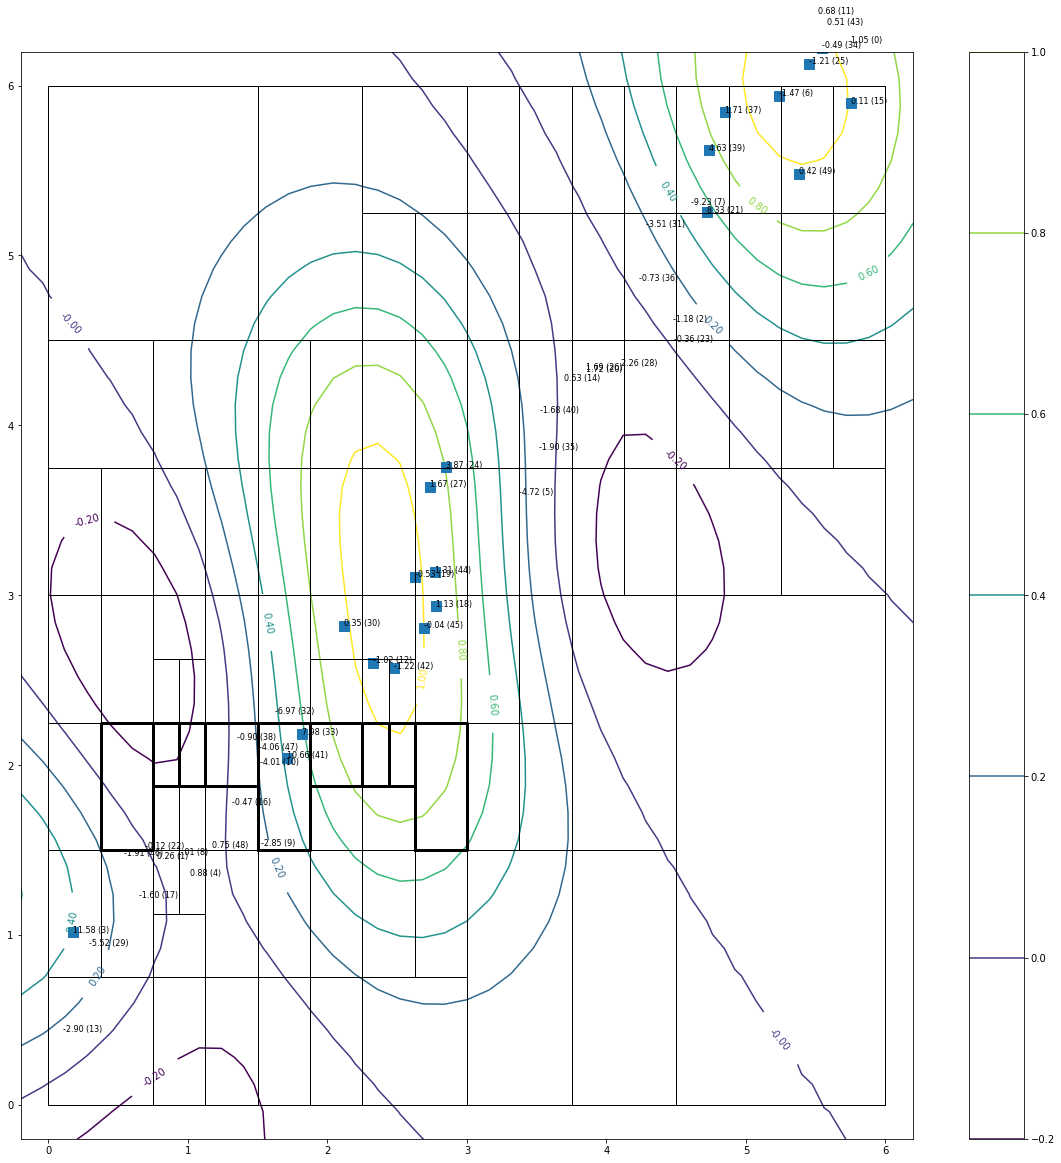

In [43]:
from boundmixofgaussians import zeromean_gaussian_1d, zeromean_gaussian, findbound, PCA

plt.figure(figsize=[20,20])
xs = np.arange(-1,10,0.16)
ys = np.arange(-1,10,0.16)
mg = np.array(np.meshgrid(xs,ys))
grid = np.array([mg[0].flatten(),mg[1].flatten()]).T
vals = np.zeros([len(xs),len(ys)])
for eq,eqw in zip(X,EQweights):
    vals += eqw*zeromean_gaussian(grid-eq,ls,v).reshape(len(xs),len(ys))
CS = plt.contour(xs,ys,vals,levels=np.arange(-20,20,0.2))
plt.clabel(CS, inline=1, fontsize=10,fmt="%1.2f")
plt.colorbar()



#plt.plot(X[EQweights>0,0],X[EQweights>0,1],'s',markersize=10,label='positive')
#plt.plot(X[EQweights<0,0],X[EQweights<0,1],'o',markersize=10,label='negative')

plt.plot(X[Y[:,0]>0,0],X[Y[:,0]>0,1],'s',markersize=10,label='positive')
plt.plot(X[Y[:,0]<0,0],X[Y[:,0]<0,1],'o',markersize=10,label='negative')
for i, (c,w) in enumerate(zip(X,EQweights)):
    plt.text(c[0],c[1],"%0.2f (%d)"%(w,i),fontsize=8)
#plt.legend()

for idx, (hypercube_start, hypercube_end) in enumerate(zip(hypercube_starts,hypercube_ends)):
    if idx in maxseg:
        lw = 3
    else:
        lw = 1
    plt.plot([hypercube_start[0],hypercube_start[0],hypercube_end[0],hypercube_end[0],hypercube_start[0]],[hypercube_start[1],hypercube_end[1],hypercube_end[1],hypercube_start[1],hypercube_start[1]],'k-',lw=lw)
    #if idx>0: plt.text((hypercube_start[0]+hypercube_end[0])/2,(hypercube_start[1]+hypercube_end[1])/2,idx,fontsize=18)

#plt.plot([0,0,5,5,0],[0,5,5,0,0],'k-')
plt.xlim([-.2,6.2])
plt.ylim([-.2,6.2])


Why is the bound for MNIST (below) so poor...originally?

Possible reasons;

 - ignoring negatives during the dimensionality reduction - empirically this seems to cause about doubling of the bound
 - high sensitivity due to the rapid change between points of different classes - long lengthscales & high sigma sort of help, but ruin the scale of the response simultaneously.
 - grid too coarse - fixed, just keep < ls/2
 - not enough slices - ugh, more slices don't help .... why??..actually it does a bit - just not so much for dimension 0 which is a weird one (and unfortunately the one I experimented with most) as it's mostly zero (it's the top corner of the images so mostly just black). Note however that the number of splits needs to scale with ?^d, so with these 9 dimensions, to achieve the same improvement as 10 splits in 2d will require ~31000 splits. NOTE: The splitting code is really inefficient at the moment. Including slow test assertions.
 
**I then set the box-size to the maximum value along each axis (so you can't make a pixel brighter than it is in any image). This seemed to make a massive difference - but I'm not sure at all why... surely for most of the space changing the pixel won't have an effect as there's no data there???**

# MNIST

In [1]:
import numpy as np
np.set_printoptions(suppress=True,precision=6)
import matplotlib.pyplot as plt
%matplotlib inline
from GPAdversarialBound import compute_full_bound

In [3]:
from mnist import MNIST
import numpy as np
#download the mnist data from http://yann.lecun.com/exdb/mnist/
#save in mnistdata folder in same directory as this notebook

def getMNISTexample(scalingfactor=7,Ntraining=500):
    mndata = MNIST('./mnistdata')
    mnist_training = mndata.load_training()

    #B = [np.array([[-10.0,20.0],[-10.0,20.0]])]
    bigX = np.array(mnist_training[0])[np.array(mnist_training[1])<2,:]
    bigXtest = bigX[(Ntraining+1):(Ntraining+10),:]
    bigX = bigX[0:Ntraining,:]
    Y = np.array(mnist_training[1])[np.array(mnist_training[1])<2]
    Y = Y[:,None]*2.0-1.0
    Ytest = Y[(Ntraining+1):(Ntraining+10),:]
    Y = Y[0:Ntraining,:]

    def scale(X,res):
        newX = []
        for x in X:
            newx = np.zeros([1+int(28/res),1+int(28/res)])
            xreshaped = x.reshape(28,28)
            for newi,i in enumerate(np.arange(0,28,res)):
                for newj,j in enumerate(np.arange(0,28,res)):
                    newx[newi,newj] = np.mean(xreshaped[i:(i+res),j:(j+res)])
            newX.append(newx.reshape(newx.size))
        return np.array(newX)

    X = scale(bigX,scalingfactor)
    Xtest = scale(bigXtest,scalingfactor)
    newres = int(X[0,:].size**.5)
    return X,Y,Xtest,Ytest

X,Y,Xtest,Ytest = getMNISTexample(scalingfactor=10,Ntraining=100)

In [4]:
X.shape

(100, 9)

In [133]:
#Here we effectively cause a change in lengthscale in different dimensions
#(really the lengthscale stays the same and we scale everything else)
#we assume that we want the lengthscales proportional to the
#standard deviation of the data
#TODO: not sure if this works properly!
#cubesize = np.full(X.shape[1],255)
#cubesize=cubesize/np.std(X,0)
#X=X/np.std(X,0)

In [134]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25)

principalComponents = pca.fit_transform(X.T)
cov_matrix = np.dot(X, X.T) / X.shape[0]
for eigenvector in pca.components_:
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

58351.765305182766
13147.78060431467
2569.018942734916
1819.1849250553364
816.640634438783
384.61384377888487
312.66637145004177
141.42426614816307
123.28640025004344
96.0853416074176
71.70677761583734
59.02384986452152
46.16728036769199
58.3402867030042
25.93577011837633
20.409905765760833
18.066911589737234
6.734718298059997
2.6169641698794024
0.7865290576589525
1.3802106550755244
0.0010512655379728564
-1.9519271665130572e-14
-1.3072440138535616e-14
-2.1459561433949512e-13


In [139]:
X.shape

(100, 25)

In [146]:
X = X[:,np.max(X,0)>1] ##!!! I should check for this TODO!!

In [6]:
ls = 200.0
v = 1.0
diff_dim = 4
dims = X.shape[1]
cubesize = np.max(X,0)
splitcount = 500
gridres = 10 #1/10th of ls
sigma = 3.0
print(cubesize)

#from GPy optimise...
#v = 0.8248
#ls = 99.02
#sigma = np.sqrt(0.0780508)

allbounds = []
for diff_dim in range(X.shape[1]):
    bounds = []
    #+ve
    bound, hypercube_starts, hypercube_ends, maxseg, EQweights = compute_full_bound(X,Y,sigma,ls,v,diff_dim,dims,cubesize,splitcount=splitcount,gridres=gridres,dimthreshold=3)
    bounds.append(bound)
    #-ve
    bound, hypercube_starts, hypercube_ends, maxseg, EQweights = compute_full_bound(X,-Y,sigma,ls,v,diff_dim,dims,cubesize,splitcount=splitcount,gridres=gridres,dimthreshold=3)
    bounds.append(bound)
    allbounds.append(bounds)

[ 39.04   107.      45.4625  99.23   155.48   111.675   58.7875 120.675
  40.0625]
Splitting...
Computing Paths...
Checking Segments...

0/616[187] [0.011798]

1/616[124] [0.049405]

2/616[456] [0.05098]

3/616[137] [0.011827]

4/616[74] [0.049771]

5/616[422] [0.048231]

6/616[359] [0.049975]

7/616[24] [0.050636]

8/616[309] [0.05049]

9/616[246] [0.05043]

10/616[259] [0.011837]

11/616[196] [0.011504]

12/616[465] [0.038748]

13/616[146] [0.050602]

14/616[83] [0.011671]

15/616[431] [0.050255]

16/616..[171, 327] [0.049053]

17/616[352] [0.050143]

18/616[33] [0.050616]

19/616..[257, 315] [0.04988]

20/616[318] [0.037009]

21/616[255] [0.011514]

22/616[268] [0.050983]

23/616[205] [0.011488]

24/616[474] [0.038163]

25/616[155] [0.011341]

26/616[92] [0.038507]

27/616..[29, 95] [0.04958]

28/616[424] [0.038197]

29/616[361] [0.050304]

30/616[42] [0.011794]

31/616[390] [0.05061]

32/616[327] [0.037529]

33/616[248] [0.037625]

34/616..[273, 453] [0.050338]

35/616[277] [0.0371

334/616[117] [0.011379]

335/616[449] [0.049281]

336/616[130] [0.049994]

337/616[67] [0.049886]

338/616[415] [0.038772]

339/616[336] [0.011928]

340/616[17] [0.051046]

341/616[302] [0.048168]

342/616[239] [0.011603]

343/616[189] [0.038479]

344/616[126] [0.04981]

345/616[458] [0.049777]

346/616..[78, 225] [0.049931]

347/616[139] [0.01179]

348/616..[213, 362] [0.049824]

349/616[76] [0.049483]

350/616[408] [0.038775]

351/616..[161, 286] [0.047492]

352/616[345] [0.049611]

353/616[26] [0.05047]

354/616..[61, 81] [0.049892]

355/616[311] [0.011649]

356/616[232] [0.011683]

357/616[261] [0.048329]

358/616[198] [0.036984]

359/616..[134, 248] [0.049066]

360/616[467] [0.050893]

361/616[148] [0.011984]

362/616[85] [0.048302]

363/616[417] [0.038506]

364/616[354] [0.047531]

365/616..[155, 463] [0.047887]

366/616..[239, 405] [0.049306]

367/616[35] [0.051001]

368/616..[127, 175] [0.050586]

369/616..[163, 287] [0.049666]

370/616[304] [0.03861]

371/616[241] [0.038287]



49/660[433] [0.061346]

50/660..[69, 246] [0.062478]

51/660[370] [0.059118]

52/660[51] [0.044782]

53/660..[114, 331] [0.06185]

54/660[399] [0.063354]

55/660..[248, 478] [0.058799]

56/660[320] [0.063646]

57/660[1] [0.065004]

58/660..[113, 129] [0.06274]

59/660[286] [0.044716]

60/660[223] [0.016691]

61/660..[116, 138] [0.062117]

62/660..[161, 357] [0.059563]

63/660..[26, 74] [0.063211]

64/660[492] [0.061787]

65/660[173] [0.017162]

66/660[110] [0.062803]

67/660[442] [0.045628]

68/660..[239, 408] [0.061779]

69/660[379] [0.017583]

70/660[60] [0.017883]

71/660..[126, 308] [0.062508]

72/660[392] [0.017527]

73/660[329] [0.044613]

74/660..[21, 99] [0.06242]

75/660[10] [0.017256]

76/660..[55, 122] [0.064004]

77/660[295] [0.04398]

78/660..[141, 383] [0.059717]

79/660..[94, 231] [0.062279]

80/660[216] [0.018068]

81/660[501] [0.045491]

82/660[182] [0.016718]

83/660..[199, 474] [0.058224]

84/660[119] [0.018244]

85/660..[159, 307] [0.059655]

86/660..[2, 168] [0.062

375/660[449] [0.042653]

376/660[130] [0.016943]

377/660[67] [0.063425]

378/660..[125, 213] [0.060813]

379/660..[175, 321] [0.062124]

380/660[415] [0.062249]

381/660[336] [0.044637]

382/660[17] [0.017413]

383/660[302] [0.061134]

384/660[239] [0.017434]

385/660[189] [0.017443]

386/660[126] [0.017835]

387/660..[202, 377] [0.061572]

388/660[458] [0.04492]

389/660[139] [0.045015]

390/660[76] [0.018007]

391/660[408] [0.044664]

392/660[345] [0.06154]

393/660[26] [0.018008]

394/660[311] [0.063633]

395/660[232] [0.044897]

396/660[261] [0.061145]

397/660[198] [0.045588]

398/660[467] [0.061945]

399/660[148] [0.044846]

400/660[85] [0.046145]

401/660..[146, 291] [0.062309]

402/660[417] [0.060845]

403/660[354] [0.05996]

404/660[35] [0.060904]

405/660..[153, 294] [0.063869]

406/660..[226, 395] [0.063053]

407/660[304] [0.060927]

408/660..[61, 301] [0.062413]

409/660[241] [0.044599]

410/660..[119, 353] [0.064126]

411/660..[18, 361] [0.061878]

412/660..[235, 466] [0.

29/1231...[381, 491, 15] [0.085492]

30/1231..[243, 269] [0.073742]

31/1231..[344, 12] [0.041374]

32/1231[146] [0.062446]

33/1231..[369, 397] [0.068603]

34/1231...[398, 466, 16] [0.077011]

35/1231[83] [0.015663]

36/1231[465] [0.061668]

37/1231..[495, 14] [0.049502]

38/1231[431] [0.073009]

39/1231[352] [0.015274]

40/1231..[57, 81] [0.080073]

41/1231[33] [0.063839]

42/1231..[412, 16] [0.084854]

43/1231..[35, 65] [0.07695]

44/1231..[6, 362] [0.076219]

45/1231[318] [0.060337]

46/1231[255] [0.014658]

47/1231...[168, 222, 10] [0.084414]

48/1231..[472, 13] [0.050859]

49/1231..[143, 7] [0.050259]

50/1231..[169, 228] [0.07139]

51/1231..[225, 7] [0.052309]

52/1231[268] [0.05777]

53/1231...[332, 478, 13] [0.095019]

54/1231[205] [0.054746]

55/1231...[297, 320, 13] [0.094465]

56/1231...[78, 96, 12] [0.084577]

57/1231[474] [0.059974]

58/1231..[266, 5] [0.052445]

59/1231[155] [0.063148]

60/1231[92] [0.059857]

61/1231[424] [0.016188]

62/1231...[192, 262, 16] [0.083894]


301/1231[170] [0.015056]

302/1231...[274, 323, 5] [0.095631]

303/1231[107] [0.062752]

304/1231..[376, 13] [0.052565]

305/1231...[62, 83, 12] [0.090051]

306/1231..[146, 223] [0.0787]

307/1231..[451, 16] [0.043055]

308/1231[455] [0.01566]

309/1231[376] [0.01629]

310/1231...[216, 419, 15] [0.092435]

311/1231[57] [0.063586]

312/1231[405] [0.014909]

313/1231[342] [0.052339]

314/1231..[379, 14] [0.048887]

315/1231[23] [0.062776]

316/1231..[328, 374] [0.069709]

317/1231...[132, 245, 15] [0.088768]

318/1231..[61, 10] [0.045583]

319/1231..[196, 16] [0.047495]

320/1231[292] [0.059652]

321/1231..[139, 279] [0.075103]

322/1231[229] [0.061486]

323/1231...[140, 198, 7] [0.092909]

324/1231...[350, 387, 14] [0.088414]

325/1231..[244, 435] [0.073958]

326/1231[498] [0.01399]

327/1231..[311, 13] [0.052491]

328/1231[179] [0.062008]

329/1231..[432, 13] [0.052235]

330/1231..[112, 167] [0.07938]

331/1231[116] [0.058987]

332/1231..[229, 424] [0.077534]

333/1231..[261, 451] [0.0

597/1231..[298, 301] [0.075036]

598/1231..[277, 322] [0.074083]

599/1231..[221, 256] [0.068804]

600/1231...[247, 276, 12] [0.080411]

601/1231[266] [0.016299]

602/1231[203] [0.015745]

603/1231...[45, 296, 7] [0.09502]

604/1231[472] [0.015645]

605/1231..[189, 410] [0.074294]

606/1231...[194, 240, 16] [0.088891]

607/1231[153] [0.016121]

608/1231...[189, 410, 15] [0.090018]

609/1231...[464, 475, 16] [0.075089]

610/1231[90] [0.055701]

611/1231...[375, 489, 13] [0.094504]

612/1231[438] [0.014755]

613/1231[375] [0.060418]

614/1231[40] [0.060348]

615/1231..[408, 16] [0.085578]

616/1231[388] [0.015511]

617/1231[325] [0.015191]

618/1231..[161, 403] [0.077324]

619/1231..[148, 201] [0.079182]

620/1231[6] [0.060424]

621/1231...[346, 480, 13] [0.088529]

622/1231[275] [0.016468]

623/1231..[105, 108] [0.080098]

624/1231[212] [0.059215]

625/1231...[421, 445, 13] [0.091428]

626/1231..[388, 7] [0.051135]

627/1231...[174, 238, 5] [0.097144]

628/1231..[460, 14] [0.098941]

62

869/1231[349] [0.055518]

870/1231[30] [0.062645]

871/1231[299] [0.05867]

872/1231[236] [0.05755]

873/1231...[369, 397, 15] [0.082328]

874/1231..[109, 10] [0.045915]

875/1231[186] [0.058409]

876/1231..[173, 12] [0.046456]

877/1231..[324, 476] [0.070118]

878/1231[123] [0.063831]

879/1231..[2, 31] [0.07909]

880/1231[471] [0.015778]

881/1231..[50, 5] [0.051214]

882/1231[136] [0.016009]

883/1231..[480, 13] [0.049061]

884/1231..[493, 14] [0.096413]

885/1231[73] [0.01634]

886/1231..[204, 248] [0.068632]

887/1231[421] [0.057927]

888/1231[358] [0.016074]

889/1231[39] [0.060329]

890/1231..[482, 15] [0.047903]

891/1231..[98, 101] [0.07873]

892/1231[308] [0.061456]

893/1231..[153, 10] [0.049159]

894/1231..[177, 5] [0.051547]

895/1231[245] [0.015524]

896/1231...[91, 121, 10] [0.090996]

897/1231...[366, 486, 16] [0.083801]

898/1231[258] [0.014941]

899/1231[195] [0.057837]

900/1231..[103, 153] [0.077379]

901/1231...[149, 225, 7] [0.096076]

902/1231..[92, 130] [0.07548

1153/1231[97] [0.063371]

1154/1231..[440, 7] [0.050548]

1155/1231...[361, 484, 14] [0.092079]

1156/1231...[110, 166, 12] [0.088525]

1157/1231[445] [0.015343]

1158/1231[382] [0.015151]

1159/1231..[307, 5] [0.05222]

1160/1231[63] [0.01581]

1161/1231..[329, 477] [0.068537]

1162/1231...[88, 187, 10] [0.088149]

1163/1231[395] [0.015746]

1164/1231..[39, 63] [0.076005]

1165/1231..[361, 484] [0.073812]

1166/1231..[184, 12] [0.046827]

1167/1231...[294, 356, 7] [0.092916]

1168/1231[332] [0.060879]

1169/1231[13] [0.048362]

1170/1231..[151, 7] [0.052381]

1171/1231..[122, 12] [0.047111]

1172/1231..[337, 388] [0.073979]

1173/1231...[97, 115, 5] [0.096759]

1174/1231[282] [0.058414]

1175/1231..[17, 104] [0.078245]

1176/1231[219] [0.053479]

1177/1231...[193, 317, 16] [0.087468]

1178/1231...[348, 352, 14] [0.08981]

1179/1231...[368, 371, 15] [0.083956]

1180/1231...[124, 188, 5] [0.097253]

1181/1231[488] [0.014115]

1182/1231...[32, 58, 5] [0.096967]

1183/1231[169] [0.056612]

207/1236[87] [0.132667]

208/1236...[306, 320, 14] [0.406945]

209/1236..[42, 429] [0.203587]

210/1236..[289, 14] [0.28962]

211/1236[419] [0.123032]

212/1236[356] [0.129432]

213/1236[37] [0.091203]

214/1236..[45, 7] [0.2872]

215/1236..[291, 16] [0.280437]

216/1236[306] [0.132708]

217/1236...[62, 192, 7] [0.400398]

218/1236..[69, 189] [0.223071]

219/1236[243] [0.090375]

220/1236..[245, 370] [0.223319]

221/1236..[64, 193] [0.216394]

222/1236..[429, 11] [0.257234]

223/1236...[460, 500, 14] [0.399289]

224/1236[256] [0.132714]

225/1236...[43, 61, 13] [0.40239]

226/1236...[380, 464, 12] [0.373116]

227/1236..[31, 82] [0.219492]

228/1236[193] [0.089235]

229/1236...[156, 269, 15] [0.380656]

230/1236..[465, 11] [0.25157]

231/1236...[49, 204, 11] [0.38091]

232/1236[478] [0.078884]

233/1236[159] [0.087952]

234/1236...[295, 300, 9] [0.407297]

235/1236..[221, 12] [0.280405]

236/1236[80] [0.090332]

237/1236..[466, 16] [0.284609]

238/1236[428] [0.122352]

239/1236[365] [0.

480/1236..[98, 110] [0.222465]

481/1236[280] [0.132436]

482/1236...[32, 35, 7] [0.404721]

483/1236..[131, 14] [0.282413]

484/1236[217] [0.132725]

485/1236...[298, 313, 14] [0.405448]

486/1236..[391, 15] [0.244024]

487/1236[183] [0.090903]

488/1236..[54, 187] [0.213853]

489/1236..[87, 203] [0.223286]

490/1236[104] [0.089798]

491/1236..[75, 86] [0.213006]

492/1236..[38, 94] [0.21402]

493/1236[452] [0.092115]

494/1236[133] [0.124064]

495/1236[70] [0.12955]

496/1236...[167, 173, 12] [0.394577]

497/1236..[144, 153] [0.212132]

498/1236..[35, 7] [0.288663]

499/1236[402] [0.092123]

500/1236[339] [0.130181]

501/1236[20] [0.132483]

502/1236...[322, 438, 12] [0.400629]

503/1236..[5, 229] [0.223256]

504/1236[289] [0.092102]

505/1236..[232, 12] [0.28362]

506/1236...[74, 363, 15] [0.36656]

507/1236[226] [0.091774]

508/1236...[30, 484, 9] [0.407289]

509/1236..[444, 9] [0.289699]

510/1236[176] [0.127591]

511/1236[113] [0.087494]

512/1236...[428, 485, 16] [0.368845]

513

769/1236...[176, 290, 16] [0.384426]

770/1236[53] [0.130377]

771/1236...[207, 212, 7] [0.403321]

772/1236...[244, 357, 9] [0.407275]

773/1236..[309, 436] [0.222973]

774/1236[385] [0.092118]

775/1236...[309, 436, 14] [0.401889]

776/1236..[396, 13] [0.278903]

777/1236..[319, 324] [0.220271]

778/1236[322] [0.131407]

779/1236..[338, 365] [0.198312]

780/1236[3] [0.132725]

781/1236..[191, 335] [0.223062]

782/1236..[275, 14] [0.283187]

783/1236..[210, 7] [0.290416]

784/1236..[321, 453] [0.202319]

785/1236..[384, 11] [0.243055]

786/1236...[199, 348, 7] [0.405395]

787/1236[272] [0.132365]

788/1236..[187, 11] [0.272852]

789/1236[209] [0.131703]

790/1236..[274, 9] [0.286755]

791/1236..[400, 409] [0.204768]

792/1236[494] [0.091994]

793/1236...[126, 239, 14] [0.405792]

794/1236[175] [0.129883]

795/1236[96] [0.127581]

796/1236..[70, 104] [0.218033]

797/1236...[79, 113, 15] [0.379801]

798/1236..[485, 16] [0.260964]

799/1236[444] [0.092138]

800/1236..[454, 459] [0.223316

1046/1236..[344, 355] [0.203576]

1047/1236[459] [0.092105]

1048/1236...[373, 476, 15] [0.359084]

1049/1236..[223, 354] [0.223415]

1050/1236[140] [0.086196]

1051/1236...[400, 409, 12] [0.366115]

1052/1236..[363, 15] [0.259269]

1053/1236[77] [0.129386]

1054/1236..[424, 16] [0.266048]

1055/1236..[499, 12] [0.393355]

1056/1236[409] [0.084468]

1057/1236..[501, 14] [0.288671]

1058/1236[346] [0.118627]

1059/1236..[367, 13] [0.281517]

1060/1236[27] [0.131847]

1061/1236...[441, 444, 9] [0.407262]

1062/1236..[380, 464] [0.208268]

1063/1236...[200, 318, 7] [0.407222]

1064/1236..[81, 11] [0.278189]

1065/1236[296] [0.132616]

1066/1236..[355, 11] [0.257262]

1067/1236[233] [0.090575]

1068/1236..[43, 61] [0.221928]

1069/1236..[36, 183] [0.220769]

1070/1236...[411, 421, 12] [0.373226]

1071/1236...[175, 291, 16] [0.394857]

1072/1236[262] [0.132715]

1073/1236..[220, 13] [0.277744]

1074/1236[199] [0.13214]

1075/1236[120] [0.125329]

1076/1236[468] [0.087229]

1077/1236..[46, 1

91/639..[417, 449] [0.042645]

92/639[410] [0.036901]

93/639[347] [0.044819]

94/639[28] [0.007587]

95/639..[103, 204] [0.043306]

96/639[297] [0.042918]

97/639[234] [0.042161]

98/639[263] [0.035339]

99/639..[380, 391] [0.044435]

100/639[184] [0.036436]

101/639[121] [0.007585]

102/639..[394, 415] [0.043613]

103/639[469] [0.041371]

104/639[150] [0.044405]

105/639[87] [0.036587]

106/639[419] [0.007871]

107/639..[72, 362] [0.043545]

108/639[356] [0.043812]

109/639[37] [0.007618]

110/639[306] [0.034984]

111/639[243] [0.035567]

112/639[256] [0.045194]

113/639..[86, 173] [0.042662]

114/639[193] [0.034751]

115/639[478] [0.034564]

116/639[159] [0.00785]

117/639[80] [0.007369]

118/639[428] [0.044817]

119/639[365] [0.034432]

120/639[46] [0.045223]

121/639[315] [0.045192]

122/639[252] [0.034651]

123/639..[288, 306] [0.041949]

124/639..[20, 171] [0.043513]

125/639[265] [0.036118]

126/639[202] [0.007329]

127/639[487] [0.034136]

128/639[152] [0.042171]

129/639[89] 

426/639[444] [0.036791]

427/639[381] [0.04491]

428/639[62] [0.007849]

429/639[394] [0.007753]

430/639[331] [0.045029]

431/639[12] [0.043955]

432/639[281] [0.045022]

433/639[218] [0.043968]

434/639..[24, 29] [0.043886]

435/639[168] [0.007749]

436/639[105] [0.007476]

437/639[453] [0.043277]

438/639[134] [0.044465]

439/639..[88, 460] [0.042982]

440/639[71] [0.007726]

441/639[403] [0.036284]

442/639[340] [0.041526]

443/639[21] [0.045192]

444/639[290] [0.042571]

445/639[227] [0.043593]

446/639[496] [0.04234]

447/639[177] [0.036429]

448/639..[219, 229] [0.044181]

449/639[114] [0.042498]

450/639[462] [0.034838]

451/639[143] [0.036545]

452/639[64] [0.007832]

453/639..[327, 335] [0.043992]

454/639[412] [0.036172]

455/639..[15, 116] [0.043941]

456/639..[308, 482] [0.041073]

457/639[349] [0.036594]

458/639[30] [0.007446]

459/639..[92, 161] [0.041888]

460/639[299] [0.007469]

461/639[236] [0.041804]

462/639..[36, 318] [0.043419]

463/639[186] [0.007626]

464/639[

112/675..[202, 298] [0.081409]

113/675..[246, 497] [0.079449]

114/675[419] [0.061577]

115/675[356] [0.060061]

116/675[37] [0.030461]

117/675..[105, 383] [0.085555]

118/675[306] [0.059727]

119/675..[144, 344] [0.081582]

120/675[243] [0.079575]

121/675[256] [0.030105]

122/675[193] [0.05972]

123/675[478] [0.055959]

124/675..[155, 208] [0.084934]

125/675[159] [0.030575]

126/675[80] [0.030626]

127/675[428] [0.059151]

128/675[365] [0.07908]

129/675..[222, 327] [0.086261]

130/675[46] [0.030749]

131/675[315] [0.089134]

132/675[252] [0.061381]

133/675[265] [0.060541]

134/675[202] [0.028109]

135/675..[139, 469] [0.084947]

136/675[487] [0.089266]

137/675[152] [0.029615]

138/675[89] [0.030454]

139/675[437] [0.08749]

140/675[374] [0.080554]

141/675..[35, 54] [0.090221]

142/675[55] [0.057735]

143/675[387] [0.09029]

144/675[324] [0.030741]

145/675[5] [0.091648]

146/675[274] [0.059793]

147/675[211] [0.029583]

148/675..[272, 336] [0.087088]

149/675[480] [0.082368]



447/675[105] [0.02953]

448/675..[68, 218] [0.08274]

449/675[453] [0.088546]

450/675[134] [0.057067]

451/675..[91, 363] [0.086204]

452/675[71] [0.088591]

453/675[403] [0.056954]

454/675[340] [0.030013]

455/675..[20, 55] [0.085477]

456/675[21] [0.030648]

457/675[290] [0.060266]

458/675[227] [0.058364]

459/675..[36, 251] [0.083569]

460/675[496] [0.09128]

461/675[177] [0.056985]

462/675..[22, 134] [0.084613]

463/675..[89, 162] [0.089552]

464/675[114] [0.029757]

465/675[462] [0.084656]

466/675..[76, 104] [0.088218]

467/675[143] [0.02938]

468/675[64] [0.060006]

469/675[412] [0.060128]

470/675[349] [0.029573]

471/675[30] [0.091253]

472/675[299] [0.057893]

473/675[236] [0.058996]

474/675[186] [0.061153]

475/675[123] [0.057746]

476/675..[23, 252] [0.090654]

477/675[471] [0.090759]

478/675[136] [0.058723]

479/675[73] [0.029844]

480/675[421] [0.080688]

481/675[358] [0.053836]

482/675..[194, 290] [0.089655]

483/675[39] [0.029962]

484/675[308] [0.059083]

485/67

97/1172[214] [0.093603]

98/1172[483] [0.059013]

99/1172..[270, 359] [0.098154]

100/1172..[18, 81] [0.035675]

101/1172[164] [0.027121]

102/1172..[5, 494] [0.096139]

103/1172[101] [0.067631]

104/1172..[18, 381] [0.099436]

105/1172[433] [0.029083]

106/1172[370] [0.029598]

107/1172..[3, 17] [0.102588]

108/1172[51] [0.028903]

109/1172..[36, 414] [0.08807]

110/1172...[2, 485, 487] [0.101379]

111/1172..[21, 167] [0.095401]

112/1172[399] [0.097787]

113/1172...[18, 88, 396] [0.098895]

114/1172[320] [0.029868]

115/1172..[349, 413] [0.097602]

116/1172[1] [0.009182]

117/1172..[9, 40] [0.035292]

118/1172[286] [0.065878]

119/1172[223] [0.098735]

120/1172...[21, 111, 254] [0.095526]

121/1172...[5, 279, 280] [0.097965]

122/1172..[112, 154] [0.095374]

123/1172...[12, 77, 133] [0.100927]

124/1172[492] [0.067248]

125/1172[173] [0.028951]

126/1172[110] [0.029289]

127/1172..[15, 108] [0.03553]

128/1172[442] [0.068526]

129/1172[379] [0.026628]

130/1172[60] [0.028963]

131/11

386/1172[319] [0.029487]

387/1172..[50, 80] [0.096402]

388/1172...[11, 266, 267] [0.102563]

389/1172[240] [0.029809]

390/1172[269] [0.062382]

391/1172..[21, 236] [0.094277]

392/1172[206] [0.068069]

393/1172..[3, 197] [0.10209]

394/1172..[6, 306] [0.036493]

395/1172[475] [0.091867]

396/1172[156] [0.063656]

397/1172..[12, 13] [0.102654]

398/1172..[1, 429] [0.037389]

399/1172[93] [0.028581]

400/1172...[12, 45, 86] [0.102186]

401/1172[425] [0.068869]

402/1172..[2, 426] [0.03699]

403/1172[362] [0.029748]

404/1172..[182, 242] [0.093599]

405/1172[43] [0.028581]

406/1172..[47, 71] [0.092138]

407/1172..[59, 101] [0.096652]

408/1172[391] [0.095182]

409/1172[312] [0.068686]

410/1172[249] [0.028958]

411/1172..[9, 65] [0.034805]

412/1172[278] [0.064731]

413/1172[215] [0.064814]

414/1172[484] [0.095579]

415/1172...[15, 348, 410] [0.098508]

416/1172[165] [0.065885]

417/1172..[9, 43] [0.035823]

418/1172...[15, 304, 403] [0.099862]

419/1172[102] [0.028101]

420/1172...[

670/1172[336] [0.065355]

671/1172..[4, 310] [0.036375]

672/1172[17] [0.098701]

673/1172..[176, 244] [0.094378]

674/1172...[3, 78, 353] [0.102566]

675/1172..[15, 16] [0.036681]

676/1172[302] [0.029744]

677/1172[239] [0.066011]

678/1172..[15, 155] [0.035557]

679/1172...[9, 164, 225] [0.092958]

680/1172..[5, 106] [0.09983]

681/1172..[150, 151] [0.09833]

682/1172..[24, 145] [0.036484]

683/1172[189] [0.067153]

684/1172..[15, 62] [0.036073]

685/1172..[21, 87] [0.093633]

686/1172[126] [0.028969]

687/1172..[316, 360] [0.097928]

688/1172..[27, 176] [0.035968]

689/1172[458] [0.068595]

690/1172..[12, 113] [0.036918]

691/1172[139] [0.029621]

692/1172[76] [0.029818]

693/1172..[2, 162] [0.100834]

694/1172[408] [0.068602]

695/1172[345] [0.068884]

696/1172..[1, 351] [0.102591]

697/1172...[8, 249, 250] [0.099273]

698/1172[26] [0.098702]

699/1172...[9, 407, 483] [0.08867]

700/1172...[15, 344, 402] [0.099236]

701/1172[311] [0.067597]

702/1172[232] [0.067164]

703/1172..[12

947/1172[441] [0.068375]

948/1172[378] [0.098708]

949/1172...[2, 231, 232] [0.100459]

950/1172..[6, 39] [0.036379]

951/1172[59] [0.029227]

952/1172[407] [0.025975]

953/1172..[12, 327] [0.037177]

954/1172[328] [0.068592]

955/1172[9] [0.008905]

956/1172...[15, 315, 356] [0.099217]

957/1172..[320, 389] [0.09853]

958/1172[294] [0.029489]

959/1172...[9, 43, 52] [0.097882]

960/1172..[12, 349] [0.037163]

961/1172[231] [0.029284]

962/1172..[5, 220] [0.036097]

963/1172..[281, 489] [0.098187]

964/1172[500] [0.06882]

965/1172..[397, 438] [0.089979]

966/1172..[9, 461] [0.090001]

967/1172[181] [0.0952]

968/1172[118] [0.06695]

969/1172..[24, 444] [0.098954]

970/1172..[5, 230] [0.09918]

971/1172[450] [0.068862]

972/1172..[11, 31] [0.102601]

973/1172..[27, 153] [0.097408]

974/1172[131] [0.028402]

975/1172..[3, 117] [0.037327]

976/1172[68] [0.065376]

977/1172[400] [0.068749]

978/1172[337] [0.029141]

979/1172[18] [0.008854]

980/1172[303] [0.068596]

981/1172...[5, 313, 3

62/1182..[80, 146] [0.288253]

63/1182..[463, 464] [0.276641]

64/1182[277] [0.126811]

65/1182...[2, 119, 120] [0.46155]

66/1182..[5, 452] [0.303191]

67/1182[214] [0.145783]

68/1182..[29, 478] [0.437931]

69/1182..[3, 343] [0.481123]

70/1182..[23, 477] [0.439197]

71/1182[483] [0.153045]

72/1182...[10, 64, 136] [0.454859]

73/1182..[10, 114] [0.305463]

74/1182[164] [0.124391]

75/1182[101] [0.125912]

76/1182[433] [0.273793]

77/1182[370] [0.123721]

78/1182...[6, 276, 389] [0.47622]

79/1182..[64, 136] [0.277269]

80/1182[51] [0.127995]

81/1182..[10, 92] [0.308842]

82/1182...[6, 124, 254] [0.455325]

83/1182[399] [0.159185]

84/1182[320] [0.148794]

85/1182..[6, 391] [0.485079]

86/1182[1] [0.207027]

87/1182...[17, 361, 493] [0.422286]

88/1182..[1, 219] [0.331576]

89/1182[286] [0.145711]

90/1182...[21, 381, 388] [0.457018]

91/1182[223] [0.261007]

92/1182..[4, 397] [0.489582]

93/1182...[5, 215, 216] [0.441879]

94/1182..[6, 205] [0.322954]

95/1182...[6, 8, 285] [0.477]

340/1182..[31, 484] [0.256482]

341/1182...[1, 97, 98] [0.470546]

342/1182[260] [0.106212]

343/1182[197] [0.118913]

344/1182..[5, 148] [0.309216]

345/1182..[17, 246] [0.418676]

346/1182[466] [0.121547]

347/1182..[381, 388] [0.2729]

348/1182[147] [0.161456]

349/1182..[304, 306] [0.285921]

350/1182[84] [0.126145]

351/1182[416] [0.126464]

352/1182..[25, 497] [0.459403]

353/1182[353] [0.162317]

354/1182..[60, 170] [0.291796]

355/1182[34] [0.125215]

356/1182...[1, 128, 129] [0.474047]

357/1182..[2, 74] [0.319372]

358/1182[319] [0.270885]

359/1182[240] [0.115696]

360/1182...[6, 53, 123] [0.464903]

361/1182...[10, 114, 239] [0.436108]

362/1182[269] [0.129343]

363/1182[206] [0.114274]

364/1182...[1, 226, 403] [0.475333]

365/1182..[65, 66] [0.290925]

366/1182..[303, 305] [0.257652]

367/1182..[12, 168] [0.31676]

368/1182[475] [0.252937]

369/1182[156] [0.115176]

370/1182[93] [0.109786]

371/1182..[4, 463] [0.324565]

372/1182..[17, 94] [0.29968]

373/1182..[7, 487] [0

642/1182..[5, 227] [0.29823]

643/1182..[6, 243] [0.33119]

644/1182[239] [0.146474]

645/1182...[5, 235, 236] [0.417059]

646/1182..[110, 234] [0.258682]

647/1182..[4, 348] [0.329937]

648/1182..[7, 378] [0.32114]

649/1182[189] [0.151537]

650/1182..[17, 96] [0.305598]

651/1182[126] [0.155122]

652/1182[458] [0.14616]

653/1182[139] [0.157769]

654/1182..[1, 60] [0.331475]

655/1182[76] [0.12128]

656/1182..[247, 333] [0.243486]

657/1182[408] [0.266943]

658/1182..[6, 368] [0.488245]

659/1182[345] [0.279544]

660/1182..[93, 262] [0.247414]

661/1182[26] [0.121891]

662/1182..[10, 171] [0.302011]

663/1182..[2, 220] [0.301491]

664/1182..[133, 208] [0.283144]

665/1182..[356, 358] [0.263795]

666/1182..[160, 217] [0.267167]

667/1182...[6, 51, 73] [0.472187]

668/1182[311] [0.150946]

669/1182[232] [0.144199]

670/1182..[12, 377] [0.460981]

671/1182..[25, 492] [0.461658]

672/1182[261] [0.125649]

673/1182..[5, 431] [0.4595]

674/1182..[6, 55] [0.325047]

675/1182[198] [0.15312]


923/1182...[7, 437, 438] [0.448342]

924/1182...[10, 206, 282] [0.422024]

925/1182[398] [0.127036]

926/1182..[29, 475] [0.440187]

927/1182[335] [0.276095]

928/1182...[14, 440, 441] [0.442375]

929/1182..[3, 451] [0.477232]

930/1182..[193, 311] [0.269918]

931/1182...[10, 135, 273] [0.446665]

932/1182[285] [0.161712]

933/1182[222] [0.153763]

934/1182...[1, 65, 66] [0.475125]

935/1182...[6, 205, 372] [0.460778]

936/1182..[3, 18] [0.331653]

937/1182..[1, 38] [0.330402]

938/1182...[12, 317, 446] [0.465519]

939/1182[491] [0.245267]

940/1182[172] [0.14669]

941/1182...[2, 303, 305] [0.422188]

942/1182[109] [0.122503]

943/1182..[49, 155] [0.284291]

944/1182..[199, 200] [0.267007]

945/1182[441] [0.147883]

946/1182[378] [0.124505]

947/1182...[2, 231, 232] [0.422342]

948/1182[59] [0.129226]

949/1182[407] [0.270249]

950/1182...[12, 185, 325] [0.443481]

951/1182..[21, 412] [0.481793]

952/1182[328] [0.289998]

953/1182..[248, 336] [0.284513]

954/1182..[6, 277] [0.330704]



34/2041[483] [0.203384]

35/2041...[60, 6, 212] [0.326497]

36/2041....[53, 62, 12, 452] [0.550986]

37/2041..[8, 94] [0.337961]

38/2041[101] [0.089105]

39/2041...[52, 9, 335] [0.321637]

40/2041....[42, 52, 9, 152] [0.457709]

41/2041....[52, 9, 164, 299] [0.408234]

42/2041...[52, 9, 72] [0.321141]

43/2041.....[42, 52, 9, 93, 173] [0.525334]

44/2041[320] [0.114198]

45/2041..[105, 117] [0.205467]

46/2041..[214, 250] [0.205778]

47/2041....[64, 7, 162, 297] [0.404605]

48/2041.....[58, 64, 7, 183, 324] [0.509598]

49/2041....[37, 46, 8, 247] [0.466352]

50/2041..[7, 156] [0.217359]

51/2041[173] [0.113447]

52/2041...[48, 15, 106] [0.331507]

53/2041..[25, 402] [0.334073]

54/2041[392] [0.205327]

55/2041[10] [0.135462]

56/2041[501] [0.207427]

57/2041..[13, 407] [0.224471]

58/2041....[42, 52, 9, 121] [0.459331]

59/2041.....[58, 64, 7, 65, 425] [0.502432]

60/2041[119] [0.111532]

61/2041.....[53, 62, 12, 83, 237] [0.519794]

62/2041....[46, 8, 136, 205] [0.417436]

63/2041...

292/2041[232] [0.091106]

293/2041.....[49, 55, 10, 200, 318] [0.530334]

294/2041....[58, 64, 7, 440] [0.528213]

295/2041..[146, 265] [0.206434]

296/2041....[53, 62, 12, 234] [0.454785]

297/2041[467] [0.114021]

298/2041....[57, 63, 25, 31] [0.575382]

299/2041..[8, 143] [0.223154]

300/2041[85] [0.091314]

301/2041..[7, 371] [0.325343]

302/2041..[264, 488] [0.201432]

303/2041[304] [0.205772]

304/2041....[58, 64, 7, 416] [0.537568]

305/2041....[49, 55, 10, 485] [0.567748]

306/2041..[110, 215] [0.205333]

307/2041....[28, 48, 15, 251] [0.467918]

308/2041..[27, 340] [0.338746]

309/2041[157] [0.090774]

310/2041...[60, 6, 116] [0.437188]

311/2041..[271, 417] [0.20626]

312/2041...[52, 9, 239] [0.326086]

313/2041....[58, 64, 7, 217] [0.443408]

314/2041..[11, 82] [0.203212]

315/2041..[12, 92] [0.220086]

316/2041...[64, 7, 177] [0.314267]

317/2041..[13, 501] [0.33848]

318/2041....[60, 6, 110, 215] [0.414768]

319/2041[250] [0.113632]

320/2041...[60, 6, 448] [0.432776]

321

533/2041...[7, 65, 425] [0.322406]

534/2041....[53, 62, 12, 112] [0.555518]

535/2041..[9, 123] [0.33312]

536/2041[33] [0.207524]

537/2041..[12, 224] [0.220924]

538/2041...[62, 12, 348] [0.427951]

539/2041....[37, 46, 8, 201] [0.468144]

540/2041[268] [0.206647]

541/2041...[41, 50, 27] [0.449748]

542/2041....[64, 7, 84, 211] [0.399561]

543/2041....[42, 52, 9, 391] [0.556773]

544/2041....[60, 6, 168, 194] [0.413007]

545/2041....[60, 6, 261, 478] [0.411326]

546/2041[361] [0.203677]

547/2041..[7, 189] [0.21397]

548/2041...[30, 13, 407] [0.333168]

549/2041[214] [0.09218]

550/2041..[7, 263] [0.325415]

551/2041...[64, 7, 389] [0.414297]

552/2041..[66, 119] [0.20214]

553/2041[433] [0.204579]

554/2041[51] [0.192397]

555/2041...[64, 7, 342] [0.418793]

556/2041[286] [0.112999]

557/2041....[64, 7, 101, 458] [0.399105]

558/2041...[8, 136, 205] [0.33249]

559/2041[379] [0.112764]

560/2041..[27, 424] [0.336769]

561/2041....[58, 64, 7, 342] [0.533607]

562/2041[216] [0.112811

785/2041....[58, 64, 7, 66] [0.445474]

786/2041....[42, 52, 9, 90] [0.460076]

787/2041....[53, 62, 12, 228] [0.448333]

788/2041.....[56, 60, 6, 269, 464] [0.517738]

789/2041....[28, 48, 15, 296] [0.461223]

790/2041....[42, 52, 9, 137] [0.552089]

791/2041[198] [0.090903]

792/2041..[9, 152] [0.221248]

793/2041[417] [0.11383]

794/2041[35] [0.193453]

795/2041....[42, 52, 9, 275] [0.446197]

796/2041..[12, 18] [0.338776]

797/2041...[48, 15, 251] [0.330448]

798/2041[270] [0.112392]

799/2041...[62, 12, 353] [0.432816]

800/2041..[15, 180] [0.223981]

801/2041[363] [0.206027]

802/2041....[56, 60, 6, 269] [0.453386]

803/2041..[9, 129] [0.221799]

804/2041.....[58, 64, 7, 177, 317] [0.500344]

805/2041[200] [0.092575]

806/2041...[24, 30, 13] [0.454892]

807/2041[435] [0.111882]

808/2041....[64, 7, 118, 210] [0.406478]

809/2041.....[58, 64, 7, 207, 369] [0.498081]

810/2041[53] [0.18418]

811/2041....[56, 60, 6, 116] [0.565717]

812/2041.....[37, 46, 8, 272, 467] [0.53224]

813/

1055/2041[1] [0.204863]

1056/2041....[42, 52, 9, 93] [0.46163]

1057/2041...[7, 199, 388] [0.320507]

1058/2041....[42, 52, 9, 140] [0.455944]

1059/2041..[72, 167] [0.202555]

1060/2041[492] [0.206652]

1061/2041.....[56, 60, 6, 108, 161] [0.522399]

1062/2041[110] [0.092053]

1063/2041....[24, 30, 13, 248] [0.477803]

1064/2041.....[37, 46, 8, 214, 250] [0.529325]

1065/2041...[52, 9, 308] [0.428557]

1066/2041[329] [0.206843]

1067/2041....[28, 48, 15, 244] [0.467797]

1068/2041....[42, 52, 9, 69] [0.573183]

1069/2041..[8, 339] [0.335355]

1070/2041..[8, 232] [0.219581]

1071/2041..[7, 80] [0.219529]

1072/2041..[48, 15] [0.26631]

1073/2041...[12, 83, 237] [0.329828]

1074/2041..[12, 426] [0.332743]

1075/2041[182] [0.114241]

1076/2041..[9, 436] [0.330554]

1077/2041..[7, 282] [0.324152]

1078/2041....[49, 55, 10, 500] [0.565682]

1079/2041[401] [0.114063]

1080/2041[19] [0.201727]

1081/2041....[60, 6, 105, 117] [0.415086]

1082/2041....[49, 55, 10, 126] [0.581932]

1083/2041..

1314/2041[476] [0.203435]

1315/2041..[6, 159] [0.221606]

1316/2041[94] [0.20723]

1317/2041[313] [0.204084]

1318/2041...[12, 254, 442] [0.327925]

1319/2041...[64, 7, 107] [0.309259]

1320/2041.....[57, 63, 25, 332, 405] [0.522598]

1321/2041..[7, 453] [0.323263]

1322/2041...[12, 224, 430] [0.329461]

1323/2041[166] [0.11109]

1324/2041....[57, 63, 25, 360] [0.563135]

1325/2041[385] [0.207512]

1326/2041[3] [0.135467]

1327/2041....[49, 55, 10, 139] [0.577248]

1328/2041...[15, 175, 334] [0.333808]

1329/2041..[260, 451] [0.20492]

1330/2041..[7, 284] [0.215967]

1331/2041..[9, 69] [0.335948]

1332/2041..[7, 235] [0.216169]

1333/2041....[28, 48, 15, 96] [0.586935]

1334/2041....[56, 60, 6, 181] [0.450723]

1335/2041[494] [0.111738]

1336/2041...[15, 160, 255] [0.333537]

1337/2041....[64, 7, 133, 236] [0.408471]

1338/2041....[60, 6, 289, 494] [0.407438]

1339/2041[96] [0.207606]

1340/2041....[53, 62, 12, 190] [0.553277]

1341/2041....[52, 9, 150, 233] [0.407147]

1342/2041....[

1576/2041...[52, 9, 169] [0.327151]

1577/2041....[53, 62, 12, 245] [0.450178]

1578/2041[60] [0.131121]

1579/2041...[15, 111, 328] [0.331804]

1580/2041....[48, 15, 111, 328] [0.415904]

1581/2041...[7, 284, 486] [0.322312]

1582/2041..[8, 127] [0.222999]

1583/2041[295] [0.111767]

1584/2041..[249, 382] [0.200955]

1585/2041[132] [0.113288]

1586/2041..[150, 233] [0.202212]

1587/2041..[12, 202] [0.329937]

1588/2041....[52, 9, 91, 153] [0.413179]

1589/2041[225] [0.092657]

1590/2041..[180, 320] [0.206925]

1591/2041....[56, 60, 6, 79] [0.569553]

1592/2041[460] [0.112537]

1593/2041..[8, 102] [0.33538]

1594/2041..[248, 288] [0.207411]

1595/2041[78] [0.091001]

1596/2041..[13, 438] [0.336671]

1597/2041...[64, 7, 103] [0.319994]

1598/2041...[50, 27, 33] [0.444925]

1599/2041..[7, 103] [0.218717]

1600/2041[297] [0.110968]

1601/2041..[92, 256] [0.203493]

1602/2041..[9, 391] [0.332749]

1603/2041..[9, 90] [0.221848]

1604/2041..[12, 193] [0.221315]

1605/2041[150] [0.090586]

16

1828/2041...[7, 113, 220] [0.325641]

1829/2041...[9, 152, 278] [0.330047]

1830/2041.....[56, 60, 6, 289, 494] [0.511854]

1831/2041[261] [0.091439]

1832/2041...[64, 7, 440] [0.415476]

1833/2041..[27, 385] [0.338606]

1834/2041....[28, 48, 15, 316] [0.56829]

1835/2041[354] [0.207554]

1836/2041...[50, 27, 496] [0.440496]

1837/2041..[63, 25] [0.261954]

1838/2041..[13, 394] [0.33841]

1839/2041[207] [0.089141]

1840/2041.....[28, 48, 15, 171, 306] [0.530866]

1841/2041..[9, 213] [0.220779]

1842/2041[426] [0.204113]

1843/2041...[63, 25, 332] [0.326189]

1844/2041[44] [0.136092]

1845/2041...[62, 12, 190] [0.430447]

1846/2041...[15, 171, 306] [0.333286]

1847/2041...[52, 9, 123] [0.432637]

1848/2041[279] [0.1112]

1849/2041....[58, 64, 7, 390] [0.53295]

1850/2041...[46, 8, 241] [0.328817]

1851/2041...[7, 118, 210] [0.325701]

1852/2041.....[53, 62, 12, 141, 252] [0.522938]

1853/2041[372] [0.20643]

1854/2041..[10, 325] [0.223264]

1855/2041.....[28, 48, 15, 160, 255] [0.531951

29/2066[390] [0.094049]

30/2066[248] [0.067402]

31/2066[483] [0.090982]

32/2066....[42, 46, 5, 87] [0.271444]

33/2066[101] [0.161317]

34/2066....[46, 5, 87, 147] [0.278579]

35/2066.....[42, 46, 5, 234, 378] [0.317541]

36/2066[320] [0.089319]

37/2066...[2, 202, 336] [0.233821]

38/2066...[2, 112, 191] [0.240115]

39/2066....[59, 2, 220, 464] [0.280387]

40/2066[173] [0.065385]

41/2066....[36, 38, 11, 213] [0.27024]

42/2066....[1, 59, 2, 493] [0.338379]

43/2066..[3, 438] [0.23649]

44/2066[392] [0.088931]

45/2066[10] [0.075981]

46/2066...[59, 2, 80] [0.199799]

47/2066.....[1, 59, 2, 93, 153] [0.322908]

48/2066[501] [0.090365]

49/2066...[46, 5, 99] [0.198555]

50/2066[119] [0.091393]

51/2066..[2, 168] [0.14534]

52/2066....[36, 38, 11, 444] [0.334834]

53/2066.....[42, 46, 5, 295, 466] [0.320382]

54/2066....[1, 59, 2, 218] [0.27169]

55/2066..[5, 173] [0.140115]

56/2066...[59, 2, 237] [0.196429]

57/2066...[5, 100, 296] [0.230668]

58/2066[338] [0.09289]

59/2066....[46

288/2066..[2, 301] [0.145578]

289/2066[139] [0.065296]

290/2066..[2, 220] [0.143535]

291/2066..[5, 177] [0.144733]

292/2066[232] [0.064734]

293/2066...[59, 2, 200] [0.198055]

294/2066...[47, 28, 33] [0.260161]

295/2066..[74, 289] [0.16436]

296/2066...[59, 2, 457] [0.287876]

297/2066..[2, 79] [0.14629]

298/2066..[5, 194] [0.141281]

299/2066[467] [0.095057]

300/2066.....[1, 59, 2, 71, 98] [0.322474]

301/2066[85] [0.15829]

302/2066..[5, 83] [0.141894]

303/2066[304] [0.065917]

304/2066.....[1, 59, 2, 198, 203] [0.322159]

305/2066..[105, 164] [0.161248]

306/2066....[1, 59, 2, 199] [0.271174]

307/2066[157] [0.066307]

308/2066..[113, 181] [0.164949]

309/2066....[59, 2, 168, 333] [0.283116]

310/2066...[52, 3, 490] [0.285283]

311/2066...[38, 11, 15] [0.194618]

312/2066...[59, 2, 341] [0.280983]

313/2066....[59, 2, 152, 274] [0.284126]

314/2066..[141, 256] [0.157691]

315/2066....[1, 59, 2, 329] [0.341847]

316/2066[250] [0.091285]

317/2066..[2, 70] [0.144371]

318/206

554/2066...[2, 154, 159] [0.230149]

555/2066..[5, 183] [0.144391]

556/2066..[5, 258] [0.236535]

557/2066....[59, 2, 222, 381] [0.283322]

558/2066...[46, 5, 294] [0.196757]

559/2066[288] [0.069359]

560/2066....[1, 59, 2, 411] [0.341713]

561/2066..[2, 117] [0.142309]

562/2066....[59, 2, 305, 480] [0.276365]

563/2066[141] [0.066675]

564/2066..[5, 105] [0.144921]

565/2066..[262, 434] [0.160037]

566/2066....[46, 5, 227, 369] [0.278861]

567/2066..[2, 298] [0.143915]

568/2066..[201, 348] [0.159895]

569/2066[234] [0.065028]

570/2066....[1, 59, 2, 240] [0.27166]

571/2066..[2, 221] [0.145169]

572/2066[469] [0.067188]

573/2066....[42, 46, 5, 182] [0.271654]

574/2066[87] [0.066623]

575/2066....[36, 38, 11, 15] [0.27019]

576/2066....[1, 59, 2, 75] [0.27164]

577/2066...[59, 2, 308] [0.196056]

578/2066..[2, 76] [0.146438]

579/2066...[52, 3, 138] [0.197381]

580/2066..[3, 317] [0.230217]

581/2066..[5, 193] [0.139109]

582/2066....[1, 59, 2, 152] [0.271646]

583/2066.....[1, 5

817/2066..[44, 48] [0.205345]

818/2066[435] [0.092348]

819/2066[53] [0.072808]

820/2066....[1, 59, 2, 428] [0.339585]

821/2066..[5, 102] [0.142809]

822/2066....[1, 59, 2, 253] [0.271658]

823/2066...[59, 2, 428] [0.285154]

824/2066...[2, 252, 421] [0.237396]

825/2066.....[1, 59, 2, 264, 460] [0.321542]

826/2066...[2, 122, 241] [0.237323]

827/2066[272] [0.06719]

828/2066...[52, 3, 243] [0.196952]

829/2066....[46, 5, 105, 164] [0.282502]

830/2066...[2, 382, 389] [0.228234]

831/2066..[2, 200] [0.143615]

832/2066[381] [0.093802]

833/2066....[62, 64, 20, 30] [0.338412]

834/2066..[11, 500] [0.225921]

835/2066..[2, 123] [0.145914]

836/2066[218] [0.069471]

837/2066....[46, 5, 86, 175] [0.275153]

838/2066.....[42, 46, 5, 263, 416] [0.322098]

839/2066....[1, 59, 2, 271] [0.271637]

840/2066...[59, 2, 264] [0.197869]

841/2066..[3, 351] [0.234202]

842/2066[453] [0.090781]

843/2066....[1, 59, 2, 92] [0.271682]

844/2066[71] [0.068002]

845/2066...[43, 47, 28] [0.243632]

846

1076/2066[112] [0.069661]

1077/2066..[2, 111] [0.147115]

1078/2066..[5, 226] [0.142581]

1079/2066...[46, 5, 413] [0.285999]

1080/2066..[68, 73] [0.161191]

1081/2066[347] [0.15989]

1082/2066..[2, 469] [0.143292]

1083/2066.....[1, 59, 2, 67, 268] [0.322026]

1084/2066....[46, 5, 262, 434] [0.281212]

1085/2066[184] [0.09305]

1086/2066..[2, 324] [0.239511]

1087/2066....[1, 59, 2, 433] [0.340922]

1088/2066...[2, 75, 325] [0.237054]

1089/2066[419] [0.153797]

1090/2066....[36, 38, 11, 496] [0.335386]

1091/2066...[52, 3, 255] [0.19708]

1092/2066[37] [0.136777]

1093/2066....[59, 2, 69, 119] [0.278795]

1094/2066...[2, 155, 344] [0.224782]

1095/2066...[46, 5, 368] [0.283846]

1096/2066...[2, 264, 460] [0.232658]

1097/2066[256] [0.091253]

1098/2066...[59, 2, 253] [0.199593]

1099/2066....[1, 59, 2, 264] [0.27165]

1100/2066....[59, 2, 240, 390] [0.283745]

1101/2066..[12, 19] [0.233542]

1102/2066..[2, 428] [0.23292]

1103/2066...[46, 5, 133] [0.197313]

1104/2066[365] [0.09382

1311/2066...[59, 2, 68] [0.198972]

1312/2066[458] [0.159021]

1313/2066..[234, 378] [0.153746]

1314/2066[76] [0.069073]

1315/2066..[2, 462] [0.236234]

1316/2066[311] [0.090572]

1317/2066...[56, 60, 26] [0.248619]

1318/2066....[42, 46, 5, 231] [0.267775]

1319/2066[148] [0.067657]

1320/2066..[2, 272] [0.143306]

1321/2066..[221, 412] [0.161592]

1322/2066...[59, 2, 288] [0.200001]

1323/2066..[2, 131] [0.143883]

1324/2066[241] [0.094176]

1325/2066....[46, 5, 171, 334] [0.273829]

1326/2066..[2, 457] [0.235935]

1327/2066[476] [0.149493]

1328/2066[94] [0.068898]

1329/2066..[83, 197] [0.156884]

1330/2066....[1, 59, 2, 386] [0.338865]

1331/2066....[59, 2, 111, 219] [0.285626]

1332/2066...[46, 5, 261] [0.198004]

1333/2066..[2, 376] [0.235859]

1334/2066....[1, 59, 2, 211] [0.271321]

1335/2066[313] [0.065241]

1336/2066..[5, 424] [0.228533]

1337/2066....[34, 52, 3, 137] [0.340871]

1338/2066...[2, 116, 238] [0.229953]

1339/2066...[38, 11, 213] [0.194581]

1340/2066...[3, 25

1551/2066[352] [0.066133]

1552/2066..[3, 141] [0.142475]

1553/2066..[5, 145] [0.142196]

1554/2066..[3, 282] [0.141867]

1555/2066[205] [0.094429]

1556/2066...[59, 2, 252] [0.199596]

1557/2066....[46, 5, 234, 378] [0.273619]

1558/2066.....[1, 59, 2, 167, 377] [0.321899]

1559/2066..[308, 501] [0.15616]

1560/2066..[309, 481] [0.156202]

1561/2066[424] [0.154084]

1562/2066.....[34, 52, 3, 13, 247] [0.322478]

1563/2066[42] [0.136766]

1564/2066....[34, 52, 3, 405] [0.337192]

1565/2066..[2, 260] [0.234685]

1566/2066...[52, 3, 404] [0.281698]

1567/2066...[2, 148, 299] [0.233991]

1568/2066[277] [0.091047]

1569/2066...[59, 2, 271] [0.19779]

1570/2066....[44, 48, 8, 17] [0.340874]

1571/2066[370] [0.090304]

1572/2066..[213, 359] [0.153536]

1573/2066..[251, 451] [0.162336]

1574/2066...[3, 141, 256] [0.230941]

1575/2066...[2, 253, 408] [0.237453]

1576/2066[223] [0.068488]

1577/2066....[59, 2, 128, 311] [0.277097]

1578/2066..[2, 364] [0.24203]

1579/2066....[42, 46, 5, 226] [

1790/2066....[59, 2, 278, 440] [0.281536]

1791/2066....[1, 59, 2, 328] [0.342027]

1792/2066[479] [0.086553]

1793/2066....[57, 61, 6, 16] [0.342546]

1794/2066[81] [0.094652]

1795/2066..[2, 217] [0.147022]

1796/2066..[80, 115] [0.163334]

1797/2066.....[34, 52, 3, 142, 250] [0.320929]

1798/2066[316] [0.092553]

1799/2066..[2, 72] [0.144718]

1800/2066....[59, 2, 167, 377] [0.280784]

1801/2066.....[1, 59, 2, 288, 454] [0.322956]

1802/2066....[59, 2, 67, 268] [0.281032]

1803/2066[153] [0.094381]

1804/2066..[200, 373] [0.159397]

1805/2066[388] [0.091407]

1806/2066[6] [0.078042]

1807/2066....[1, 59, 2, 376] [0.340948]

1808/2066...[38, 11, 212] [0.194115]

1809/2066..[71, 98] [0.160903]

1810/2066..[57, 61] [0.205408]

1811/2066..[5, 368] [0.231342]

1812/2066....[1, 59, 2, 158] [0.271213]

1813/2066[481] [0.090387]

1814/2066[99] [0.067771]

1815/2066..[2, 67] [0.143957]

1816/2066..[94, 144] [0.16307]

1817/2066[334] [0.08903]

1818/2066....[59, 2, 266, 417] [0.280704]

1819/

2021/2066[427] [0.157549]

2022/2066[45] [0.07258]

2023/2066...[59, 2, 418] [0.291042]

2024/2066..[5, 232] [0.138909]

2025/2066.....[34, 52, 3, 352, 357] [0.320129]

2026/2066[264] [0.067232]

2027/2066..[2, 427] [0.233156]

2028/2066...[2, 76, 81] [0.238387]

2029/2066...[53, 18, 24] [0.285145]

2030/2066....[34, 52, 3, 438] [0.34117]

2031/2066[373] [0.092254]

2032/2066[210] [0.0635]

2033/2066..[11, 499] [0.227658]

2034/2066....[52, 3, 140, 284] [0.278094]

2035/2066...[2, 130, 249] [0.233519]

2036/2066....[51, 55, 23, 31] [0.331369]

2037/2066[445] [0.150136]

2038/2066....[36, 38, 11, 358] [0.337079]

2039/2066[63] [0.072806]

2040/2066..[2, 418] [0.239857]

2041/2066...[59, 2, 91] [0.198632]

2042/2066[282] [0.066337]

2043/2066..[52, 3] [0.14493]

2044/2066..[127, 132] [0.160035]

2045/2066..[2, 341] [0.228461]

2046/2066....[1, 59, 2, 410] [0.341957]

2047/2066..[150, 270] [0.160601]

2048/2066...[2, 186, 340] [0.234207]

2049/2066...[59, 2, 148] [0.19841]

2050/2066[135]

242/1377[412] [0.054858]

243/1377[30] [0.051452]

244/1377..[11, 302] [0.147687]

245/1377[123] [0.052214]

246/1377..[4, 25] [0.065651]

247/1377[358] [0.09894]

248/1377..[54, 57] [0.150751]

249/1377..[40, 386] [0.146781]

250/1377[195] [0.052018]

251/1377..[22, 385] [0.146844]

252/1377[430] [0.094569]

253/1377...[4, 13, 401] [0.156179]

254/1377[32] [0.095604]

255/1377...[2, 209, 223] [0.159449]

256/1377[267] [0.094881]

257/1377..[3, 142] [0.069791]

258/1377...[3, 16, 499] [0.161704]

259/1377[360] [0.094095]

260/1377...[3, 30, 442] [0.158817]

261/1377[213] [0.099843]

262/1377..[16, 348] [0.146315]

263/1377..[14, 134] [0.13902]

264/1377[432] [0.095031]

265/1377..[3, 102] [0.071385]

266/1377..[4, 120] [0.069743]

267/1377...[3, 11, 456] [0.106967]

268/1377[50] [0.098993]

269/1377..[235, 241] [0.152565]

270/1377..[15, 429] [0.148634]

271/1377[285] [0.098121]

272/1377[378] [0.098954]

273/1377...[3, 10, 144] [0.165219]

274/1377...[3, 44, 196] [0.167316]

275/1377.

529/1377...[1, 7, 250] [0.167545]

530/1377..[11, 454] [0.148051]

531/1377..[251, 256] [0.146639]

532/1377[417] [0.093077]

533/1377..[170, 173] [0.14094]

534/1377[35] [0.05219]

535/1377..[27, 147] [0.149827]

536/1377..[123, 135] [0.152483]

537/1377..[13, 295] [0.140529]

538/1377...[2, 153, 167] [0.154445]

539/1377[270] [0.097605]

540/1377..[11, 273] [0.147455]

541/1377[363] [0.092106]

542/1377..[11, 366] [0.145573]

543/1377...[3, 184, 204] [0.161944]

544/1377...[4, 25, 151] [0.152558]

545/1377..[3, 184] [0.068607]

546/1377..[22, 313] [0.146539]

547/1377..[60, 63] [0.148214]

548/1377...[2, 170, 173] [0.155255]

549/1377[200] [0.052206]

550/1377..[36, 48] [0.151699]

551/1377..[2, 96] [0.07107]

552/1377...[3, 11, 364] [0.162711]

553/1377..[83, 119] [0.152254]

554/1377[435] [0.095606]

555/1377...[4, 13, 334] [0.153399]

556/1377[53] [0.049757]

557/1377..[11, 278] [0.144715]

558/1377[272] [0.098366]

559/1377..[3, 16] [0.071161]

560/1377...[3, 117, 124] [0.166607]

801/1377...[3, 30, 423] [0.160008]

802/1377[384] [0.099923]

803/1377[2] [0.019935]

804/1377...[3, 11, 288] [0.161268]

805/1377...[3, 22, 426] [0.159755]

806/1377[493] [0.054468]

807/1377...[4, 34, 78] [0.159103]

808/1377[111] [0.098111]

809/1377..[3, 15] [0.070986]

810/1377...[1, 35, 304] [0.166191]

811/1377...[1, 36, 409] [0.165644]

812/1377[330] [0.095236]

813/1377..[303, 463] [0.096117]

814/1377[183] [0.100287]

815/1377...[2, 61, 79] [0.162509]

816/1377..[113, 122] [0.150461]

817/1377[402] [0.098133]

818/1377[20] [0.095007]

819/1377...[4, 12, 271] [0.106994]

820/1377...[2, 152, 154] [0.155688]

821/1377[113] [0.051672]

822/1377..[12, 267] [0.14423]

823/1377..[71, 86] [0.152504]

824/1377[348] [0.096406]

825/1377..[12, 410] [0.141522]

826/1377..[35, 308] [0.148994]

827/1377[185] [0.046374]

828/1377..[109, 118] [0.148206]

829/1377[420] [0.095812]

830/1377..[35, 479] [0.151378]

831/1377[38] [0.050174]

832/1377...[3, 161, 181] [0.166656]

833/1377[257] [0.05

1067/1377..[22, 281] [0.149187]

1068/1377[478] [0.041821]

1069/1377[80] [0.049409]

1070/1377[315] [0.095956]

1071/1377...[3, 11, 278] [0.158884]

1072/1377...[3, 22, 324] [0.160523]

1073/1377[152] [0.048736]

1074/1377..[102, 115] [0.152159]

1075/1377..[232, 238] [0.139968]

1076/1377...[3, 102, 115] [0.167148]

1077/1377[387] [0.096232]

1078/1377[5] [0.05222]

1079/1377..[1, 107] [0.071416]

1080/1377..[271, 485] [0.094438]

1081/1377..[40, 474] [0.145911]

1082/1377..[19, 372] [0.140319]

1083/1377..[23, 243] [0.152509]

1084/1377...[4, 12, 311] [0.156099]

1085/1377[480] [0.098394]

1086/1377...[3, 11, 371] [0.162062]

1087/1377[98] [0.099687]

1088/1377...[1, 77, 169] [0.167513]

1089/1377..[66, 111] [0.148961]

1090/1377[333] [0.097022]

1091/1377...[3, 84, 100] [0.167477]

1092/1377[170] [0.048604]

1093/1377...[3, 174, 192] [0.167477]

1094/1377...[1, 54, 380] [0.16582]

1095/1377..[35, 377] [0.147601]

1096/1377[405] [0.093259]

1097/1377...[3, 11, 476] [0.16092]

1098/1

1325/1377[27] [0.051452]

1326/1377...[3, 11, 261] [0.163486]

1327/1377..[12, 461] [0.142552]

1328/1377...[3, 16, 345] [0.164168]

1329/1377...[2, 27, 147] [0.164761]

1330/1377[262] [0.098946]

1331/1377..[178, 222] [0.141681]

1332/1377[120] [0.050867]

1333/1377...[1, 54, 344] [0.165784]

1334/1377[355] [0.099413]

1335/1377..[11, 284] [0.149773]

1336/1377...[3, 22, 283] [0.162369]

1337/1377...[4, 19, 32] [0.159896]

1338/1377...[3, 11, 366] [0.159823]

1339/1377[192] [0.100773]

1340/1377..[30, 298] [0.144394]

1341/1377[427] [0.094426]

1342/1377..[35, 358] [0.150026]

1343/1377[45] [0.097392]

1344/1377...[3, 11, 284] [0.164273]

1345/1377[264] [0.09902]

1346/1377...[4, 13, 318] [0.157285]

1347/1377..[257, 260] [0.146303]

1348/1377..[11, 277] [0.147982]

1349/1377..[3, 47] [0.070688]

1350/1377[373] [0.096824]

1351/1377..[11, 354] [0.09222]

1352/1377..[1, 197] [0.071415]

1353/1377[210] [0.095976]

1354/1377..[12, 451] [0.089247]

1355/1377..[35, 367] [0.150728]

1356/13

217/1245....[384, 405, 201, 223] [0.556931]

218/1245..[473, 88] [0.261528]

219/1245..[121, 166] [0.362269]

220/1245...[266, 274, 62] [0.388297]

221/1245....[329, 354, 106, 145] [0.576972]

222/1245...[467, 480, 253] [0.383615]

223/1245[159] [0.200108]

224/1245[478] [0.117453]

225/1245[80] [0.190463]

226/1245...[263, 440, 26] [0.392701]

227/1245...[487, 495, 79] [0.36825]

228/1245[428] [0.102602]

229/1245..[24, 54] [0.342766]

230/1245[365] [0.130526]

231/1245[46] [0.195659]

232/1245...[270, 30, 32] [0.481034]

233/1245...[462, 229, 244] [0.447338]

234/1245...[429, 192, 215] [0.475606]

235/1245..[488, 195] [0.349652]

236/1245...[341, 17, 34] [0.490174]

237/1245...[396, 163, 240] [0.438724]

238/1245..[35, 67] [0.349121]

239/1245[315] [0.113365]

240/1245..[373, 155] [0.261546]

241/1245..[419, 121] [0.291494]

242/1245...[308, 161, 165] [0.45378]

243/1245..[381, 84] [0.292337]

244/1245[252] [0.163138]

245/1245..[374, 400] [0.233383]

246/1245[265] [0.112598]

247/12

489/1245[217] [0.154952]

490/1245..[455, 468] [0.242321]

491/1245...[445, 492, 98] [0.334594]

492/1245...[390, 127, 170] [0.484096]

493/1245[183] [0.18688]

494/1245[104] [0.162558]

495/1245..[110, 152] [0.332583]

496/1245..[297, 316] [0.223985]

497/1245[452] [0.129589]

498/1245[133] [0.19718]

499/1245..[424, 147] [0.280407]

500/1245[70] [0.200074]

501/1245..[317, 13] [0.284347]

502/1245...[330, 105, 107] [0.48341]

503/1245..[467, 480] [0.238221]

504/1245[402] [0.117966]

505/1245..[346, 109] [0.272996]

506/1245...[458, 460, 72] [0.365189]

507/1245[339] [0.128749]

508/1245...[379, 402, 158] [0.359278]

509/1245[20] [0.203058]

510/1245[289] [0.102304]

511/1245....[477, 484, 205, 227] [0.488703]

512/1245....[357, 381, 84, 125] [0.584105]

513/1245[226] [0.183904]

514/1245...[383, 388, 200] [0.387752]

515/1245..[308, 161] [0.274244]

516/1245...[434, 230, 245] [0.460368]

517/1245....[438, 453, 212, 238] [0.567095]

518/1245[176] [0.196528]

519/1245..[318, 465] [0.2

744/1245...[322, 119, 162] [0.461286]

745/1245[467] [0.113061]

746/1245[148] [0.156567]

747/1245[85] [0.202459]

748/1245..[187, 209] [0.338626]

749/1245...[494, 180, 194] [0.44503]

750/1245[417] [0.113427]

751/1245..[389, 454] [0.232674]

752/1245[354] [0.129525]

753/1245[35] [0.155656]

754/1245..[130, 171] [0.350743]

755/1245...[389, 454, 224] [0.371853]

756/1245[304] [0.108734]

757/1245...[407, 427, 123] [0.377105]

758/1245[241] [0.19075]

759/1245..[201, 223] [0.33902]

760/1245....[382, 404, 27, 59] [0.570497]

761/1245...[444, 76, 78] [0.432843]

762/1245[270] [0.128822]

763/1245..[330, 105] [0.290049]

764/1245..[429, 192] [0.28656]

765/1245[207] [0.160394]

766/1245....[431, 447, 112, 157] [0.569552]

767/1245....[397, 416, 114, 159] [0.582126]

768/1245...[366, 393, 150] [0.390678]

769/1245....[296, 308, 161, 165] [0.54929]

770/1245...[286, 368, 50] [0.392613]

771/1245[476] [0.101259]

772/1245[157] [0.197811]

773/1245[94] [0.159484]

774/1245...[357, 381, 84

1000/1245[398] [0.130539]

1001/1245[335] [0.112231]

1002/1245..[398, 11] [0.291907]

1003/1245..[216, 254] [0.340268]

1004/1245...[386, 40, 139] [0.465072]

1005/1245...[471, 474, 184] [0.348714]

1006/1245..[10, 113] [0.3584]

1007/1245[103] [0.188839]

1008/1245....[364, 390, 127, 170] [0.581035]

1009/1245[285] [0.130248]

1010/1245...[268, 270, 30] [0.392263]

1011/1245[222] [0.177959]

1012/1245....[289, 478, 22, 82] [0.526035]

1013/1245....[389, 454, 224, 257] [0.534072]

1014/1245[491] [0.101111]

1015/1245[172] [0.189429]

1016/1245[109] [0.15102]

1017/1245...[371, 187, 209] [0.539923]

1018/1245..[369, 110] [0.269624]

1019/1245..[167, 183] [0.337838]

1020/1245...[374, 400, 93] [0.382921]

1021/1245[441] [0.100283]

1022/1245..[469, 216] [0.278812]

1023/1245...[431, 447, 112] [0.387141]

1024/1245..[77, 97] [0.319627]

1025/1245[378] [0.107306]

1026/1245[59] [0.198795]

1027/1245..[30, 32] [0.358114]

1028/1245...[495, 79, 103] [0.454852]

1029/1245...[475, 251, 258] [

29/880[83] [0.012726]

30/880..[12, 259] [0.028674]

31/880..[83, 85] [0.065342]

32/880[431] [0.052711]

33/880..[35, 431] [0.063269]

34/880[352] [0.050507]

35/880[33] [0.012628]

36/880[318] [0.051378]

37/880..[9, 394] [0.062751]

38/880[255] [0.051249]

39/880[268] [0.051602]

40/880..[25, 367] [0.060525]

41/880..[34, 386] [0.059765]

42/880[205] [0.053576]

43/880..[34, 283] [0.059803]

44/880..[12, 488] [0.060702]

45/880..[10, 191] [0.065335]

46/880..[19, 287] [0.063394]

47/880[474] [0.050658]

48/880[155] [0.054276]

49/880[92] [0.012134]

50/880[424] [0.052745]

51/880[361] [0.052941]

52/880[42] [0.011716]

53/880[390] [0.051674]

54/880..[47, 391] [0.06202]

55/880[327] [0.052388]

56/880[248] [0.0493]

57/880[277] [0.052124]

58/880[214] [0.047078]

59/880..[12, 314] [0.060695]

60/880[483] [0.05059]

61/880[164] [0.053173]

62/880[101] [0.012045]

63/880..[34, 419] [0.0616]

64/880[433] [0.052305]

65/880[370] [0.052141]

66/880..[25, 469] [0.062158]

67/880..[12, 393

337/880..[25, 338] [0.06199]

338/880...[12, 271, 458] [0.058738]

339/880..[12, 268] [0.061763]

340/880..[13, 410] [0.061404]

341/880..[47, 350] [0.063312]

342/880[393] [0.049504]

343/880[61] [0.050637]

344/880[330] [0.052826]

345/880[11] [0.012638]

346/880..[30, 31] [0.064193]

347/880..[19, 461] [0.062066]

348/880..[28, 480] [0.061972]

349/880..[75, 149] [0.064656]

350/880[280] [0.05213]

351/880..[12, 483] [0.060565]

352/880[217] [0.011254]

353/880..[19, 296] [0.063554]

354/880[183] [0.051539]

355/880..[4, 165] [0.065347]

356/880..[81, 128] [0.062838]

357/880[104] [0.051042]

358/880..[22, 400] [0.060992]

359/880[452] [0.050681]

360/880[133] [0.012552]

361/880[70] [0.052252]

362/880..[62, 336] [0.063551]

363/880[402] [0.052202]

364/880[339] [0.05087]

365/880..[121, 182] [0.065344]

366/880[20] [0.053492]

367/880..[25, 305] [0.060766]

368/880[289] [0.051737]

369/880[226] [0.010315]

370/880..[62, 424] [0.063207]

371/880..[9, 349] [0.061567]

372/880[176] [

638/880[73] [0.012578]

639/880..[19, 335] [0.062596]

640/880[421] [0.052594]

641/880[358] [0.052396]

642/880..[30, 499] [0.062409]

643/880[39] [0.012512]

644/880[308] [0.052576]

645/880[245] [0.050141]

646/880[258] [0.052197]

647/880..[12, 492] [0.061046]

648/880[195] [0.052571]

649/880..[9, 279] [0.060773]

650/880[464] [0.050871]

651/880[145] [0.054157]

652/880[82] [0.011406]

653/880[430] [0.051716]

654/880[367] [0.050662]

655/880[32] [0.012723]

656/880..[13, 430] [0.062009]

657/880[317] [0.051513]

658/880..[9, 451] [0.059645]

659/880[254] [0.04916]

660/880..[19, 366] [0.062667]

661/880..[28, 323] [0.064842]

662/880..[47, 481] [0.061866]

663/880..[125, 183] [0.061925]

664/880[267] [0.053369]

665/880..[140, 190] [0.065361]

666/880[204] [0.054312]

667/880..[9, 421] [0.063206]

668/880[473] [0.05295]

669/880..[34, 423] [0.060106]

670/880[154] [0.012716]

671/880[91] [0.012239]

672/880..[25, 465] [0.061178]

673/880..[46, 48] [0.065182]

674/880..[9, 399] [

63/927..[19, 370] [0.12724]

64/927[277] [0.036522]

65/927..[42, 484] [0.081546]

66/927[214] [0.088939]

67/927..[33, 80] [0.128144]

68/927[483] [0.086865]

69/927[164] [0.048134]

70/927[101] [0.092287]

71/927..[19, 483] [0.130916]

72/927[433] [0.084882]

73/927[370] [0.08366]

74/927[51] [0.046673]

75/927[399] [0.085209]

76/927[320] [0.087286]

77/927..[58, 59] [0.136391]

78/927[1] [0.049233]

79/927[286] [0.036514]

80/927..[105, 252] [0.134514]

81/927..[22, 307] [0.1359]

82/927[223] [0.044555]

83/927...[19, 261, 339] [0.127976]

84/927..[24, 493] [0.139054]

85/927[492] [0.050822]

86/927[173] [0.048639]

87/927..[26, 358] [0.082932]

88/927[110] [0.047217]

89/927[442] [0.092059]

90/927...[2, 391, 392] [0.130924]

91/927[379] [0.086852]

92/927..[26, 443] [0.082363]

93/927[60] [0.048873]

94/927[392] [0.052574]

95/927..[24, 304] [0.083308]

96/927..[196, 241] [0.118102]

97/927[329] [0.05089]

98/927[10] [0.048802]

99/927[295] [0.09237]

100/927...[2, 426, 427] [0.1

363/927[393] [0.036562]

364/927[330] [0.0365]

365/927..[19, 322] [0.12836]

366/927..[26, 350] [0.13917]

367/927[11] [0.049178]

368/927[280] [0.089093]

369/927[217] [0.08849]

370/927...[13, 408, 488] [0.123541]

371/927[183] [0.048813]

372/927..[2, 360] [0.136697]

373/927..[121, 197] [0.122811]

374/927..[348, 412] [0.085438]

375/927..[3, 404] [0.125081]

376/927[104] [0.047612]

377/927...[19, 264, 284] [0.12642]

378/927[452] [0.086517]

379/927..[7, 324] [0.13229]

380/927..[83, 162] [0.131245]

381/927[133] [0.085705]

382/927[70] [0.080675]

383/927[402] [0.035456]

384/927[339] [0.05103]

385/927..[26, 268] [0.137194]

386/927[20] [0.036871]

387/927..[24, 445] [0.084136]

388/927[289] [0.035243]

389/927..[13, 441] [0.124645]

390/927[226] [0.083752]

391/927..[100, 174] [0.138375]

392/927..[117, 126] [0.128364]

393/927..[18, 368] [0.137481]

394/927..[484, 492] [0.086732]

395/927[176] [0.046497]

396/927[113] [0.090321]

397/927[461] [0.089129]

398/927..[51, 52] [0

681/927..[229, 230] [0.127792]

682/927..[24, 48] [0.139635]

683/927[136] [0.048869]

684/927[73] [0.084958]

685/927..[258, 266] [0.086924]

686/927..[19, 335] [0.077649]

687/927[421] [0.035704]

688/927..[128, 133] [0.132031]

689/927[358] [0.036962]

690/927[39] [0.089394]

691/927..[12, 73] [0.12808]

692/927[308] [0.08995]

693/927..[304, 305] [0.089835]

694/927[245] [0.079792]

695/927..[331, 382] [0.085922]

696/927..[141, 142] [0.123814]

697/927[258] [0.036107]

698/927[195] [0.043341]

699/927[464] [0.08308]

700/927..[2, 409] [0.134659]

701/927[145] [0.048978]

702/927[82] [0.045556]

703/927..[19, 257] [0.136357]

704/927[430] [0.051528]

705/927[367] [0.090589]

706/927..[134, 137] [0.136828]

707/927[32] [0.043974]

708/927..[26, 436] [0.136172]

709/927..[445, 446] [0.091317]

710/927..[182, 219] [0.136603]

711/927[317] [0.089067]

712/927..[13, 293] [0.078599]

713/927[254] [0.077959]

714/927[267] [0.091962]

715/927..[402, 403] [0.085401]

716/927[204] [0.0847]



63/1515...[1, 17, 157] [0.099747]

64/1515[121] [0.073574]

65/1515...[1, 15, 191] [0.101004]

66/1515..[5, 39] [0.099035]

67/1515[356] [0.070948]

68/1515..[18, 178] [0.0941]

69/1515...[1, 8, 98] [0.060687]

70/1515[193] [0.072362]

71/1515..[15, 227] [0.09299]

72/1515..[17, 189] [0.093334]

73/1515....[1, 8, 113, 500] [0.095738]

74/1515...[1, 22, 453] [0.099001]

75/1515....[1, 8, 122, 349] [0.093667]

76/1515[428] [0.04375]

77/1515..[50, 63] [0.085514]

78/1515[46] [0.020971]

79/1515....[1, 8, 77, 199] [0.092865]

80/1515[265] [0.07229]

81/1515..[2, 45] [0.061646]

82/1515...[1, 17, 180] [0.098956]

83/1515..[30, 56] [0.096474]

84/1515[374] [0.069306]

85/1515...[1, 9, 146] [0.099159]

86/1515..[98, 456] [0.073721]

87/1515....[1, 9, 81, 326] [0.095033]

88/1515..[15, 232] [0.094025]

89/1515..[55, 65] [0.091717]

90/1515...[1, 8, 330] [0.094654]

91/1515[211] [0.075539]

92/1515..[8, 122] [0.049578]

93/1515..[9, 332] [0.092372]

94/1515...[1, 8, 75] [0.061309]

95/1515[446

340/1515....[1, 8, 73, 200] [0.095193]

341/1515[86] [0.028572]

342/1515..[2, 55] [0.058903]

343/1515..[111, 395] [0.07299]

344/1515...[1, 8, 343] [0.098558]

345/1515[305] [0.074595]

346/1515[158] [0.07094]

347/1515..[104, 362] [0.073838]

348/1515...[1, 8, 289] [0.098581]

349/1515..[9, 358] [0.09478]

350/1515[251] [0.074726]

351/1515...[1, 22, 257] [0.102153]

352/1515..[8, 255] [0.094586]

353/1515[486] [0.071197]

354/1515[88] [0.074106]

355/1515...[1, 15, 88] [0.101042]

356/1515...[1, 25, 266] [0.103753]

357/1515[323] [0.07256]

358/1515...[1, 17, 105] [0.097084]

359/1515...[1, 14, 149] [0.102775]

360/1515...[1, 25, 440] [0.101975]

361/1515[160] [0.073158]

362/1515[395] [0.044503]

363/1515..[25, 303] [0.09645]

364/1515..[8, 337] [0.09584]

365/1515[13] [0.075357]

366/1515..[9, 248] [0.091594]

367/1515....[1, 15, 108, 495] [0.095246]

368/1515...[1, 14, 484] [0.099566]

369/1515...[8, 94, 341] [0.094307]

370/1515[488] [0.076346]

371/1515[106] [0.073636]

372/15

631/1515[290] [0.044619]

632/1515..[15, 380] [0.092972]

633/1515..[353, 394] [0.07548]

634/1515..[9, 179] [0.0949]

635/1515...[1, 9, 375] [0.100291]

636/1515[143] [0.045207]

637/1515...[1, 17, 325] [0.096741]

638/1515..[8, 138] [0.09377]

639/1515...[1, 8, 361] [0.101504]

640/1515..[14, 352] [0.095792]

641/1515...[1, 15, 470] [0.101462]

642/1515[236] [0.074492]

643/1515..[18, 338] [0.094265]

644/1515..[7, 372] [0.098227]

645/1515[471] [0.073042]

646/1515[73] [0.028932]

647/1515..[10, 443] [0.098899]

648/1515[308] [0.072594]

649/1515...[1, 17, 417] [0.097373]

650/1515...[8, 76, 267] [0.095536]

651/1515[145] [0.071996]

652/1515...[1, 9, 158] [0.096137]

653/1515[254] [0.071133]

654/1515...[1, 8, 342] [0.101255]

655/1515..[8, 90] [0.05049]

656/1515...[1, 9, 300] [0.098158]

657/1515..[9, 300] [0.09267]

658/1515[473] [0.045151]

659/1515[91] [0.028188]

660/1515..[18, 418] [0.095298]

661/1515...[8, 100, 436] [0.094701]

662/1515[326] [0.045055]

663/1515...[1, 18, 

897/1515...[1, 9, 272] [0.093985]

898/1515...[1, 8, 455] [0.101655]

899/1515[183] [0.071861]

900/1515..[22, 27] [0.098541]

901/1515..[8, 363] [0.093323]

902/1515..[15, 104] [0.050224]

903/1515..[37, 59] [0.088153]

904/1515[402] [0.075085]

905/1515[20] [0.076529]

906/1515...[1, 9, 106] [0.100132]

907/1515..[8, 73] [0.050413]

908/1515[113] [0.029084]

909/1515...[1, 9, 365] [0.097543]

910/1515..[8, 216] [0.095412]

911/1515..[9, 174] [0.092188]

912/1515[348] [0.074777]

913/1515[185] [0.072394]

914/1515...[9, 99, 434] [0.094778]

915/1515[420] [0.072392]

916/1515..[17, 373] [0.090848]

917/1515...[1, 9, 198] [0.096737]

918/1515[38] [0.073341]

919/1515..[76, 267] [0.074296]

920/1515..[8, 112] [0.049249]

921/1515..[15, 344] [0.093663]

922/1515..[17, 262] [0.09282]

923/1515...[1, 17, 439] [0.096754]

924/1515[257] [0.074832]

925/1515...[1, 8, 255] [0.100292]

926/1515..[8, 223] [0.089841]

927/1515...[1, 12, 36] [0.105626]

928/1515..[17, 407] [0.089098]

929/1515..[2,

1179/1515[150] [0.075204]

1180/1515..[14, 229] [0.095762]

1181/1515..[15, 84] [0.095854]

1182/1515...[17, 124, 428] [0.091922]

1183/1515..[9, 272] [0.08904]

1184/1515..[15, 270] [0.092494]

1185/1515[243] [0.072859]

1186/1515..[22, 281] [0.094347]

1187/1515...[1, 8, 241] [0.098877]

1188/1515[478] [0.074751]

1189/1515..[1, 18] [0.063295]

1190/1515[80] [0.028769]

1191/1515..[132, 377] [0.075127]

1192/1515..[9, 242] [0.092664]

1193/1515..[17, 114] [0.094865]

1194/1515[315] [0.071552]

1195/1515..[2, 51] [0.05849]

1196/1515...[1, 14, 151] [0.100374]

1197/1515..[25, 466] [0.097534]

1198/1515...[1, 8, 67] [0.102316]

1199/1515..[7, 294] [0.098001]

1200/1515...[1, 15, 232] [0.099363]

1201/1515[152] [0.072363]

1202/1515...[1, 8, 268] [0.096461]

1203/1515...[1, 14, 229] [0.101619]

1204/1515...[1, 8, 13] [0.103062]

1205/1515[387] [0.073302]

1206/1515[5] [0.023155]

1207/1515...[1, 17, 468] [0.095877]

1208/1515[480] [0.076592]

1209/1515[98] [0.028792]

1210/1515..[9, 433

1446/1515..[15, 287] [0.092508]

1447/1515..[22, 231] [0.096445]

1448/1515..[9, 146] [0.093776]

1449/1515[500] [0.045315]

1450/1515[118] [0.073303]

1451/1515...[1, 9, 203] [0.099723]

1452/1515..[8, 342] [0.095424]

1453/1515....[1, 8, 140, 494] [0.090769]

1454/1515[337] [0.074542]

1455/1515..[22, 449] [0.095741]

1456/1515...[1, 8, 130] [0.059762]

1457/1515...[1, 15, 169] [0.099775]

1458/1515[190] [0.072994]

1459/1515...[1, 17, 359] [0.095762]

1460/1515...[1, 17, 102] [0.100962]

1461/1515[409] [0.073632]

1462/1515..[9, 155] [0.093813]

1463/1515...[1, 8, 76] [0.061296]

1464/1515[27] [0.07637]

1465/1515[262] [0.072419]

1466/1515..[9, 228] [0.095107]

1467/1515[120] [0.028576]

1468/1515...[1, 9, 242] [0.097842]

1469/1515..[9, 117] [0.094119]

1470/1515[355] [0.072854]

1471/1515...[1, 8, 490] [0.101906]

1472/1515..[7, 413] [0.0981]

1473/1515..[9, 307] [0.090438]

1474/1515...[1, 17, 194] [0.098385]

1475/1515[192] [0.070807]

1476/1515...[1, 9, 128] [0.059129]

1477/1

197/1925...[103, 4, 196] [0.357211]

198/1925...[84, 6, 14] [0.260879]

199/1925[104] [0.135882]

200/1925....[84, 6, 152, 214] [0.332047]

201/1925...[4, 135, 173] [0.262214]

202/1925[339] [0.086273]

203/1925..[4, 233] [0.174703]

204/1925...[85, 118, 26] [0.312205]

205/1925...[103, 4, 370] [0.356325]

206/1925[176] [0.0857]

207/1925...[98, 16, 478] [0.270174]

208/1925...[77, 19, 162] [0.3562]

209/1925[411] [0.154772]

210/1925..[19, 166] [0.266112]

211/1925[29] [0.114445]

212/1925...[103, 4, 288] [0.355472]

213/1925..[4, 271] [0.179149]

214/1925....[71, 77, 19, 398] [0.474877]

215/1925..[4, 414] [0.25095]

216/1925[122] [0.098579]

217/1925..[19, 388] [0.266616]

218/1925..[6, 313] [0.256457]

219/1925[357] [0.164126]

220/1925...[98, 16, 323] [0.272764]

221/1925.....[73, 84, 6, 206, 354] [0.425472]

222/1925..[193, 314] [0.155402]

223/1925[194] [0.087535]

224/1925...[84, 6, 199] [0.253562]

225/1925..[16, 285] [0.270966]

226/1925...[98, 16, 182] [0.364807]

227/1925[4

449/1925...[77, 19, 491] [0.265711]

450/1925...[103, 4, 374] [0.346547]

451/1925....[98, 16, 478, 486] [0.342999]

452/1925....[73, 84, 6, 251] [0.373991]

453/1925..[16, 297] [0.183366]

454/1925[323] [0.073994]

455/1925...[98, 16, 219] [0.35958]

456/1925...[84, 6, 483] [0.341554]

457/1925...[77, 19, 166] [0.355436]

458/1925[160] [0.070922]

459/1925...[81, 92, 33] [0.330834]

460/1925[395] [0.072469]

461/1925..[4, 227] [0.177876]

462/1925..[6, 251] [0.173655]

463/1925...[16, 342, 348] [0.267045]

464/1925[13] [0.104321]

465/1925....[71, 77, 19, 441] [0.383455]

466/1925....[103, 4, 198, 434] [0.331676]

467/1925..[4, 370] [0.269474]

468/1925[488] [0.145406]

469/1925...[98, 16, 383] [0.363756]

470/1925[106] [0.098611]

471/1925[341] [0.162651]

472/1925..[19, 273] [0.269134]

473/1925...[4, 156, 307] [0.264589]

474/1925..[295, 498] [0.154471]

475/1925[178] [0.071392]

476/1925....[2, 103, 4, 192] [0.380057]

477/1925..[6, 327] [0.251969]

478/1925....[98, 16, 296, 298] 

707/1925...[84, 6, 462] [0.329193]

708/1925....[1, 119, 3, 25] [0.482295]

709/1925[325] [0.146828]

710/1925..[4, 372] [0.268158]

711/1925..[151, 231] [0.152714]

712/1925..[88, 61] [0.205305]

713/1925[162] [0.158353]

714/1925..[147, 282] [0.151248]

715/1925...[4, 134, 176] [0.262282]

716/1925...[88, 61, 62] [0.347803]

717/1925....[103, 4, 230, 405] [0.336518]

718/1925[397] [0.1588]

719/1925[15] [0.113781]

720/1925..[8, 24] [0.272217]

721/1925...[19, 311, 315] [0.258986]

722/1925....[2, 103, 4, 159] [0.386494]

723/1925.....[94, 98, 16, 424, 426] [0.449802]

724/1925...[19, 276, 278] [0.261674]

725/1925[490] [0.086542]

726/1925...[16, 190, 194] [0.267892]

727/1925....[103, 4, 228, 461] [0.334903]

728/1925...[16, 209, 210] [0.266809]

729/1925[108] [0.098607]

730/1925...[103, 4, 156] [0.267908]

731/1925...[19, 441, 446] [0.261926]

732/1925...[103, 4, 413] [0.344996]

733/1925..[4, 371] [0.269352]

734/1925[343] [0.084684]

735/1925...[84, 6, 313] [0.342381]

736/1925

960/1925...[98, 16, 444] [0.361493]

961/1925..[16, 323] [0.184887]

962/1925...[4, 178, 277] [0.261402]

963/1925..[6, 440] [0.256564]

964/1925[327] [0.149275]

965/1925...[103, 4, 334] [0.337802]

966/1925..[16, 466] [0.18552]

967/1925..[90, 121] [0.218078]

968/1925..[4, 230] [0.178125]

969/1925.....[71, 77, 19, 276, 278] [0.446172]

970/1925[164] [0.071761]

971/1925...[128, 53, 63] [0.341066]

972/1925[399] [0.086582]

973/1925..[16, 240] [0.272284]

974/1925....[94, 98, 16, 383] [0.480391]

975/1925[1] [0.137034]

976/1925..[4, 260] [0.177009]

977/1925...[90, 121, 39] [0.314473]

978/1925[492] [0.15427]

979/1925....[2, 103, 4, 11] [0.38616]

980/1925....[73, 84, 6, 250] [0.372203]

981/1925[110] [0.098621]

982/1925..[4, 427] [0.268801]

983/1925..[478, 486] [0.158584]

984/1925..[177, 284] [0.156639]

985/1925..[107, 8] [0.207992]

986/1925[329] [0.084702]

987/1925...[4, 228, 461] [0.258541]

988/1925....[103, 4, 132, 200] [0.335283]

989/1925..[6, 322] [0.256767]

990/192

1223/1925.....[73, 84, 6, 147, 282] [0.43267]

1224/1925.....[94, 98, 16, 448, 452] [0.448806]

1225/1925....[103, 4, 129, 339] [0.339745]

1226/1925[148] [0.068991]

1227/1925....[94, 98, 16, 451] [0.481591]

1228/1925..[16, 476] [0.271738]

1229/1925[241] [0.161476]

1230/1925.....[2, 103, 4, 289, 500] [0.448714]

1231/1925...[103, 4, 430] [0.350229]

1232/1925...[98, 16, 144] [0.274187]

1233/1925.....[73, 84, 6, 251, 439] [0.435157]

1234/1925...[124, 41, 65] [0.353685]

1235/1925[476] [0.161037]

1236/1925....[98, 16, 287, 294] [0.348265]

1237/1925[94] [0.137072]

1238/1925...[19, 172, 174] [0.262822]

1239/1925..[59, 60] [0.26891]

1240/1925[313] [0.151684]

1241/1925..[297, 300] [0.16069]

1242/1925.....[2, 103, 4, 133, 184] [0.443181]

1243/1925....[2, 103, 4, 230] [0.380902]

1244/1925..[158, 245] [0.159941]

1245/1925..[270, 467] [0.146074]

1246/1925..[4, 429] [0.262059]

1247/1925[166] [0.157402]

1248/1925...[84, 6, 325] [0.331847]

1249/1925....[84, 6, 267, 473] [0.32823

1465/1925....[77, 19, 402, 406] [0.336525]

1466/1925..[272, 471] [0.152104]

1467/1925...[103, 4, 136] [0.258544]

1468/1925....[94, 98, 16, 424] [0.385962]

1469/1925..[6, 365] [0.258906]

1470/1925[370] [0.160063]

1471/1925...[98, 16, 181] [0.364359]

1472/1925....[94, 98, 16, 377] [0.386957]

1473/1925...[103, 4, 393] [0.340488]

1474/1925[223] [0.0864]

1475/1925....[73, 84, 6, 252] [0.373873]

1476/1925...[6, 206, 354] [0.248697]

1477/1925..[4, 290] [0.181198]

1478/1925....[94, 98, 16, 448] [0.385074]

1479/1925....[103, 4, 11, 170] [0.34243]

1480/1925[442] [0.088672]

1481/1925....[94, 98, 16, 145] [0.387961]

1482/1925[60] [0.159075]

1483/1925...[4, 227, 409] [0.260072]

1484/1925..[16, 495] [0.269507]

1485/1925[295] [0.070408]

1486/1925..[4, 11] [0.181919]

1487/1925..[6, 356] [0.250243]

1488/1925....[94, 98, 16, 472] [0.387598]

1489/1925[132] [0.070763]

1490/1925....[98, 16, 17, 425] [0.351244]

1491/1925...[68, 110, 9] [0.339774]

1492/1925...[103, 4, 161] [0.25903

1719/1925..[424, 426] [0.157752]

1720/1925[261] [0.154102]

1721/1925...[4, 129, 339] [0.26381]

1722/1925....[94, 98, 16, 445] [0.477027]

1723/1925...[84, 6, 457] [0.34046]

1724/1925....[94, 98, 16, 142] [0.391702]

1725/1925...[6, 215, 390] [0.255686]

1726/1925[354] [0.081122]

1727/1925..[123, 56] [0.189746]

1728/1925..[16, 355] [0.276361]

1729/1925.....[2, 103, 4, 179, 281] [0.432067]

1730/1925...[84, 6, 148] [0.259786]

1731/1925...[84, 6, 407] [0.331374]

1732/1925[207] [0.162282]

1733/1925.....[2, 103, 4, 295, 498] [0.438454]

1734/1925..[19, 338] [0.268174]

1735/1925...[97, 107, 8] [0.33642]

1736/1925..[114, 35] [0.20719]

1737/1925...[116, 44, 66] [0.344168]

1738/1925[426] [0.085978]

1739/1925[44] [0.106771]

1740/1925..[258, 450] [0.159549]

1741/1925...[98, 16, 341] [0.362554]

1742/1925....[2, 103, 4, 224] [0.386942]

1743/1925....[73, 84, 6, 147] [0.371887]

1744/1925..[16, 144] [0.185604]

1745/1925....[94, 98, 16, 493] [0.477453]

1746/1925[279] [0.074215]

1

30/631[205] [0.052932]

31/631[474] [0.048775]

32/631[155] [0.050559]

33/631[92] [0.05248]

34/631[424] [0.011548]

35/631[361] [0.050018]

36/631[42] [0.050588]

37/631[390] [0.038668]

38/631[327] [0.051038]

39/631[248] [0.038337]

40/631..[331, 473] [0.052078]

41/631[277] [0.052025]

42/631[214] [0.049499]

43/631..[104, 181] [0.05129]

44/631[483] [0.039387]

45/631[164] [0.051347]

46/631[101] [0.050945]

47/631[433] [0.049717]

48/631[370] [0.049357]

49/631[51] [0.039891]

50/631[399] [0.012486]

51/631[320] [0.037425]

52/631[1] [0.053084]

53/631[286] [0.051113]

54/631[223] [0.039875]

55/631[492] [0.05019]

56/631[173] [0.050548]

57/631[110] [0.052106]

58/631[442] [0.038842]

59/631[379] [0.012393]

60/631..[257, 377] [0.050717]

61/631[60] [0.05278]

62/631[392] [0.048324]

63/631[329] [0.052284]

64/631..[424, 489] [0.048359]

65/631[10] [0.050522]

66/631..[22, 488] [0.051845]

67/631[295] [0.050391]

68/631[216] [0.037571]

69/631[501] [0.052113]

70/631[182] [0.01

362/631[302] [0.012416]

363/631[239] [0.040127]

364/631..[253, 369] [0.050293]

365/631[189] [0.039397]

366/631[126] [0.039056]

367/631[458] [0.048413]

368/631[139] [0.051019]

369/631[76] [0.052121]

370/631..[268, 311] [0.049322]

371/631[408] [0.037317]

372/631[345] [0.05184]

373/631[26] [0.048549]

374/631..[68, 124] [0.051613]

375/631[311] [0.037686]

376/631..[263, 390] [0.050611]

377/631[232] [0.051278]

378/631[261] [0.05037]

379/631[198] [0.039809]

380/631..[13, 371] [0.052057]

381/631[467] [0.039428]

382/631[148] [0.011854]

383/631[85] [0.039721]

384/631[417] [0.051741]

385/631[354] [0.052991]

386/631..[72, 128] [0.051294]

387/631[35] [0.012283]

388/631[304] [0.039707]

389/631..[235, 347] [0.049829]

390/631[241] [0.050201]

391/631..[24, 53] [0.052054]

392/631[270] [0.038804]

393/631[207] [0.050925]

394/631[476] [0.053081]

395/631[157] [0.012314]

396/631[94] [0.011943]

397/631[426] [0.049787]

398/631[363] [0.051407]

399/631[44] [0.053081]

400/631

53/686[1] [0.069247]

54/686[286] [0.046161]

55/686[223] [0.019338]

56/686[492] [0.043922]

57/686[173] [0.019128]

58/686[110] [0.018423]

59/686[442] [0.064653]

60/686[379] [0.065488]

61/686..[235, 427] [0.064842]

62/686[60] [0.018574]

63/686..[41, 360] [0.066247]

64/686[392] [0.067182]

65/686[329] [0.066692]

66/686[10] [0.018566]

67/686..[185, 315] [0.066292]

68/686[295] [0.046957]

69/686..[175, 435] [0.065908]

70/686[216] [0.046934]

71/686..[183, 312] [0.061325]

72/686[501] [0.067821]

73/686..[215, 368] [0.065275]

74/686[182] [0.048482]

75/686[119] [0.018582]

76/686..[128, 377] [0.061784]

77/686[451] [0.017221]

78/686..[94, 118] [0.066749]

79/686[132] [0.065179]

80/686[69] [0.019625]

81/686[401] [0.065577]

82/686[338] [0.048838]

83/686[19] [0.018753]

84/686[288] [0.018207]

85/686..[274, 428] [0.065412]

86/686[225] [0.04623]

87/686..[277, 438] [0.064081]

88/686..[107, 354] [0.063445]

89/686[191] [0.019604]

90/686[112] [0.047053]

91/686[460] [0.06420

393/686[232] [0.047196]

394/686..[253, 447] [0.063749]

395/686[261] [0.018042]

396/686..[189, 322] [0.062328]

397/686[198] [0.019588]

398/686..[9, 152] [0.068614]

399/686[467] [0.067424]

400/686[148] [0.019119]

401/686[85] [0.048739]

402/686[417] [0.046742]

403/686[354] [0.045167]

404/686[35] [0.019746]

405/686..[249, 295] [0.065845]

406/686[304] [0.062917]

407/686[241] [0.04807]

408/686[270] [0.019772]

409/686..[96, 124] [0.066442]

410/686[207] [0.018876]

411/686..[55, 138] [0.063028]

412/686[476] [0.043083]

413/686[157] [0.01788]

414/686[94] [0.019372]

415/686..[24, 164] [0.065499]

416/686..[38, 116] [0.065173]

417/686[426] [0.063161]

418/686[363] [0.066867]

419/686[44] [0.018102]

420/686[313] [0.017804]

421/686[250] [0.018999]

422/686..[227, 387] [0.065589]

423/686..[88, 167] [0.064662]

424/686[279] [0.045933]

425/686[200] [0.019228]

426/686..[57, 141] [0.067963]

427/686[485] [0.066573]

428/686[166] [0.018796]

429/686[103] [0.018868]

430/686[435]

In [32]:
np.sort(np.max(np.array(allbounds)[:,:,0],1))[::-1]

array([0.590509, 0.584698, 0.493193, 0.482401, 0.418807, 0.140117,
       0.092662, 0.069247, 0.065217])

In [8]:
print(np.sort(allbounds))
#print(maxseg)

[[[0.05106 ]
  [0.065217]]

 [[0.101781]
  [0.418807]]

 [[0.045264]
  [0.092662]]

 [[0.102748]
  [0.493193]]

 [[0.590509]
  [0.342546]]

 [[0.167568]
  [0.584698]]

 [[0.065376]
  [0.140117]]

 [[0.105682]
  [0.482401]]

 [[0.05312 ]
  [0.069247]]]


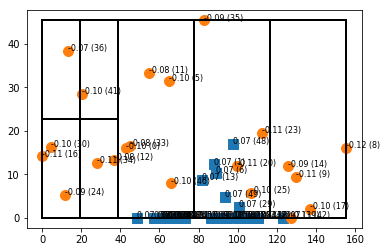

In [60]:
from boundmixofgaussians import zeromean_gaussian_1d, zeromean_gaussian, findbound, PCA
dim0 = diff_dim
dim1 = 2
#plt.figure(figsize=[20,20])

#plt.plot(X[EQweights>0,0],X[EQweights>0,1],'s',markersize=10,label='positive')
#plt.plot(X[EQweights<0,0],X[EQweights<0,1],'o',markersize=10,label='negative')

plt.plot(X[Y[:,0]>0,dim0],X[Y[:,0]>0,dim1],'s',markersize=10,label='positive')
plt.plot(X[Y[:,0]<0,dim0],X[Y[:,0]<0,dim1],'o',markersize=10,label='negative')
for i, (c,w) in enumerate(zip(X,EQweights)):
    plt.text(c[dim0],c[dim1],"%0.2f (%d)"%(w,i),fontsize=8)
#plt.legend()

for idx, (hypercube_start, hypercube_end) in enumerate(zip(hypercube_starts,hypercube_ends)):
    plt.plot([hypercube_start[dim0],hypercube_start[dim0],hypercube_end[dim0],hypercube_end[dim0],hypercube_start[dim0]],[hypercube_start[dim1],hypercube_end[dim1],hypercube_end[dim1],hypercube_start[dim1],hypercube_start[dim1]],'k-')
#    if idx>0: plt.text((hypercube_start[0]+hypercube_end[0])/2,(hypercube_start[1]+hypercube_end[1])/2,idx,fontsize=18)
#
#plt.plot([0,0,5,5,0],[0,5,5,0,0],'k-')
#plt.xlim([-.2,6])
#plt.ylim([-.2,6])


Thoughts:
- It's odd splitting the space doesn't seem to help - but that might be due to the space's highish dimensionality
- The poor bound might also be due to more complex structures in the actual data distribution.

In [34]:
import GPy
m = GPy.models.GPRegression(X[0:-10,:],Y[0:-10,:])
m.rbf.lengthscale=ls
m.rbf.variance=v
m.Gaussian_noise = sigma**2

minp = np.inf
maxp = -np.inf
correct = 0
for x,y in zip(X,Y):
    p = m.predict(x[None,:])[0]
    print(p,(p>0),(y>0))
    if (p>0)==(y>0): correct +=1
    minp = min(p,minp)
    maxp = max(p,maxp)
print(correct,len(X),correct/len(X))
print(minp,maxp,maxp-minp)

[[-0.216771]] [[False]] [False]
[[0.455315]] [[ True]] [ True]
[[0.432677]] [[ True]] [ True]
[[0.480266]] [[ True]] [ True]
[[0.459925]] [[ True]] [ True]
[[-0.240971]] [[False]] [False]
[[0.472293]] [[ True]] [ True]
[[0.362717]] [[ True]] [ True]
[[0.127519]] [[ True]] [False]
[[-0.015472]] [[False]] [False]
[[0.454751]] [[ True]] [ True]
[[-0.505843]] [[False]] [False]
[[-0.53191]] [[False]] [False]
[[0.436103]] [[ True]] [ True]
[[-0.288522]] [[False]] [False]
[[0.47861]] [[ True]] [ True]
[[-0.162755]] [[False]] [False]
[[-0.135587]] [[False]] [False]
[[0.278854]] [[ True]] [ True]
[[0.466653]] [[ True]] [ True]
[[-0.030436]] [[False]] [False]
[[0.439684]] [[ True]] [ True]
[[0.453654]] [[ True]] [ True]
[[-0.033623]] [[False]] [False]
[[-0.421197]] [[False]] [False]
[[-0.102092]] [[False]] [False]
[[0.464953]] [[ True]] [ True]
[[0.460597]] [[ True]] [ True]
[[0.470713]] [[ True]] [ True]
[[0.424703]] [[ True]] [ True]
[[-0.272803]] [[False]] [False]
[[0.490313]] [[ True]] [ Tru

In [116]:
m.optimize()

In [117]:
m

# Classification (with GPy)

In [ ]:
#np.set_printoptions(suppress=True,precision=6)

In [23]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from GPAdversarialBound import compute_full_bound, zeromean_gaussian

dims = 2
X = np.random.rand(50,dims)*4
Y = np.cos(X[:,0:1]*3)>0.5
kern = GPy.kern.RBF(2)
m = GPy.models.GPClassification(X,Y,kern)
m.inference_method = GPy.inference.latent_function_inference.laplace.Laplace()
#m.kern.variance.fix()
#m.kern.lengthscale.fix(1.0)
m.optimize()
m.kern.variance = 4.0 #artificially reduce the variance for now - bit of a hack!


In [24]:
m

In [25]:
np.max(X,0)

array([3.971463, 3.943724])

In [26]:
diff_dim = 0
sigma = 0.0001 ###!!! GP Classification doesn't have Gaussian noise!
v = m.kern.variance.values[0]
ls = m.kern.lengthscale.values[0]
splitcount = 100
forceignorenegatives = False
fhat = m.inference_method.f_hat
dims = X.shape[1]
cubesize = 4
gridres = 20
logistic_transform = True

bound, hypercube_starts, hypercube_ends, maxseg, EQweights = compute_full_bound(X,fhat,sigma,ls,v,diff_dim,dims,cubesize,gridres=gridres,splitcount=splitcount,logistic_transform=logistic_transform)
negbound, hypercube_startsneg, hypercube_endsneg, maxsegneg, EQweightsneg = compute_full_bound(X,-fhat,sigma,ls,v,diff_dim,dims,cubesize,gridres=gridres,splitcount=splitcount,logistic_transform=logistic_transform)

Splitting...
Computing Paths...
Checking Segments...

0/1160..[76, 21] [2.29325]

1/1160......[21, 91, 38, 54, 100, 53] [2.884922]

2/1160.......[1.25 1.5 ] [3.75 1.5 ]
start>end
[41, 19, 36, 75, 33, 15, 17] 0

3/1160.......[1.5  2.75] [3.5 2.5]
start>end
[83, 37, 66, 93, 32, 10, 72] 0

4/1160........[0.5  1.75] [3.5 1.5]
start>end
[99, 23, 84, 77, 36, 75, 33, 15] 0

5/1160.......[1.25 2.5 ] [3.75 2.25]
start>end
[40, 12, 45, 4, 32, 58, 52] 0

6/1160.....[31, 63, 76, 21, 34] [1.264712]

7/1160..........[0.  1.5] [3.75 1.5 ]
start>end
[55, 99, 23, 41, 19, 36, 75, 33, 15, 17] 0

8/1160.........[8, 69, 89, 87, 42, 29, 53, 16, 35] [1.934962]

9/1160.......[101, 65, 86, 27, 24, 33, 15] [0.617276]

10/1160..[63, 76] [1.543066]

11/1160[74] [0.818569]

12/1160..[73, 82] [2.281714]

13/1160.............[0.  1.5] [3.75 1.5 ]
start>end
[55, 62, 9, 79, 101, 65, 86, 27, 24, 33, 56, 78, 47] 0

14/1160.......[23, 84, 77, 36, 75, 33, 56] [0.864566]

15/1160.........[1.   2.75] [3.25 2.5 ]
start>end
[

220/1160......[49, 50, 68, 73, 82, 67] [4.492474]

221/1160..[100, 53] [1.999494]

222/1160.......[95, 49, 50, 68, 73, 82, 67] [5.050032]

223/1160...[62, 9, 79] [2.12649]

224/1160[46] [0.717268]

225/1160........[1.375 1.5  ] [3.5 1.5]
start>end
[101, 65, 86, 27, 24, 33, 56, 78] 0

226/1160...........[0.   3.75] [4.  3.5]
start>end
[31, 63, 76, 21, 91, 38, 54, 100, 53, 16, 35] 0

227/1160.......[89, 87, 42, 29, 53, 16, 35] [0.699447]

228/1160..[50, 25] [2.126689]

229/1160...........[3, 64, 20, 71, 90, 83, 37, 66, 93, 32, 58] [1.112364]

230/1160.............[0.5  2.75] [4.  2.5]
start>end
[64, 20, 71, 90, 83, 37, 66, 93, 32, 10, 72, 18, 57] 0

231/1160.........[6, 81, 14, 43, 2, 94, 46, 7, 44] [1.368487]

232/1160..[30, 22] [2.700092]

233/1160......[95, 49, 50, 68, 73, 82] [4.81855]

234/1160......[1.5 3.5] [4.   3.25]
start>end
[13, 42, 29, 53, 16, 92] 0

235/1160........[64, 20, 71, 90, 83, 37, 66, 93] [4.423991]

236/1160.......[90, 83, 37, 66, 93, 32, 58] [-0.003556]

237/1160

521/1160........[1.5 1.5] [3.75 1.5 ]
start>end
[65, 86, 27, 24, 33, 56, 78, 47] 0

522/1160.........[3, 51, 5, 88, 12, 45, 4, 32, 10] [0.198568]

523/1160....[62, 9, 39, 97] [2.72648]

524/1160........[64, 20, 30, 22, 37, 66, 93, 32] [3.265169]

525/1160......[31, 63, 76, 21, 34, 96] [1.694371]

526/1160......[1.5 1.5] [3.25 1.25]
start>end
[11, 74, 27, 24, 33, 56] 0

527/1160..[99, 23] [1.963522]

528/1160.......[19, 36, 75, 33, 56, 78, 47] [-0.041113]

529/1160..[19, 36] [2.222819]

530/1160......[1.5  1.75] [3.75 1.5 ]
start>end
[77, 36, 75, 33, 15, 17] 0

531/1160...[100, 53, 16] [0.896134]

532/1160........[1.625 1.5  ] [4.   1.25]
start>end
[74, 27, 24, 33, 56, 78, 47, 60] 0

533/1160...........[95, 49, 50, 25, 80, 28, 98, 67, 70, 46, 7] [1.92256]

534/1160...[31, 48, 8] [1.293855]

535/1160[81] [0.996823]

536/1160.....[20, 30, 22, 37, 66] [3.927153]

537/1160.........[1.25 2.5 ] [3.75 2.5 ]
start>end
[30, 22, 37, 66, 93, 32, 10, 72, 18] 0

538/1160........[0.5 1.5] [3.5 1.5]
s

825/1160[64] [1.18336]

826/1160....[23, 41, 19, 36] [3.848401]

827/1160.........[0.  2.5] [3.5  2.25]
start>end
[3, 51, 5, 40, 12, 45, 4, 32, 58] 0

828/1160.........[55, 99, 23, 41, 19, 36, 75, 33, 56] [0.155171]

829/1160..............[0.  1.5] [4.   1.25]
start>end
[55, 62, 9, 39, 97, 11, 74, 27, 24, 33, 56, 78, 47, 60] 0

830/1160[30] [1.388341]

831/1160..[33, 15] [1.833055]

832/1160......[36, 75, 33, 56, 78, 47] [-0.888553]

833/1160...[9, 79, 101] [2.126655]

834/1160..[67, 70] [1.50516]

835/1160.........[1.  2.5] [4.   2.25]
start>end
[5, 40, 12, 45, 4, 32, 58, 52, 59] 0

836/1160....[74, 27, 24, 33] [1.351903]

837/1160..........[0.5  1.75] [4.  1.5]
start>end
[99, 23, 84, 77, 36, 75, 33, 15, 17, 61] 0

838/1160.....[3, 64, 20, 30, 22] [3.194887]

839/1160...[13, 42, 29] [3.303568]

840/1160....[39, 97, 11, 74] [2.647442]

841/1160...[33, 15, 17] [1.458153]

842/1160.......[76, 21, 91, 38, 54, 100, 53] [2.940269]

843/1160........[1.25 1.5 ] [3.25 1.5 ]
start>end
[79, 101,

997/1160.....[63, 76, 21, 91, 38] [3.089633]

998/1160......[21, 34, 96, 38, 54, 100] [4.906171]

999/1160........[34, 96, 38, 54, 100, 53, 16, 92] [1.200679]

1000/1160.....[50, 25, 80, 28, 98] [3.637371]

1001/1160......[55, 99, 23, 41, 19, 36] [2.846535]

1002/1160.......[62, 9, 79, 101, 65, 86, 27] [4.786384]

1003/1160......[99, 23, 41, 19, 36, 75] [5.008619]

1004/1160.....[32, 10, 72, 18, 57] [2.723045]

1005/1160............[64, 20, 71, 90, 83, 37, 66, 93, 32, 58, 52, 59] [2.45358]

1006/1160.........[64, 20, 71, 90, 83, 37, 66, 93, 32] [3.638875]

1007/1160........[50, 25, 80, 28, 98, 67, 70, 46] [3.066462]

1008/1160[86] [0.721545]

1009/1160....[40, 12, 45, 4] [3.179067]

1010/1160...........[20, 71, 90, 83, 37, 66, 93, 32, 58, 52, 59] [1.936544]

1011/1160.......[28, 98, 67, 70, 46, 7, 44] [-0.704801]

1012/1160[36] [0.799517]

1013/1160.....[2.  2.5] [3.5 2.5]
start>end
[66, 93, 32, 10, 72] 0

1014/1160...[69, 89, 87] [2.57911]

1015/1160....[20, 30, 22, 37] [3.926518]

10

Computing Paths...
Checking Segments...

0/1169......[1, 22, 10, 51, 2, 56] [-0.004435]

1/1169....[3, 45, 12, 32] [3.768855]

2/1169..[28, 41] [1.906766]

3/1169.......[41, 8, 50, 74, 99, 101, 24] [5.117283]

4/1169.....[93, 36, 9, 42, 95] [0.612378]

5/1169[74] [0.727975]

6/1169....[76, 55, 62, 73] [2.07125]

7/1169........[0.5  0.75] [3.  0.5]
start>end
[22, 10, 51, 43, 46, 84, 96, 34] 0

8/1169.....[48, 70, 27, 58, 89] [3.457916]

9/1169.......[28, 41, 8, 50, 74, 99, 101] [2.262336]

10/1169........[0.5 0.5] [3.  0.5]
start>end
[78, 82, 10, 51, 2, 56, 14, 49] 0

11/1169......[52, 92, 88, 25, 37, 23] [0.073972]

12/1169...[70, 27, 58] [2.786047]

13/1169...........[13, 77, 19, 21, 93, 36, 9, 42, 95, 15, 98] [0.774028]

14/1169[24] [1.355199]

15/1169..........[0.  1.5] [2.75 1.25]
start>end
[61, 81, 53, 71, 28, 41, 8, 50, 11, 94] 0

16/1169..........[21, 93, 36, 9, 42, 95, 15, 98, 39, 44] [2.208171]

17/1169........[93, 36, 9, 85, 86, 39, 44, 69] [2.005473]

18/1169.....[36, 9, 85,

[73, 83, 36, 9, 85, 86, 39] 0

229/1169......[60, 52, 92, 88, 25, 72] [-0.716075]

230/1169...........[0.5 3.5] [3.   3.25]
start>end
[55, 62, 73, 83, 36, 9, 42, 95, 15, 98, 39] 0

231/1169...[1.25 3.5 ] [2.25 3.5 ]
start>end
[93, 36, 40] 0

232/1169.........[0.25 1.75] [3.  1.5]
start>end
[65, 18, 63, 28, 80, 35, 48, 70, 27] 0

233/1169....[84, 96, 34, 5] [3.507463]

234/1169....[85, 86, 39, 44] [4.098184]

235/1169....[81, 53, 71, 28] [2.565159]

236/1169...........[16, 65, 18, 63, 28, 41, 8, 50, 11, 94, 26] [2.129924]

237/1169..[6, 47] [1.610596]

238/1169.......[78, 82, 10, 51, 43, 46, 84] [-0.819967]

239/1169..........[60, 52, 92, 88, 25, 37, 23, 90, 29, 79] [2.235041]

240/1169[89] [0.478947]

241/1169.........[1.  3.5] [4.  3.5]
start>end
[73, 83, 36, 9, 85, 86, 39, 44, 69] 0

242/1169.....[4, 17, 7, 31, 3] [-0.638147]

243/1169............[81, 53, 71, 28, 80, 35, 48, 70, 27, 58, 89, 30] [1.331609]

244/1169.....[35, 48, 20, 27, 58] [3.903705]

245/1169........[41, 8, 50, 74, 

386/1169.....[13, 77, 19, 21, 93] [1.711486]

387/1169......[61, 81, 53, 71, 28, 80] [1.530988]

388/1169...[92, 88, 25] [0.754761]

389/1169.........[4, 17, 7, 31, 3, 100, 75, 97, 32] [1.872038]

390/1169.........[81, 53, 71, 28, 80, 35, 48, 70, 27] [1.606802]

391/1169[93] [0.628365]

392/1169.....[72, 91, 68, 87, 29] [3.380858]

393/1169..[21, 93] [1.308104]

394/1169....[36, 9, 85, 86] [3.714853]

395/1169..........[0.25 3.5 ] [2.625 3.25 ]
start>end
[76, 55, 62, 73, 83, 36, 9, 42, 95, 15] 0

396/1169...[32, 6, 47] [1.263117]

397/1169...........[0.  1.5] [3.  1.5]
start>end
[61, 81, 53, 71, 28, 41, 8, 50, 74, 99, 101] 0

398/1169[43] [0.955591]

399/1169....[12, 32, 6, 47] [2.198912]

400/1169.........[0.  3.5] [2.5 3.5]
start>end
[64, 76, 55, 62, 73, 83, 36, 9, 85] 0

401/1169......[80, 35, 48, 20, 27, 58] [4.431022]

402/1169.......[10, 51, 43, 46, 84, 96, 34] [2.121255]

403/1169.......[51, 43, 46, 33, 34, 5, 59] [4.906207]

404/1169....[35, 48, 70, 27] [3.555199]

405/1169...[

685/1169.........[71, 28, 80, 35, 48, 20, 27, 58, 89] [0.958336]

686/1169......[2, 56, 14, 49, 5, 59] [4.281278]

687/1169..........[1.  3.5] [3.5  3.25]
start>end
[73, 83, 36, 9, 42, 95, 15, 98, 39, 44] 0

688/1169......[18, 63, 28, 41, 8, 50] [-0.883446]

689/1169......[88, 25, 72, 91, 68, 87] [3.645136]

690/1169......[88, 25, 37, 23, 90, 29] [4.5819]

691/1169...[27, 58, 89] [1.872203]

692/1169.........[0.5  1.75] [3.25 1.5 ]
start>end
[18, 63, 28, 80, 35, 48, 70, 27, 58] 0

693/1169......[71, 28, 80, 35, 48, 70] [0.097958]

694/1169....[10, 51, 2, 56] [0.041895]

695/1169.........[82, 10, 51, 43, 46, 84, 96, 34, 5] [1.185034]

696/1169.....[63, 28, 41, 8, 50] [-1.382167]

697/1169..[22, 10] [1.815892]

698/1169....[92, 88, 25, 37] [1.414091]

699/1169.........[63, 28, 41, 8, 50, 74, 99, 101, 24] [1.299467]

700/1169.........[0.  0.5] [2.75 0.5 ]
start>end
[66, 67, 78, 82, 10, 51, 2, 56, 14] 0

701/1169[85] [1.493649]

702/1169.......[0.5 0.5] [2.75 0.5 ]
start>end
[78, 82, 10, 5

844/1169...........[21, 93, 36, 9, 42, 95, 15, 98, 39, 44, 69] [1.191948]

845/1169....[53, 71, 28, 80] [0.462621]

846/1169...[98, 39, 44] [2.463326]

847/1169..........[0.25 1.75] [3.25 1.5 ]
start>end
[65, 18, 63, 28, 80, 35, 48, 70, 27, 58] 0

848/1169...[72, 91, 68] [1.998266]

849/1169...........[18, 63, 28, 41, 8, 50, 11, 94, 26, 24, 30] [1.423953]

850/1169.......[71, 28, 80, 35, 48, 70, 27] [0.92853]

851/1169.....[92, 88, 25, 72, 91] [1.293597]

852/1169.........[0.25 3.5 ] [2.5  3.25]
start>end
[76, 55, 62, 73, 83, 36, 9, 42, 95] 0

853/1169.......[31, 3, 100, 75, 97, 32, 6] [5.346198]

854/1169[73] [0.847774]

855/1169........[88, 25, 37, 23, 90, 29, 79, 47] [4.41215]

856/1169....[19, 21, 93, 36] [0.963018]

857/1169........[0.25 3.5 ] [2.5 3.5]
start>end
[76, 55, 62, 73, 83, 36, 9, 85] 0

858/1169........[55, 62, 73, 83, 36, 40, 54, 38] [0.424244]

859/1169[39] [0.968509]

860/1169..[31, 3] [1.637962]

861/1169......[76, 55, 62, 73, 83, 36] [0.862173]

862/1169...[68, 87,

993/1169...[81, 53, 71] [2.241801]

994/1169........[13, 77, 19, 21, 93, 36, 9, 85] [0.436869]

995/1169........[13, 77, 19, 21, 93, 36, 9, 42] [-0.529291]

996/1169....[50, 74, 99, 101] [3.56092]

997/1169..[57, 44] [1.832173]

998/1169.......[1, 22, 10, 51, 2, 56, 14] [0.849529]

999/1169.......[35, 48, 20, 27, 58, 89, 30] [3.562468]

1000/1169..[52, 92] [2.436047]

1001/1169..[7, 31] [1.712999]

1002/1169...[53, 71, 28] [1.965332]

1003/1169.......[77, 19, 21, 93, 36, 9, 42] [-1.082076]

1004/1169............[0.  1.5] [3.5  1.25]
start>end
[61, 81, 53, 71, 28, 41, 8, 50, 11, 94, 26, 24] 0

1005/1169[77] [0.738982]

1006/1169......[28, 80, 35, 48, 20, 27] [2.457356]

1007/1169......[21, 93, 36, 9, 42, 95] [-0.345869]

1008/1169...[36, 9, 42] [2.140873]

1009/1169.........[0.5 3.5] [3.5 3.5]
start>end
[19, 21, 93, 36, 40, 54, 38, 57, 44] 0

1010/1169.....[22, 10, 51, 2, 56] [-0.487462]

1011/1169..[5, 59] [1.632841]

1012/1169...[62, 73, 83] [1.033268]

1013/1169....[10, 51, 43, 46] [

I've printed the bound on the gradient of the logistic transform within each hypercube. One can see it's nearly 0.25 in almost all hypercubes, which is a problem, as the actual gradient is probably tiny in most of them.

I'll look into this, and see if we can do a better job.

In [27]:
print("Computed Bound: %0.5f and %0.5f.\n Corresponding to the path:" % (bound,negbound))
print(maxseg)
#2.57->5.88 by forcing us to ignore negatives...

Computed Bound: 5.80238 and 5.40623.
 Corresponding to the path:
[62, 9, 39, 97, 11, 74, 27, 24]


The bound is greater than 1, so this is rubbish. It doesn't say anything strong. To get this to be reasonable, we need a smaller variance, or fix the bound on the transform gradient.

 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


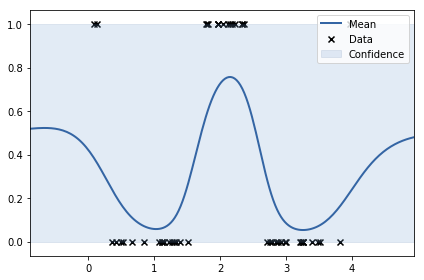

In [28]:
m.plot(fixed_inputs=[(1,0.5)])

In [29]:
testX = np.random.rand(10000,2)*4
testX[:,1]=2.5
p,_ = m.predict(testX)
np.max(p)-np.min(p)

0.7860972571369824

In [30]:
m.inference_method.f_hat.T

array([[-2.183793, -1.548434, -1.592915,  1.096442, -1.762026,  0.513601,
         0.976485, -2.001842, -1.915341, -0.730441, -1.341832, -1.809324,
         1.774486, -0.845221, -1.815397, -2.293925,  1.443892,  1.790662,
        -1.767803, -1.377641, -1.786366, -1.107269,  1.278938,  0.658805,
         0.937424,  0.955923,  0.766052,  1.104964, -1.622789, -1.420458,
        -1.017451, -1.681511, -1.880155, -0.653307, -1.29662 , -1.377098,
        -1.391041, -1.37522 , -1.697477,  0.560002,  1.515419, -1.130241,
        -0.298887, -2.255608, -1.631087, -1.002801, -1.350262,  1.77103 ,
         1.853891,  0.145912]])

(-0.2, 4.2)

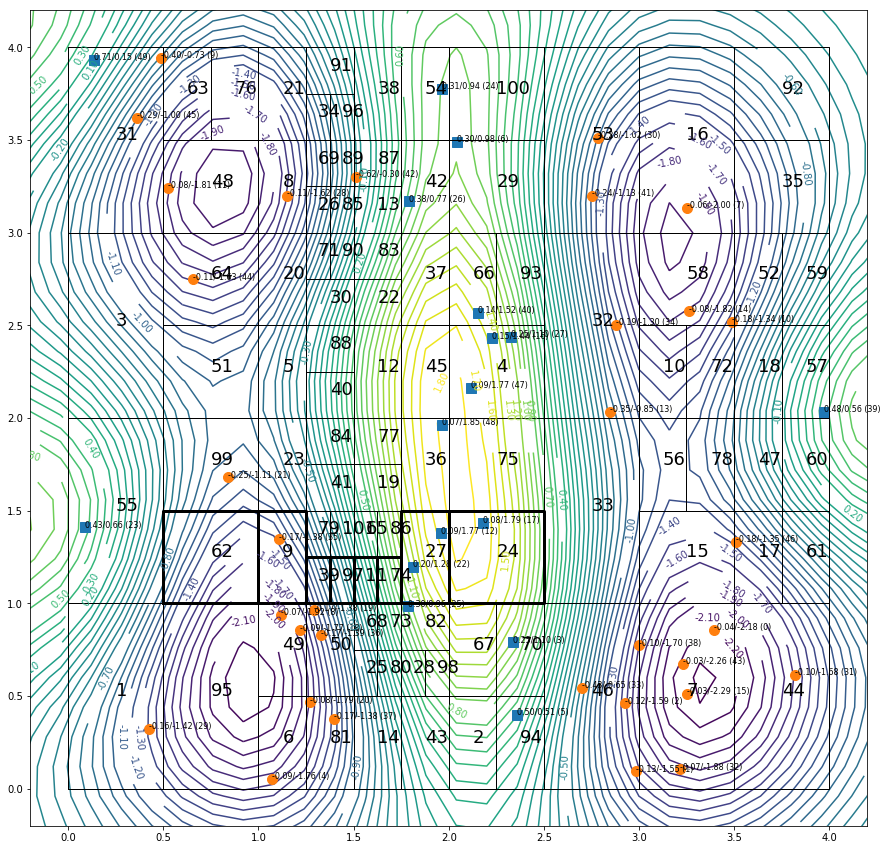

In [31]:
from boundmixofgaussians import zeromean_gaussian_1d, zeromean_gaussian, findbound, PCA

plt.figure(figsize=[15,15])
xs = np.arange(-1,10,0.16)
ys = np.arange(-1,10,0.16)
mg = np.array(np.meshgrid(xs,ys))
grid = np.array([mg[0].flatten(),mg[1].flatten()]).T
vals = np.zeros([len(xs),len(ys)])
for eq,eqw in zip(X,EQweights):
    vals += eqw*zeromean_gaussian(grid-eq,ls,v).reshape(len(xs),len(ys))
CS = plt.contour(xs,ys,vals,levels=np.arange(-20,20,0.1))
plt.clabel(CS, inline=1, fontsize=10,fmt="%1.2f")
#plt.colorbar()



#plt.plot(X[EQweights>0,0],X[EQweights>0,1],'s',markersize=10,label='positive')
#plt.plot(X[EQweights<0,0],X[EQweights<0,1],'o',markersize=10,label='negative')

plt.plot(X[fhat[:,0]>0,0],X[fhat[:,0]>0,1],'s',markersize=10,label='positive')
plt.plot(X[fhat[:,0]<0,0],X[fhat[:,0]<0,1],'o',markersize=10,label='negative')
for i, (c,w,f) in enumerate(zip(X,EQweights,fhat)):
    plt.text(c[0],c[1],"%0.2f/%0.2f (%d)"%(w,f,i),fontsize=8)
#plt.legend()

for idx, (hypercube_start, hypercube_end) in enumerate(zip(hypercube_starts,hypercube_ends)):
    if idx in maxseg:
        lw = 3
    else:
        lw = 1
    plt.plot([hypercube_start[0],hypercube_start[0],hypercube_end[0],hypercube_end[0],hypercube_start[0]],[hypercube_start[1],hypercube_end[1],hypercube_end[1],hypercube_start[1],hypercube_start[1]],'k-',lw=lw)
    if idx>0: plt.text((hypercube_start[0]+hypercube_end[0])/2,(hypercube_start[1]+hypercube_end[1])/2,idx,fontsize=18)

#plt.plot([0,0,5,5,0],[0,5,5,0,0],'k-')
plt.xlim([-.2,4.2])
plt.ylim([-.2,4.2])


# testing

In [ ]:
from GPAdversarialBound import testing
testing()